In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import torch.backends.cudnn as cudnn
from scipy.integrate import solve_ivp
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, Dataset

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [31]:
# Define the PINN model
class PINN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super(PINN, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=0.1,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(0)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) # Shape: (batch_size, hidden_dim)
        return out

# Defining the loss functions
def MSE_loss(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

def SIR_loss(model, t, beta, gamma, mu):
    t = t.requires_grad_(True)  # Enable gradient computation for time tensor

    # Forward pass through the model
    x = model(t)

    # Compute gradients
    dx_dt = torch.autograd.grad(
        x, t, grad_outputs=torch.ones_like(x), create_graph=True
    )[0]  # First derivative

    # SIR model loss: dI/dt = beta * I - gamma * I
    sir_loss = dx_dt + beta * torch.exp(x) - gamma * torch.exp(x)

    # Return the squared loss
    return torch.mean(sir_loss ** 2)

In [26]:
def SIR_model(t, y, beta, gamma):
    S, I, R = y
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dI_dt, dR_dt]

def generate_sir_data(beta, gamma, S0, I0, R0, t_span, t_eval):
    initial_conditions = [S0, I0, R0]
    sol = solve_ivp(
        SIR_model, t_span, initial_conditions, t_eval=t_eval, args=(beta, gamma)
    )
    return sol.t, sol.y

def generate_multiple_sir_datasets(num_datasets, t_span, t_eval):
    datasets = []
    for _ in range(num_datasets):
        # Randomize beta, gamma, and initial conditions
        beta = np.random.uniform(0.2, 0.5)  # Random beta
        gamma = np.random.uniform(0.05, 0.2)  # Random gamma
        S0 = np.random.uniform(0.8, 1.0)  # Initial susceptible fraction
        I0 = np.random.uniform(0.01, 0.1)  # Initial infected fraction
        R0 = 1 - S0 - I0  # Ensure S0 + I0 + R0 = 1

        t, y = generate_sir_data(beta, gamma, S0, I0, R0, t_span, t_eval)
        I_data = y[1]  # Extract the infection data

        t_tensor = torch.tensor(t, dtype=torch.float32).unsqueeze(-1)
        I_tensor = torch.tensor(I_data, dtype=torch.float32).unsqueeze(-1)

        dataset = TensorDataset(t_tensor, I_tensor)
        datasets.append(dataset)

    return datasets

# Generate multiple datasets
num_datasets = 10  # Number of SIR datasets
t_span = (0, 100)
t_eval = np.linspace(0, 100, 200)

sir_datasets = generate_multiple_sir_datasets(num_datasets, t_span, t_eval)

# Combine datasets for a single DataLoader
combined_dataset = ConcatDataset(sir_datasets)
dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

### Training

In [7]:
import torch.optim as optim

model = PINN(input_dim=1, hidden_dim=64, num_layers=2, output_dim=1)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(100):  # Number of epochs
    total_loss = 0.0
    for t_batch, I_batch in dataloader:
        optimizer.zero_grad()

        # Forward pass
        I_pred = model(t_batch)

        # Compute losses
        mse = MSE_loss(I_batch, I_pred)
        sir = SIR_loss(model, t_batch, torch.tensor(0.3), torch.tensor(0.1), 0.0)
        loss = mse + sir

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 3.8877
Epoch 2, Loss: 3.8264
Epoch 3, Loss: 3.8081
Epoch 4, Loss: 3.8094
Epoch 5, Loss: 3.8102
Epoch 6, Loss: 3.7950
Epoch 7, Loss: 3.8055
Epoch 8, Loss: 3.7897
Epoch 9, Loss: 3.8255
Epoch 10, Loss: 3.8017
Epoch 11, Loss: 3.8062
Epoch 12, Loss: 3.8023
Epoch 13, Loss: 3.7825
Epoch 14, Loss: 3.8024
Epoch 15, Loss: 3.8221
Epoch 16, Loss: 3.7875
Epoch 17, Loss: 3.8135
Epoch 18, Loss: 3.7964
Epoch 19, Loss: 3.7953
Epoch 20, Loss: 3.7963
Epoch 21, Loss: 3.8031
Epoch 22, Loss: 3.8129
Epoch 23, Loss: 3.8048
Epoch 24, Loss: 3.7894
Epoch 25, Loss: 3.7918
Epoch 26, Loss: 3.8118
Epoch 27, Loss: 3.7980
Epoch 28, Loss: 3.7980
Epoch 29, Loss: 3.7954
Epoch 30, Loss: 3.8050
Epoch 31, Loss: 3.7942
Epoch 32, Loss: 3.7744
Epoch 33, Loss: 3.7887
Epoch 34, Loss: 3.8097
Epoch 35, Loss: 3.7928
Epoch 36, Loss: 3.7944
Epoch 37, Loss: 3.7864
Epoch 38, Loss: 3.7985
Epoch 39, Loss: 3.7801
Epoch 40, Loss: 3.7990
Epoch 41, Loss: 3.7930
Epoch 42, Loss: 3.7956
Epoch 43, Loss: 3.8092
Epoch 44, Loss: 3.79

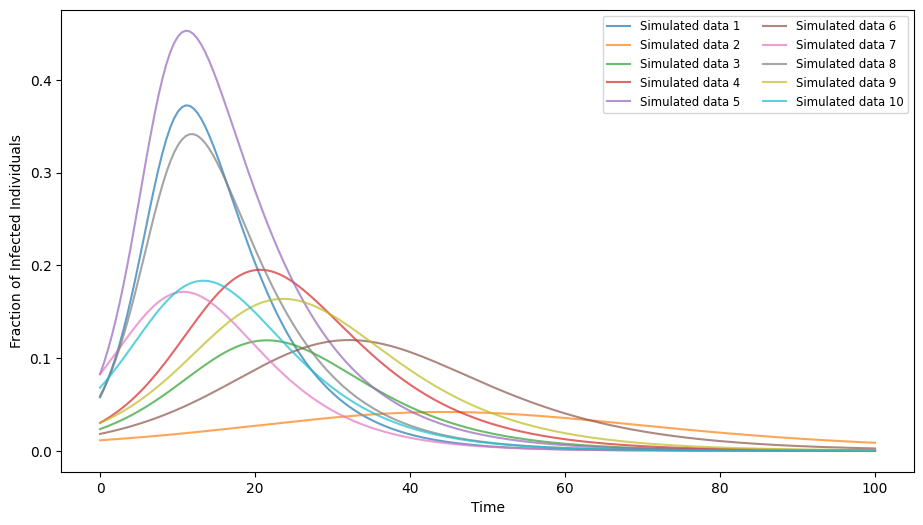

In [77]:
# Generate and plot multiple SIR datasets using NumPy and Matplotlib
def generate_sir_data_numpy(beta, gamma, S0, I0, R0, t_eval):
    S, I, R = S0, I0, R0
    S_list, I_list, R_list = [S], [I], [R]
    dt = t_eval[1] - t_eval[0]
    for _ in t_eval[1:]:
        dS_dt = -beta * S * I
        dI_dt = beta * S * I - gamma * I
        dR_dt = gamma * I

        S += dS_dt * dt
        I += dI_dt * dt
        R += dR_dt * dt

        S_list.append(S)
        I_list.append(I)
        R_list.append(R)

    return np.array(S_list), np.array(I_list), np.array(R_list)

# Parameters
num_datasets = 10
t_eval = np.linspace(0, 100, 200)
datasets = []

for _ in range(num_datasets):
    beta = np.random.uniform(0.2, 0.5)  # Random beta
    gamma = np.random.uniform(0.05, 0.2)  # Random gamma
    S0 = np.random.uniform(0.8, 1.0)  # Initial susceptible fraction
    I0 = np.random.uniform(0.01, 0.1)  # Initial infected fraction
    R0 = 1 - S0 - I0

    S, I, R = generate_sir_data_numpy(beta, gamma, S0, I0, R0, t_eval)
    datasets.append((t_eval, I))

# Plot the datasets
plt.figure(figsize=(11, 6))
for i, (t, I) in enumerate(datasets):
    plt.plot(t, I, label=f"Simulated data {i + 1}", alpha=0.7)

#plt.title("Simulated SIR Infection Datasets")
plt.xlabel("Time")
plt.ylabel("Fraction of Infected Individuals")
plt.legend(loc='upper right', ncol=2, fontsize='small')
#plt.grid()
plt.show()

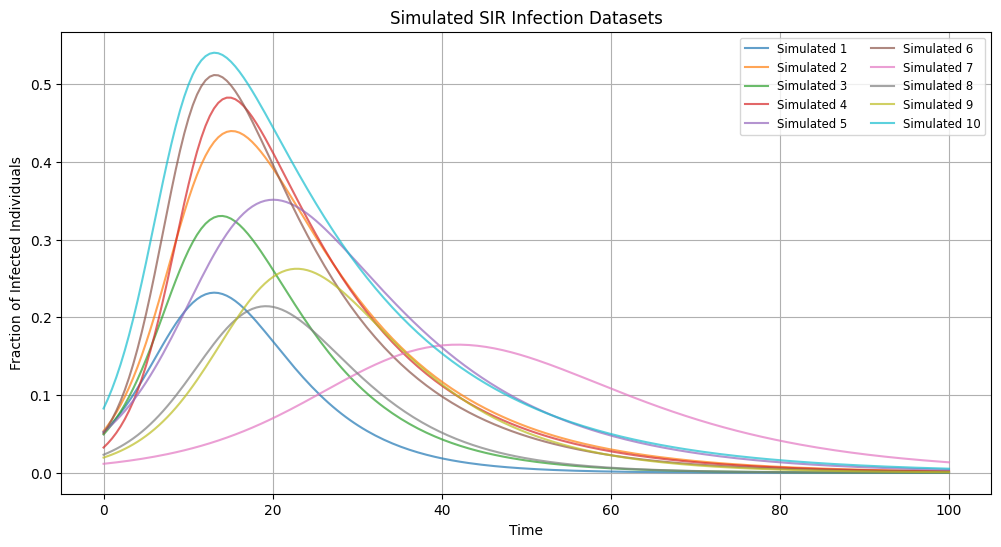

In [58]:
# Custom dataset for autoregressive training
class SIRSequenceDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.sequence_length]
        y = self.data[idx + self.sequence_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Generate SIR data using NumPy
def generate_sir_data_numpy(beta, gamma, S0, I0, R0, t_eval):
    S, I, R = S0, I0, R0
    S_list, I_list, R_list = [S], [I], [R]
    dt = t_eval[1] - t_eval[0]
    for _ in t_eval[1:]:
        dS_dt = -beta * S * I
        dI_dt = beta * S * I - gamma * I
        dR_dt = gamma * I

        S += dS_dt * dt
        I += dI_dt * dt
        R += dR_dt * dt

        S_list.append(S)
        I_list.append(I)
        R_list.append(R)

    return np.array(S_list), np.array(I_list), np.array(R_list)

# Generate multiple datasets
def generate_multiple_sir_sequences(num_sequences, t_eval, sequence_length):
    sequences = []
    for _ in range(num_sequences):
        beta = np.random.uniform(0.2, 0.5)
        gamma = np.random.uniform(0.05, 0.2)
        S0 = np.random.uniform(0.8, 1.0)
        I0 = np.random.uniform(0.01, 0.1)
        R0 = 1 - S0 - I0
        _, I, _ = generate_sir_data_numpy(beta, gamma, S0, I0, R0, t_eval)
        sequences.append(I)
    return sequences

# Parameters
num_sequences = 10
sequence_length = 2
t_eval = np.linspace(0, 100, 200)
sir_sequences = generate_multiple_sir_sequences(num_sequences, t_eval, sequence_length)

# Combine sequences into a dataset
all_data = np.concatenate(sir_sequences)
dataset = SIRSequenceDataset(all_data, sequence_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Plot the datasets
plt.figure(figsize=(12, 6))
for i, (t, I) in enumerate(datasets):
    plt.plot(t, I, label=f"Simulated {i + 1}", alpha=0.7)

plt.title("Simulated SIR Infection Datasets")
plt.xlabel("Time")
plt.ylabel("Fraction of Infected Individuals")
plt.legend(loc='upper right', ncol=2, fontsize='small')
plt.grid()
plt.show()

In [29]:
# Initialize the model, loss, and optimizer
model = PINN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Pre-training loop
epochs = 50
for epoch in range(epochs):
    total_loss = 0.0
    for x_batch, y_batch in dataloader:
        x_batch = x_batch.unsqueeze(-1)  # Add feature dimension
        y_batch = y_batch.unsqueeze(-1)

        # Forward pass
        y_pred = model(x_batch)

        # Compute loss
        loss = criterion(y_pred, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/50, Loss: 0.3453
Epoch 2/50, Loss: 0.0512
Epoch 3/50, Loss: 0.0245
Epoch 4/50, Loss: 0.0124
Epoch 5/50, Loss: 0.0130
Epoch 6/50, Loss: 0.0122
Epoch 7/50, Loss: 0.0104
Epoch 8/50, Loss: 0.0096
Epoch 9/50, Loss: 0.0088
Epoch 10/50, Loss: 0.0098
Epoch 11/50, Loss: 0.0092
Epoch 12/50, Loss: 0.0088
Epoch 13/50, Loss: 0.0094
Epoch 14/50, Loss: 0.0071
Epoch 15/50, Loss: 0.0076
Epoch 16/50, Loss: 0.0066
Epoch 17/50, Loss: 0.0073
Epoch 18/50, Loss: 0.0071
Epoch 19/50, Loss: 0.0057
Epoch 20/50, Loss: 0.0069
Epoch 21/50, Loss: 0.0067
Epoch 22/50, Loss: 0.0061
Epoch 23/50, Loss: 0.0054
Epoch 24/50, Loss: 0.0050
Epoch 25/50, Loss: 0.0058
Epoch 26/50, Loss: 0.0052
Epoch 27/50, Loss: 0.0048
Epoch 28/50, Loss: 0.0054
Epoch 29/50, Loss: 0.0059
Epoch 30/50, Loss: 0.0048
Epoch 31/50, Loss: 0.0058
Epoch 32/50, Loss: 0.0049
Epoch 33/50, Loss: 0.0049
Epoch 34/50, Loss: 0.0053
Epoch 35/50, Loss: 0.0047
Epoch 36/50, Loss: 0.0046
Epoch 37/50, Loss: 0.0044
Epoch 38/50, Loss: 0.0048
Epoch 39/50, Loss: 0.

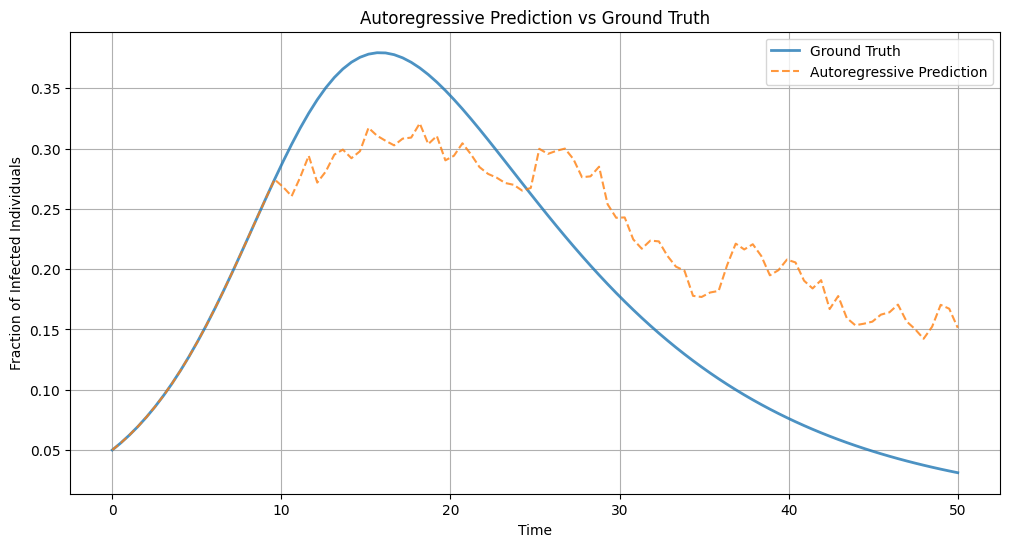

In [30]:
# Recreate necessary components for generating SIR data and predictions
import numpy as np
import matplotlib.pyplot as plt

# Function to generate SIR data
def generate_sir_data_numpy(beta, gamma, S0, I0, R0, t_eval):
    S, I, R = S0, I0, R0
    S_list, I_list, R_list = [S], [I], [R]
    dt = t_eval[1] - t_eval[0]
    for _ in t_eval[1:]:
        dS_dt = -beta * S * I
        dI_dt = beta * S * I - gamma * I
        dR_dt = gamma * I

        S += dS_dt * dt
        I += dI_dt * dt
        R += dR_dt * dt

        S_list.append(S)
        I_list.append(I)
        R_list.append(R)

    return np.array(S_list), np.array(I_list), np.array(R_list)

# Generate test SIR data
beta_test = 0.35
gamma_test = 0.1
S0_test, I0_test, R0_test = 0.95, 0.05, 0.0
t_test = np.linspace(0, 50, 100)  # Test time range
_, I_test, _ = generate_sir_data_numpy(beta_test, gamma_test, S0_test, I0_test, R0_test, t_test)

# Simulate autoregressive predictions using a mock function
def mock_predict(prev_sequence):
    # For simplicity, predict the next value as the last value + noise
    return prev_sequence[-1] + np.random.normal(0, 0.01)

# Initialize for autoregressive prediction
sequence_length = 20
initial_sequence = I_test[:sequence_length]
predictions = list(initial_sequence)

# Perform autoregressive prediction
for _ in range(len(I_test) - sequence_length):
    next_pred = mock_predict(predictions[-sequence_length:])  # Use last sequence for prediction
    predictions.append(next_pred)

# Plot the ground truth and predictions
plt.figure(figsize=(12, 6))
plt.plot(t_test, I_test, label="Ground Truth", linewidth=2, alpha=0.8)
plt.plot(t_test, predictions, label="Autoregressive Prediction", linestyle="dashed", alpha=0.8)
plt.title("Autoregressive Prediction vs Ground Truth")
plt.xlabel("Time")
plt.ylabel("Fraction of Infected Individuals")
plt.legend()
plt.grid()
plt.show()


# 원래 방법대로

In [41]:
# Define the PINN model
class PINN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super(PINN, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=0.1,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(0)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) # Shape: (batch_size, hidden_dim)
        return out

# Defining the loss functions
def MSE_loss(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

def SIR_loss(model, t, beta, gamma, mu):
    t = t.requires_grad_(True)  # Enable gradient computation for time tensor

    # Forward pass through the model
    x = model(t)

    # Compute gradients
    dx_dt = torch.autograd.grad(
        x, t, grad_outputs=torch.ones_like(x), create_graph=True
    )[0]  # First derivative

    # SIR model loss: dI/dt = beta * I - gamma * I
    sir_loss = dx_dt + beta * torch.exp(x) - gamma * torch.exp(x)

    # Return the squared loss
    return torch.mean(sir_loss ** 2)

In [42]:
def SIR_model(t, y, beta, gamma):
    S, I, R = y
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dI_dt, dR_dt]

def generate_sir_data(beta, gamma, S0, I0, R0, t_span, t_eval):
    initial_conditions = [S0, I0, R0]
    sol = solve_ivp(
        SIR_model, t_span, initial_conditions, t_eval=t_eval, args=(beta, gamma)
    )
    return sol.t, sol.y

def generate_multiple_sir_datasets(num_datasets, t_span, t_eval):
    datasets = []
    for _ in range(num_datasets):
        # Randomize beta, gamma, and initial conditions
        beta = np.random.uniform(0.2, 0.5)  # Random beta
        gamma = np.random.uniform(0.05, 0.2)  # Random gamma
        S0 = np.random.uniform(0.8, 1.0)  # Initial susceptible fraction
        I0 = np.random.uniform(0.01, 0.1)  # Initial infected fraction
        R0 = 1 - S0 - I0  # Ensure S0 + I0 + R0 = 1

        t, y = generate_sir_data(beta, gamma, S0, I0, R0, t_span, t_eval)
        I_data = y[1]  # Extract the infection data

        t_tensor = torch.tensor(t, dtype=torch.float32).unsqueeze(-1)
        I_tensor = torch.tensor(I_data, dtype=torch.float32).unsqueeze(-1)

        dataset = TensorDataset(t_tensor, I_tensor)
        datasets.append(dataset)

    return datasets

# Generate multiple datasets
num_datasets = 10  # Number of SIR datasets
t_span = (0, 100)
t_eval = np.linspace(0, 100, 200)

sir_datasets = generate_multiple_sir_datasets(num_datasets, t_span, t_eval)

# Combine datasets for a single DataLoader
combined_dataset = ConcatDataset(sir_datasets)
dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

In [43]:
def plot_predictions(data, test_start_point, predicted_values, epoch):
    """
    Plot predictions and training results.
    """
    # Ensure the save directory exists
    #if not os.path.exists(save_path):
    #    os.makedirs(save_path)

    data = data.cpu().numpy()

    predictions = np.append(np.array([None]*test_start_point), predicted_values)

    fig, ax1 = plt.subplots(figsize=(18, 8))

    # Training Data
    ax1.plot(data, 'ro', markersize=8, label='Training data')

    # Predicted values
    ax1.plot(predictions, color="orange", label="Predicted by PINN")

    # Format x-axis
    ax1.set_xlabel("Date")
    ax1.set_ylabel("I(t)", color="k")
    ax1.tick_params(axis='y', labelcolor="k")
    ax1.legend(loc="upper left")
    ax1.grid()

    # Plotting
    plt.tight_layout()
    plt.show()
    plt.close()

In [44]:
class EarlyStopping:
    def __init__(self, model, patience, display_step, sigma, sigma0, mu):
        self.patience = patience
        self.display_step = display_step
        self.model = model
        self.sigma = sigma
        self.sigma0 = sigma0
        self.mu = mu
        
        self.best_loss = np.inf
        self.wait = 0

        self.best_model = None
        self.bests_weights = None
        self.bestSigma = None
        self.bestSigma0 = None
        self.bestMu = None

    def check_early_stopping(self, current_loss, epoch):
        if current_loss < self.best_loss:
            self.best_loss = current_loss.cpu().item() if torch.is_tensor(current_loss) else current_loss
            self.wait = 0

            self.best_model = self.model
            self.best_weights = self.model.state_dict()
            self.bestSigma = self.sigma
            self.bestSigma0 = self.sigma0
            self.bestMu = self.mu
        else:
            self.wait += 1
        
        if self.wait >= self.patience:
            print(f"Early stopping at epoch {epoch}.")
            self.model.load_state_dict(self.best_weights)
            return True
        return False

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_2168\1350617788.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_2168\1350617788.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


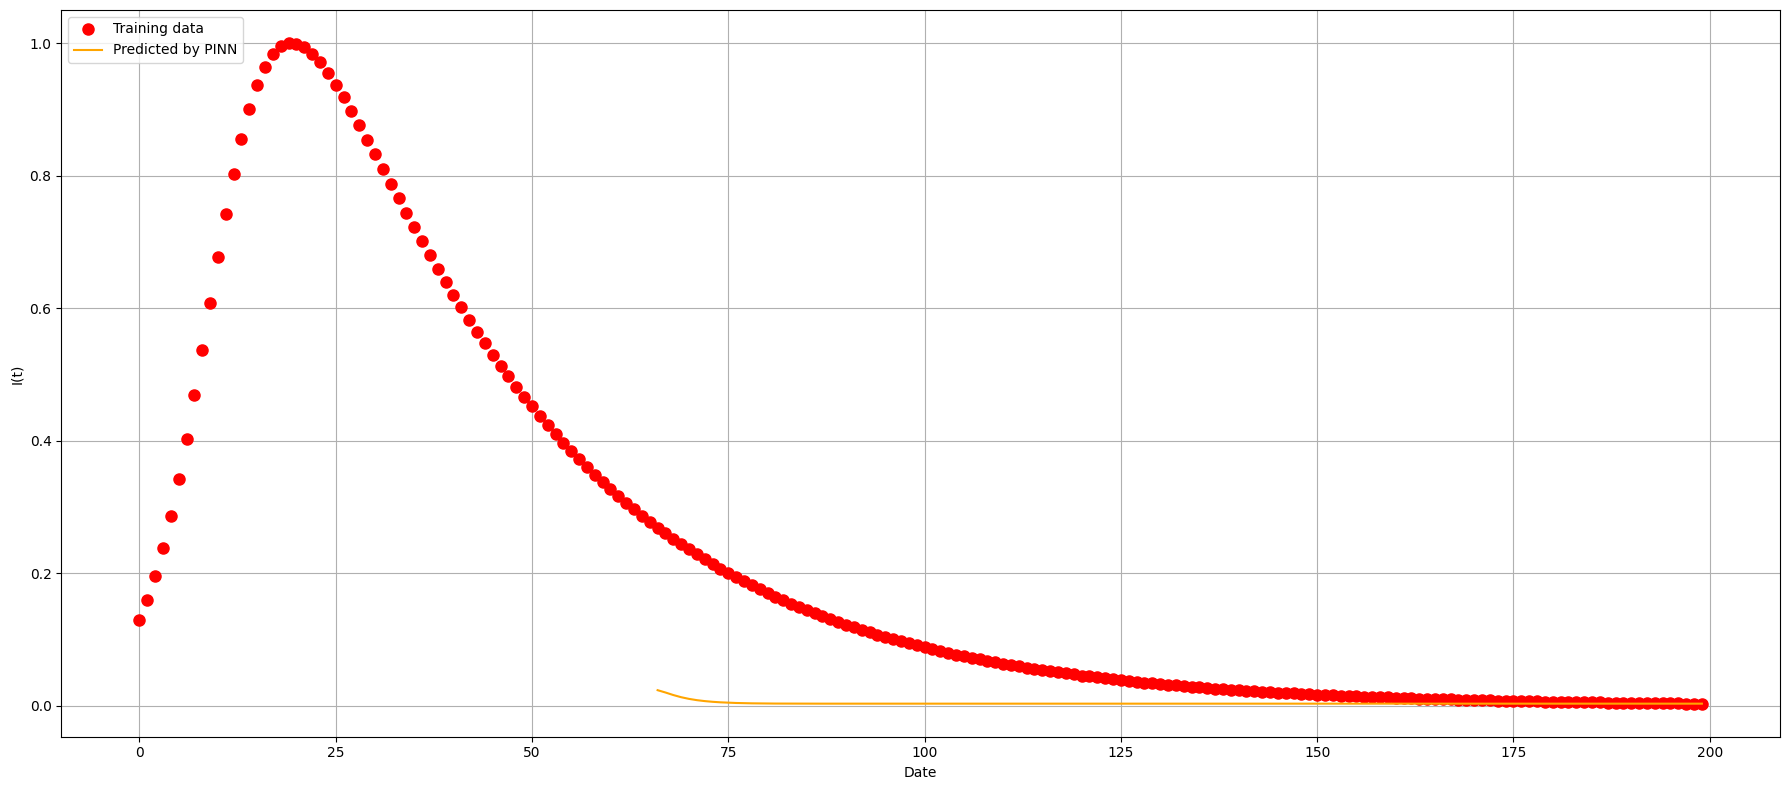

Epoch 1, MSE Loss = 8.365471876459196e-05, Average Loss = 0.031728355377719425


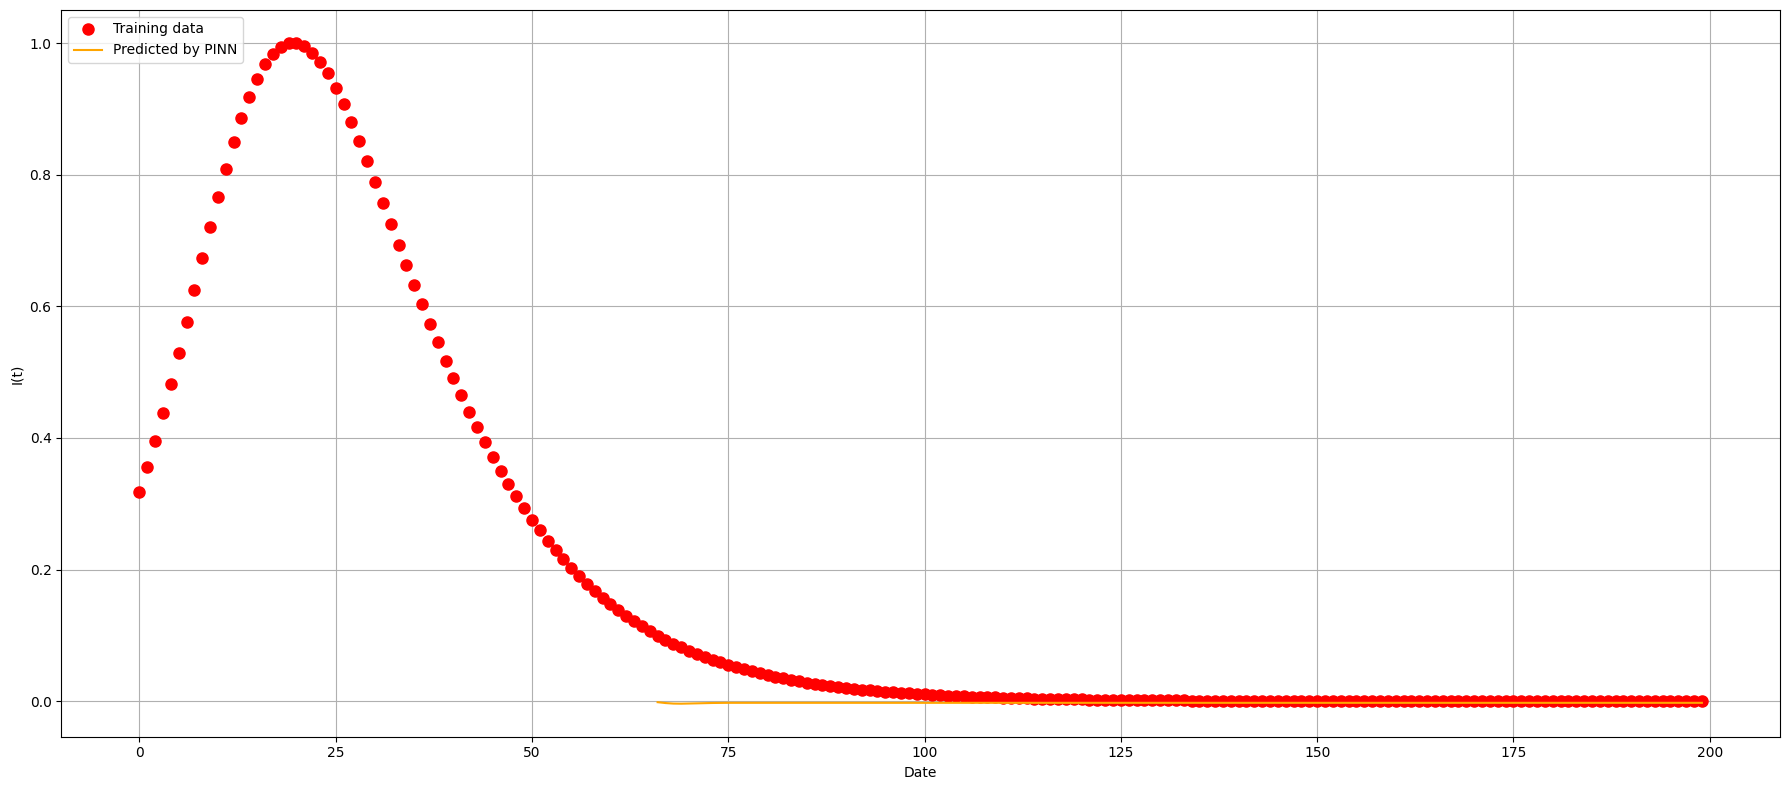

Epoch 1, MSE Loss = 7.48623065760512e-08, Average Loss = 0.037953372736155344


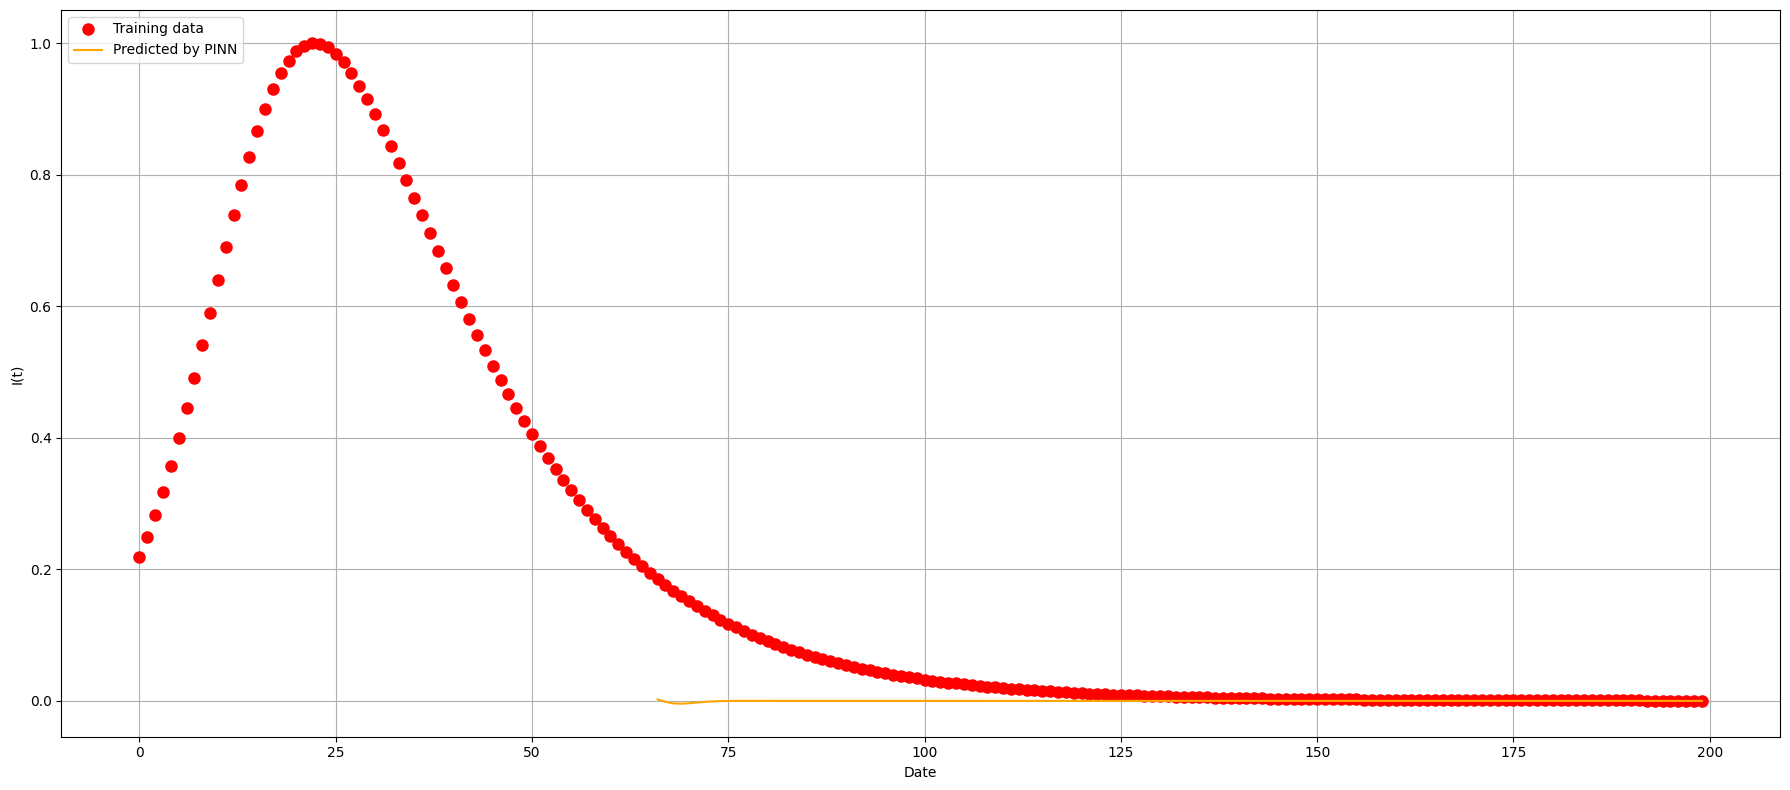

Epoch 1, MSE Loss = 6.467932689702138e-05, Average Loss = 0.045539088061639796


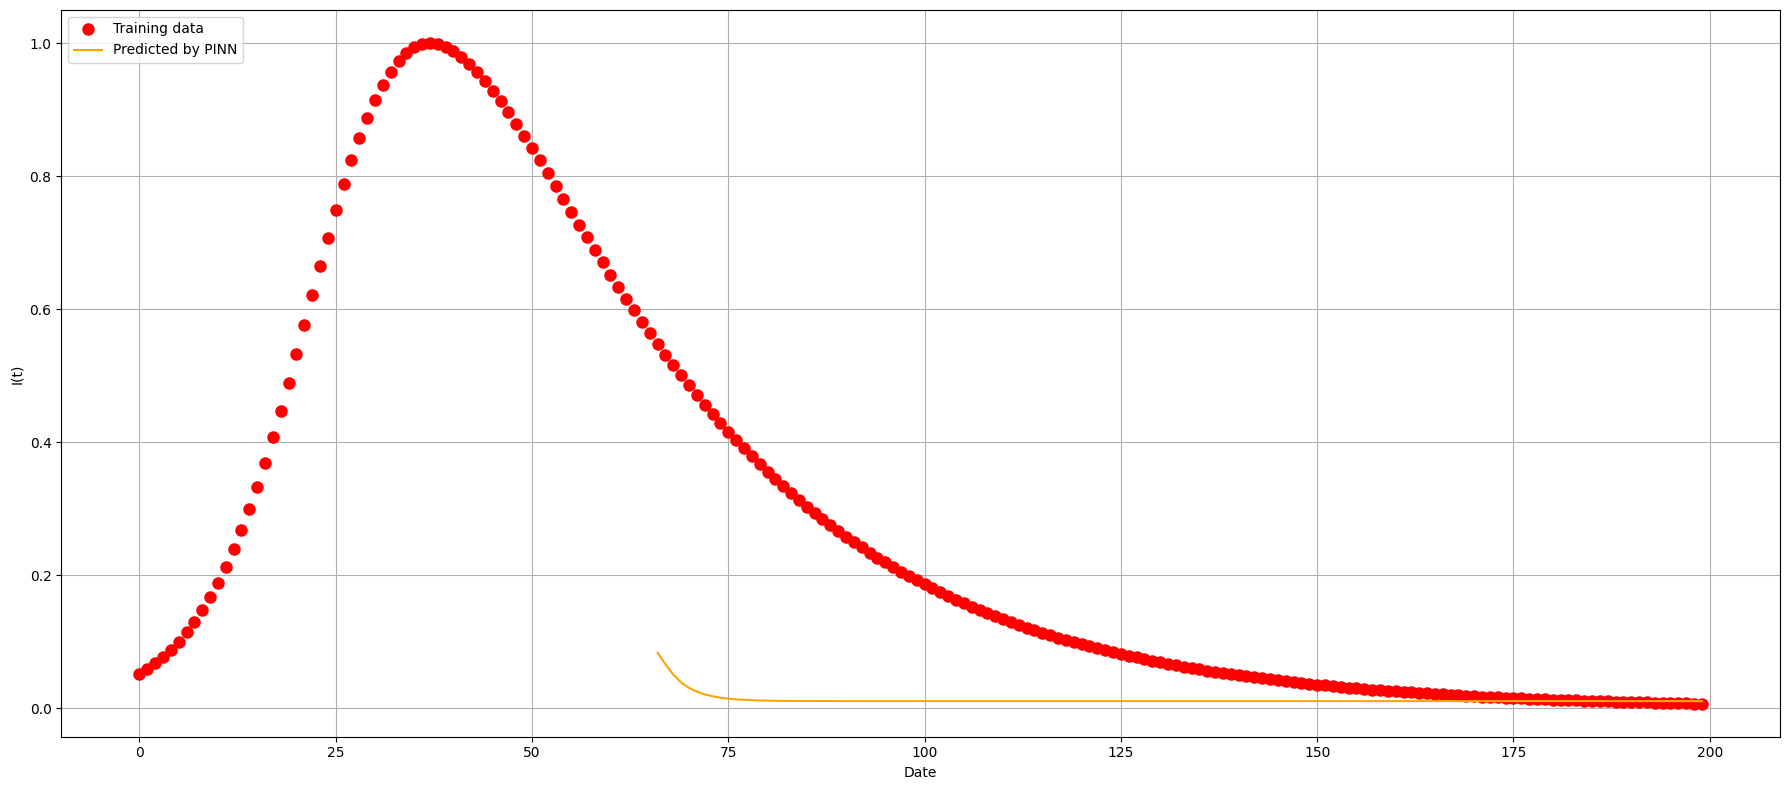

Epoch 1, MSE Loss = 1.3200309695093893e-05, Average Loss = 0.04587771909301102


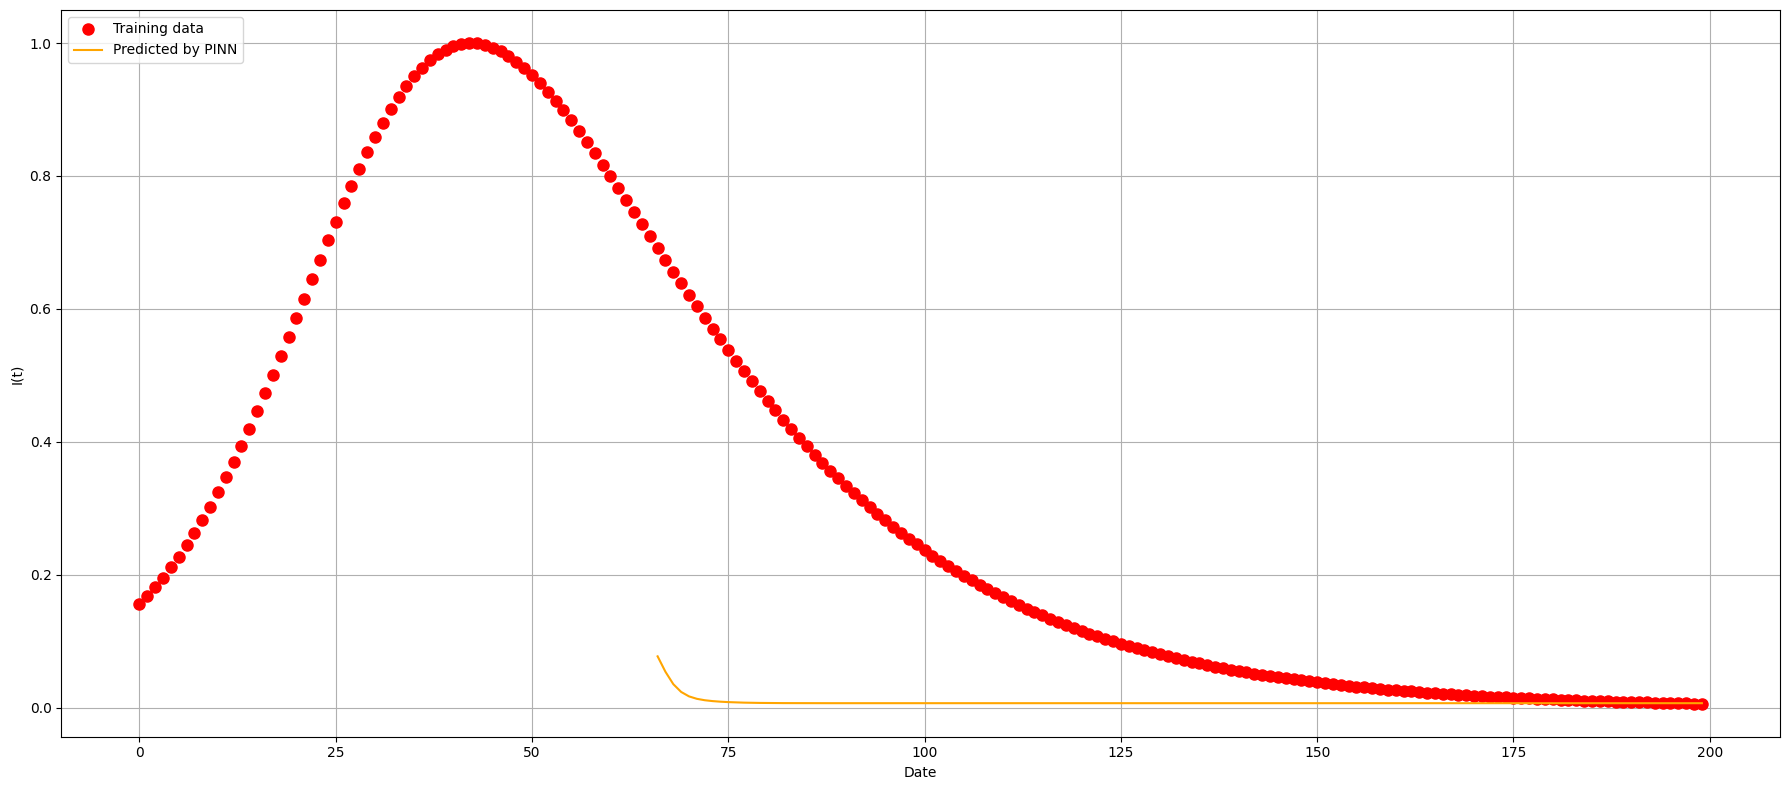

Epoch 1, MSE Loss = 4.949545200361172e-06, Average Loss = 0.048231739157048654


Epoch 1, MSE Loss = 0.0001935815525939688, Average Loss = 0.06974646547749515


Epoch 1, MSE Loss = 2.918953441621852e-06, Average Loss = 0.04949826482823944


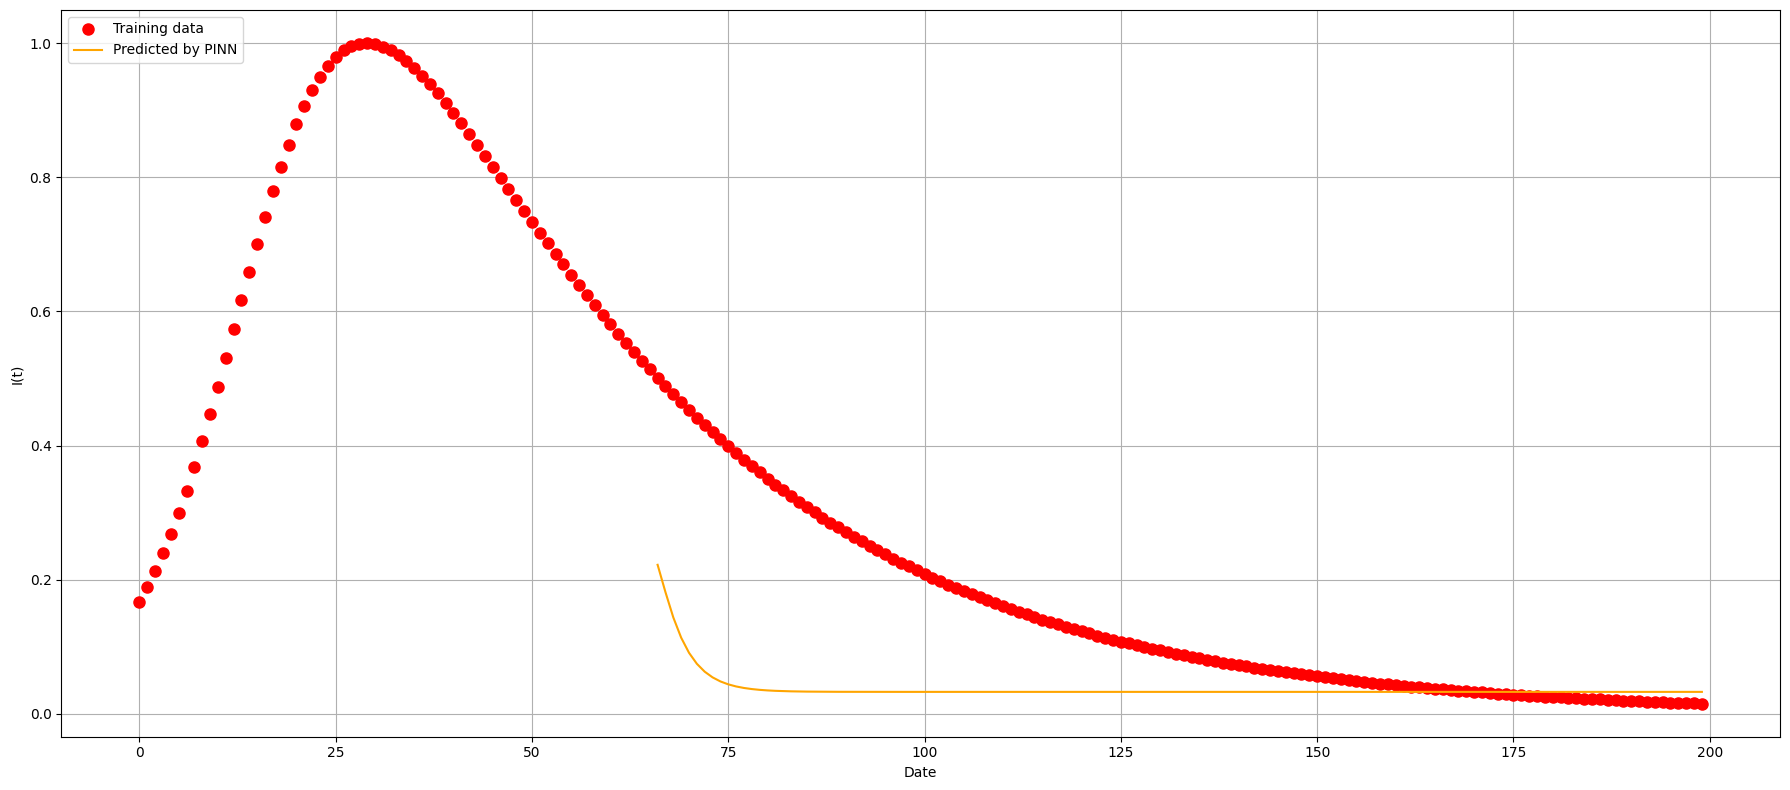

Epoch 1, MSE Loss = 0.00023173222143668681, Average Loss = 0.04624362179352815


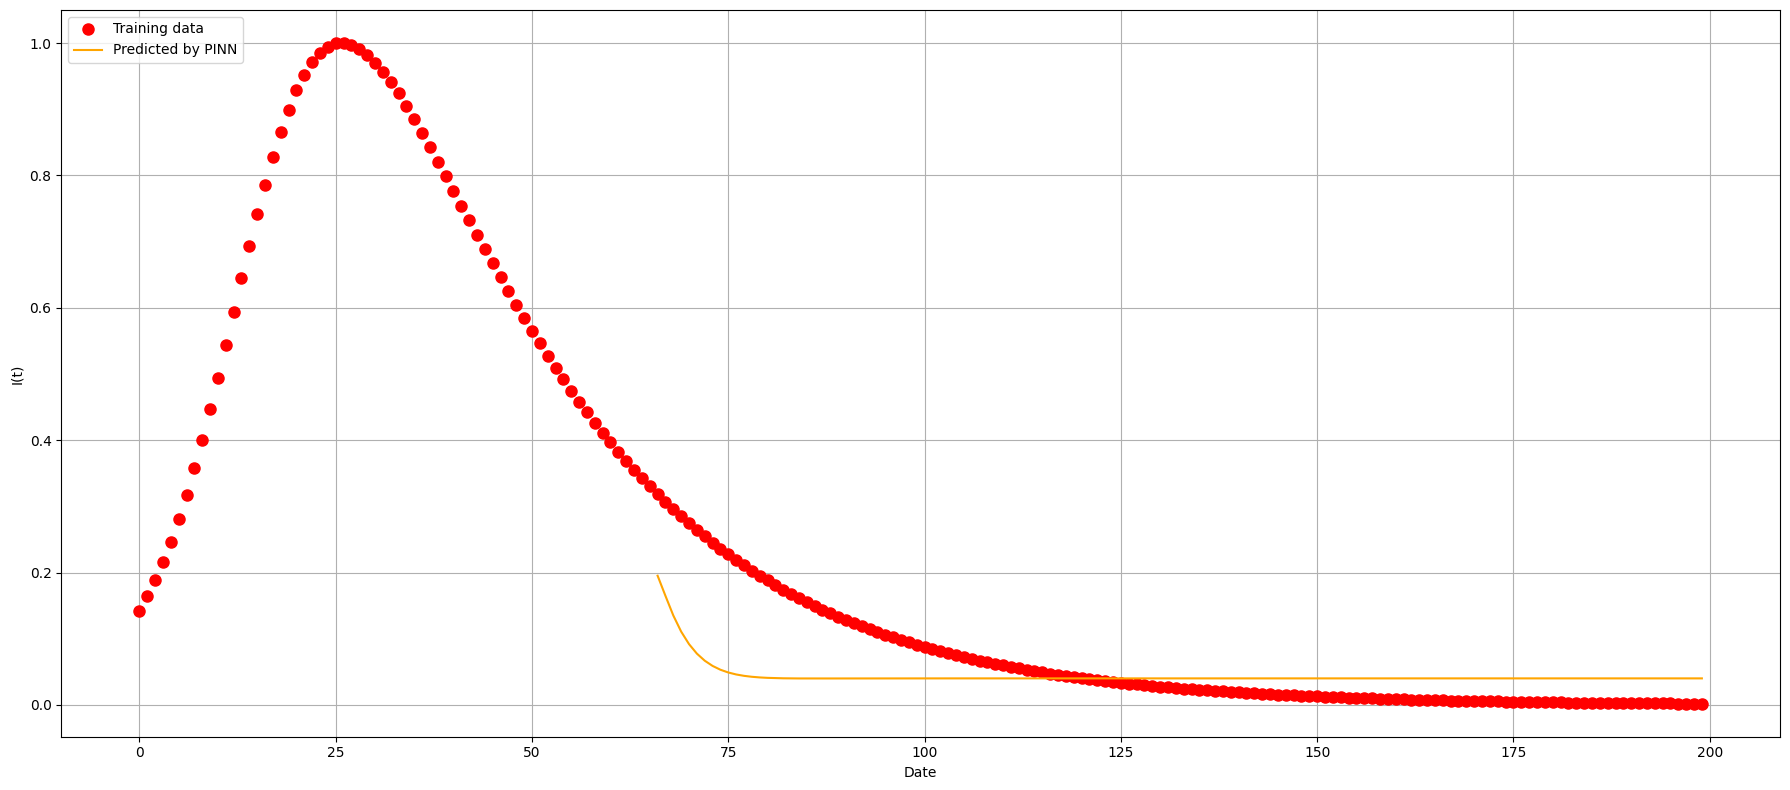

Epoch 1, MSE Loss = 3.676573760458268e-05, Average Loss = 0.03520054661289884


Epoch 1, MSE Loss = 4.6035694367674296e-07, Average Loss = 0.02599150749466046
Epoch 11, MSE Loss = 5.8965546486433595e-05, Average Loss = 0.0056172447390655115
Epoch 11, MSE Loss = 3.673166429507546e-05, Average Loss = 0.001347873174525767
Epoch 11, MSE Loss = 9.447670890949667e-05, Average Loss = 0.001191645088109924
Epoch 11, MSE Loss = 0.00016063566727098078, Average Loss = 0.0008547955068264754
Epoch 11, MSE Loss = 3.5233391827205196e-05, Average Loss = 0.0003595247754519988
Epoch 11, MSE Loss = 0.00013512265286408365, Average Loss = 0.003281000974451914
Epoch 11, MSE Loss = 2.192595275118947e-06, Average Loss = 0.0023947042138902906
Epoch 11, MSE Loss = 5.505344688572222e-06, Average Loss = 0.002041633819723517
Epoch 11, MSE Loss = 2.874262281693518e-05, Average Loss = 0.0005786482119096794
Epoch 11, MSE Loss = 6.345758265524637e-07, Average Loss = 0.0049623288930983845
Epoch 21, MSE Loss = 9.160662983731527e-08, Average Loss = 0.0021198915230178626
Epoch 21, MSE Loss = 1.0594739

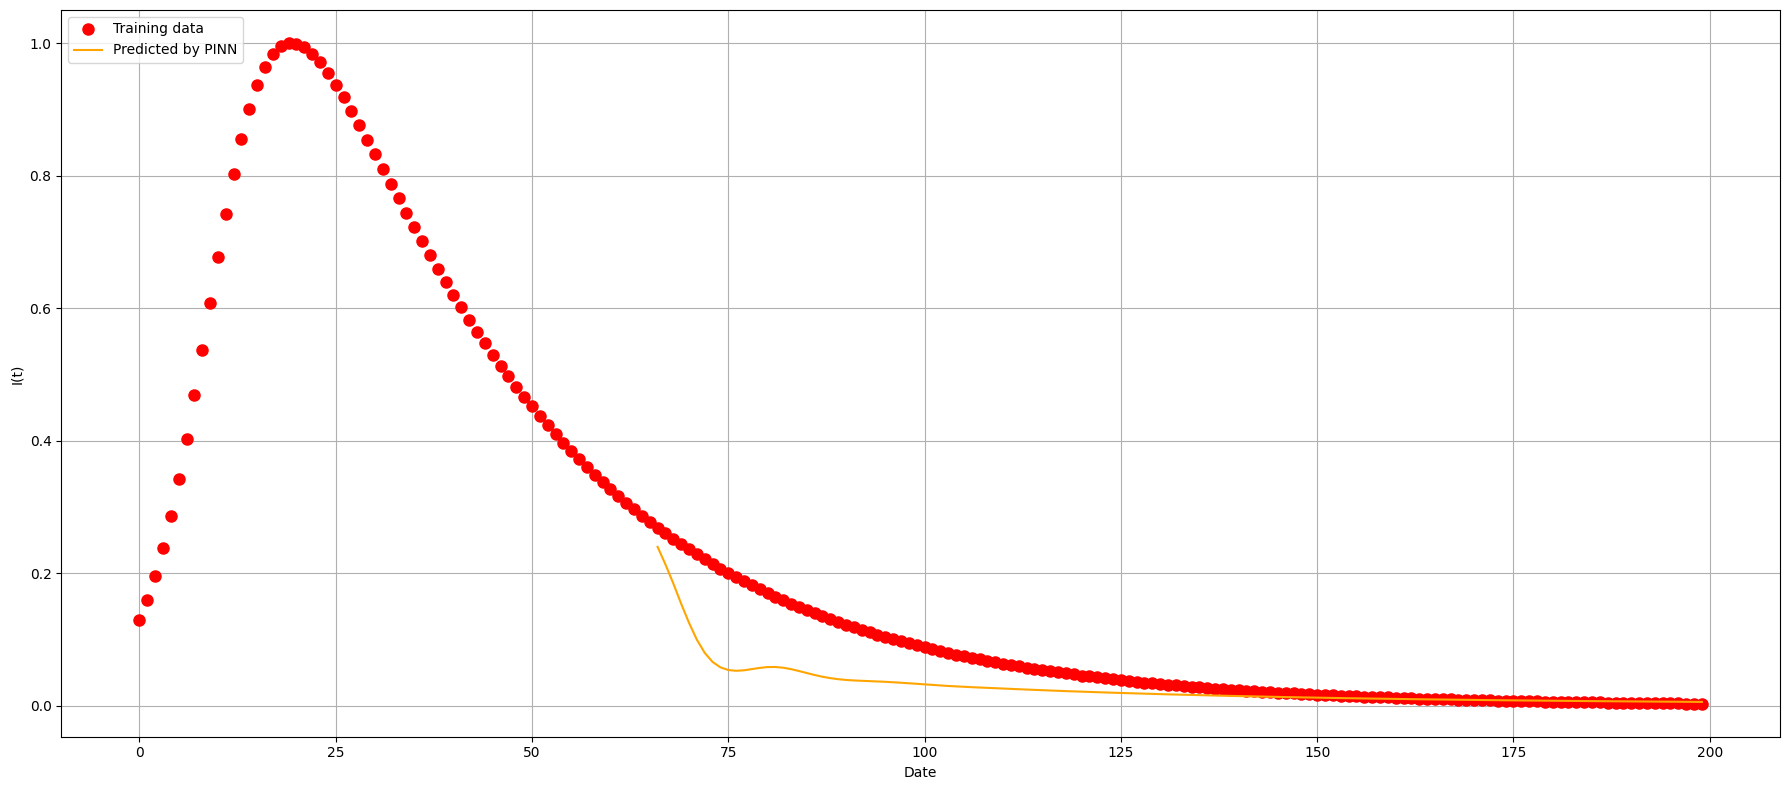

Epoch 41, MSE Loss = 4.106672690795676e-08, Average Loss = 0.000981719159877595


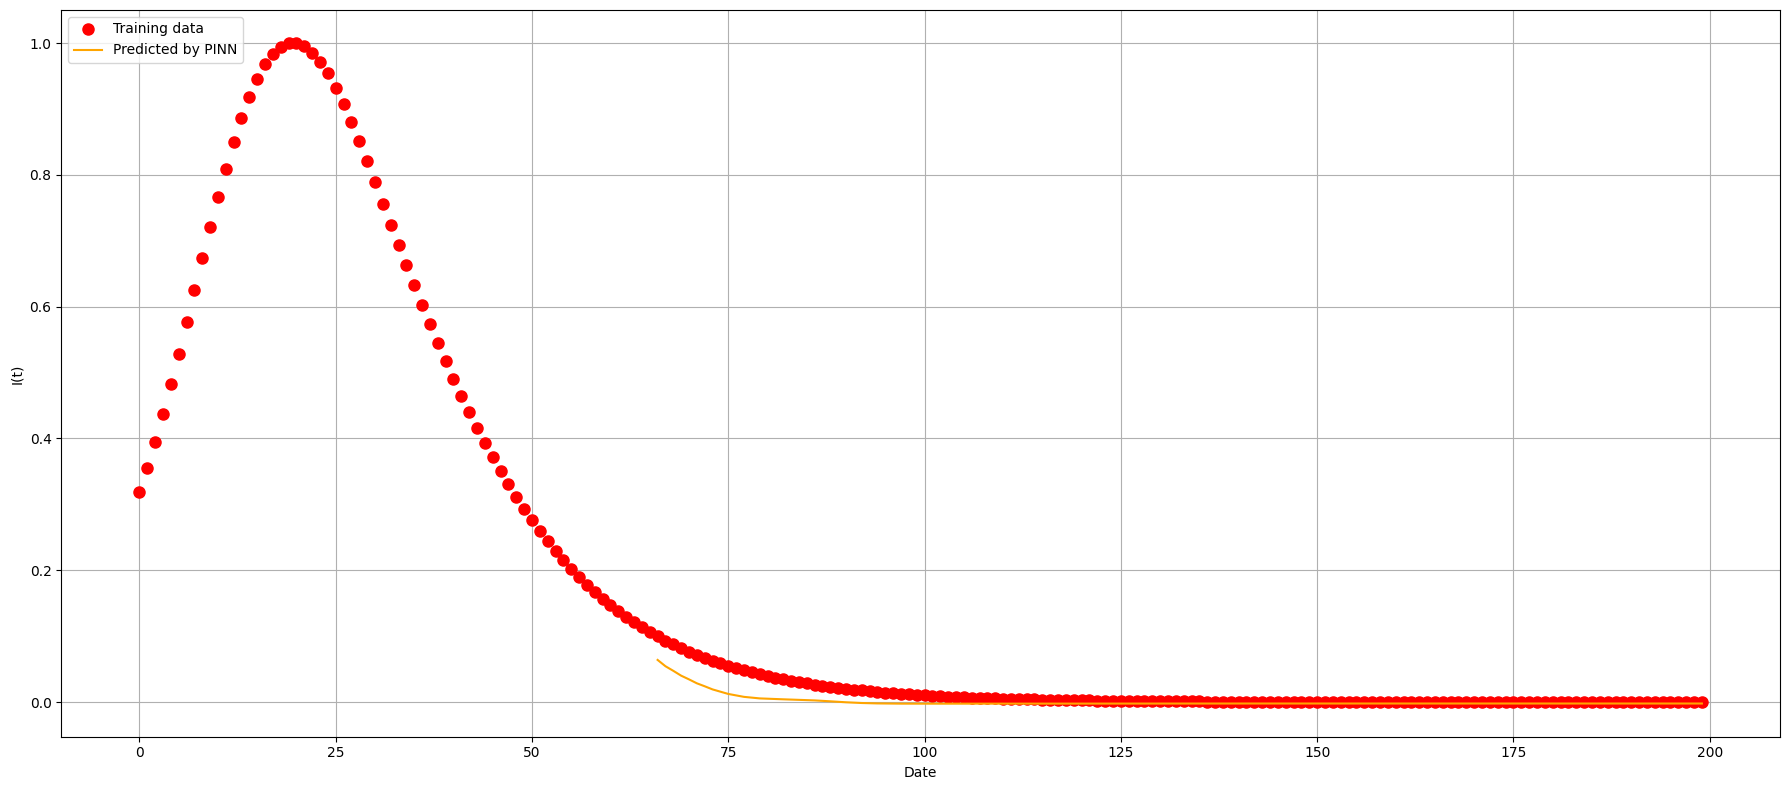

Epoch 41, MSE Loss = 1.1056285984523129e-05, Average Loss = 0.0010180046373139335


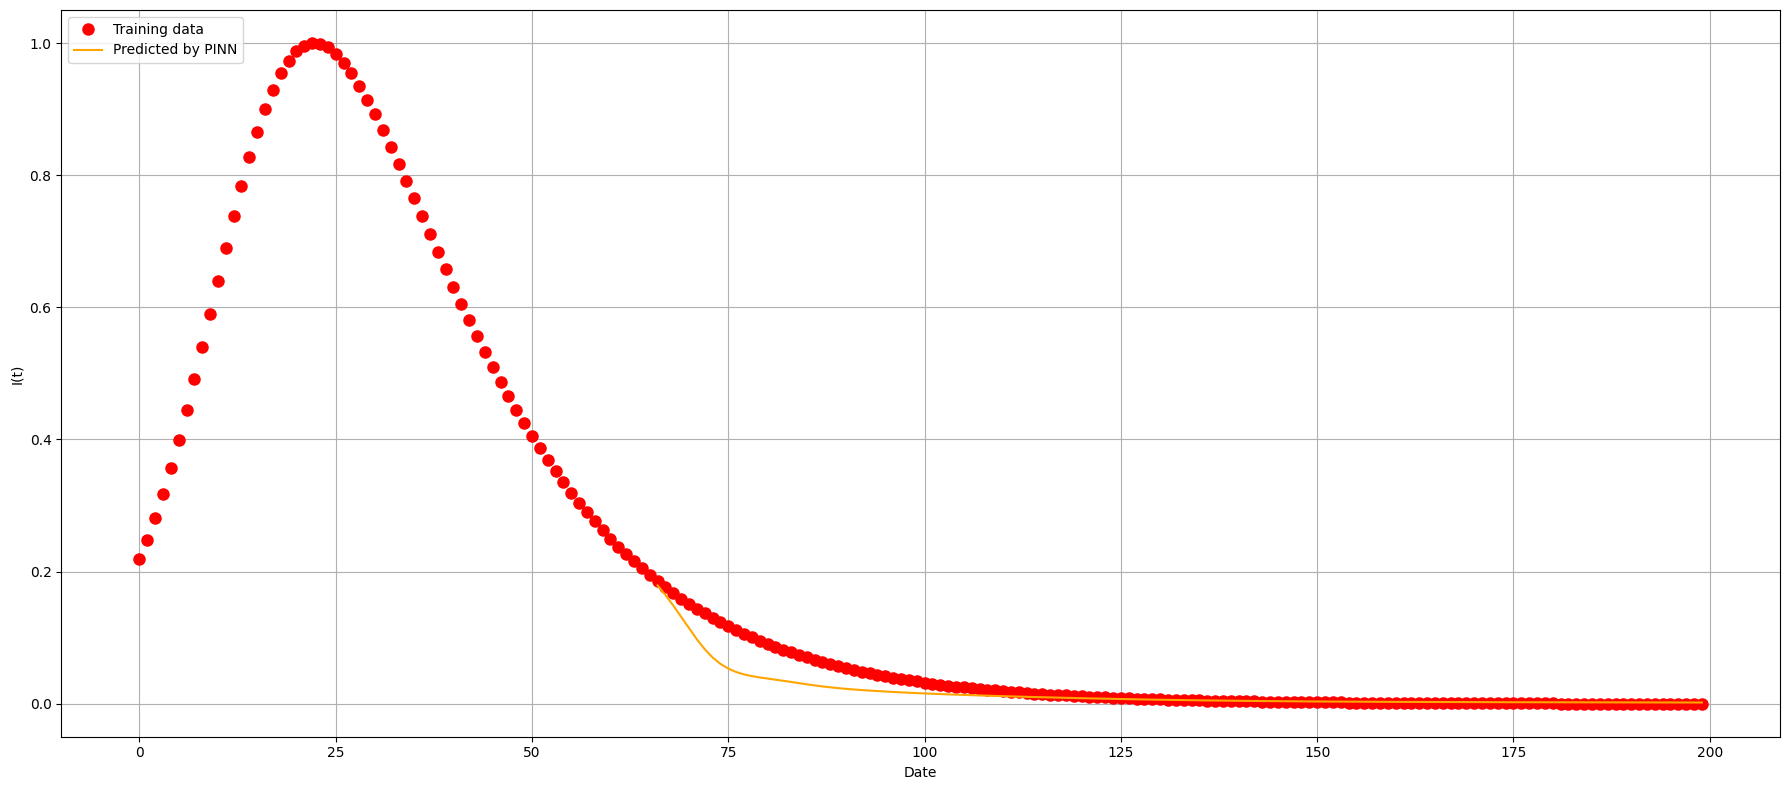

Epoch 41, MSE Loss = 1.87028508662479e-05, Average Loss = 0.00025555074572082434


Epoch 41, MSE Loss = 1.4085355815041112e-06, Average Loss = 0.00045573540208915556


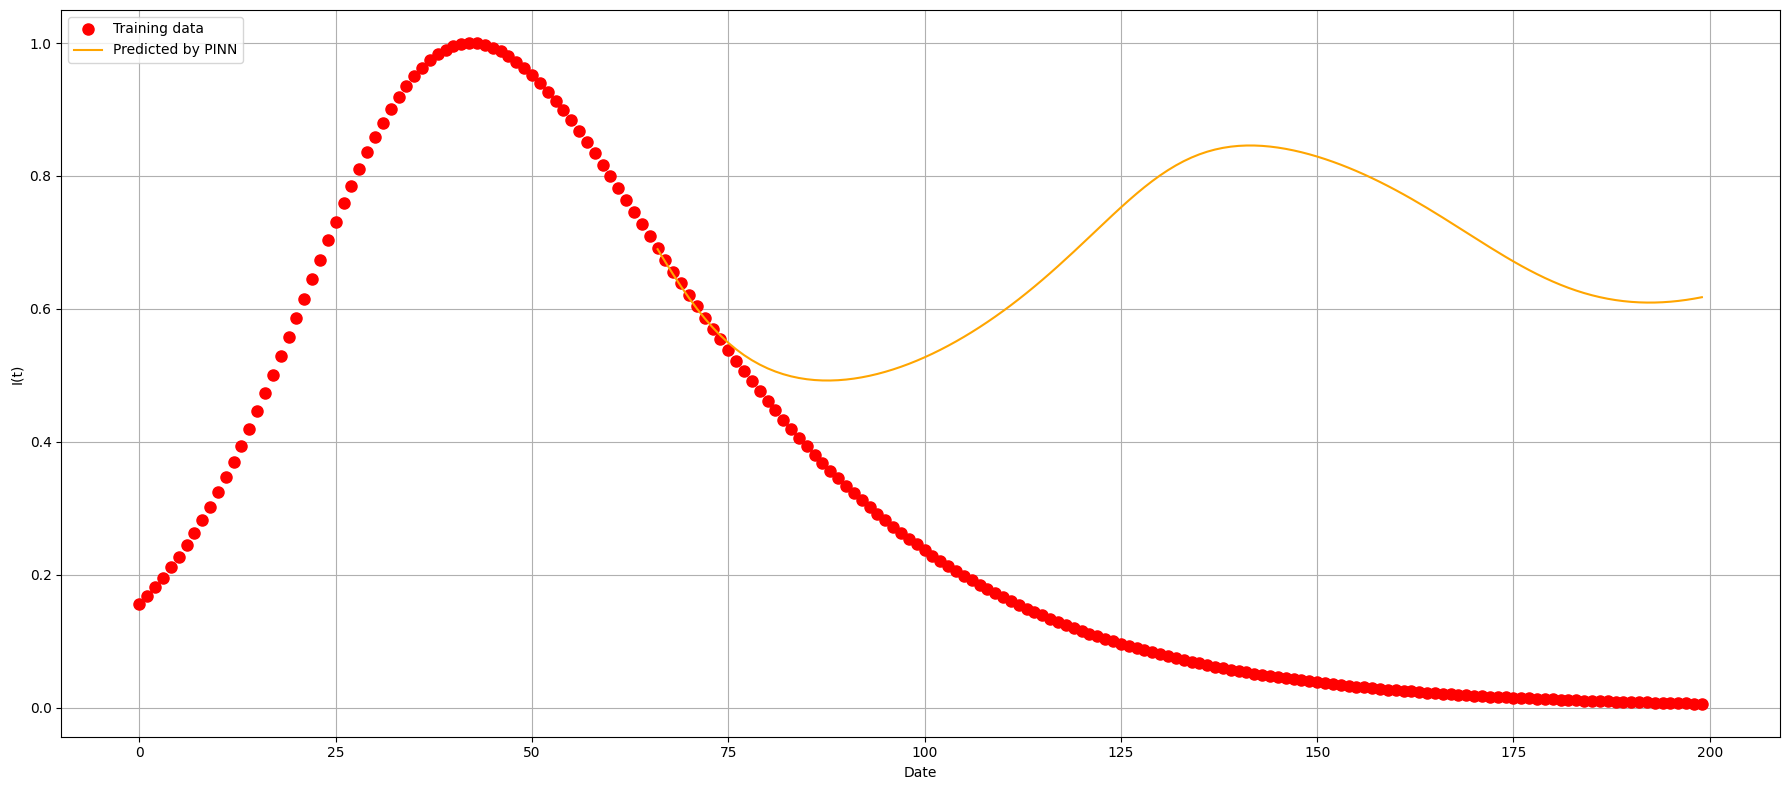

Epoch 41, MSE Loss = 2.00973386199621e-06, Average Loss = 6.500029538222403e-05


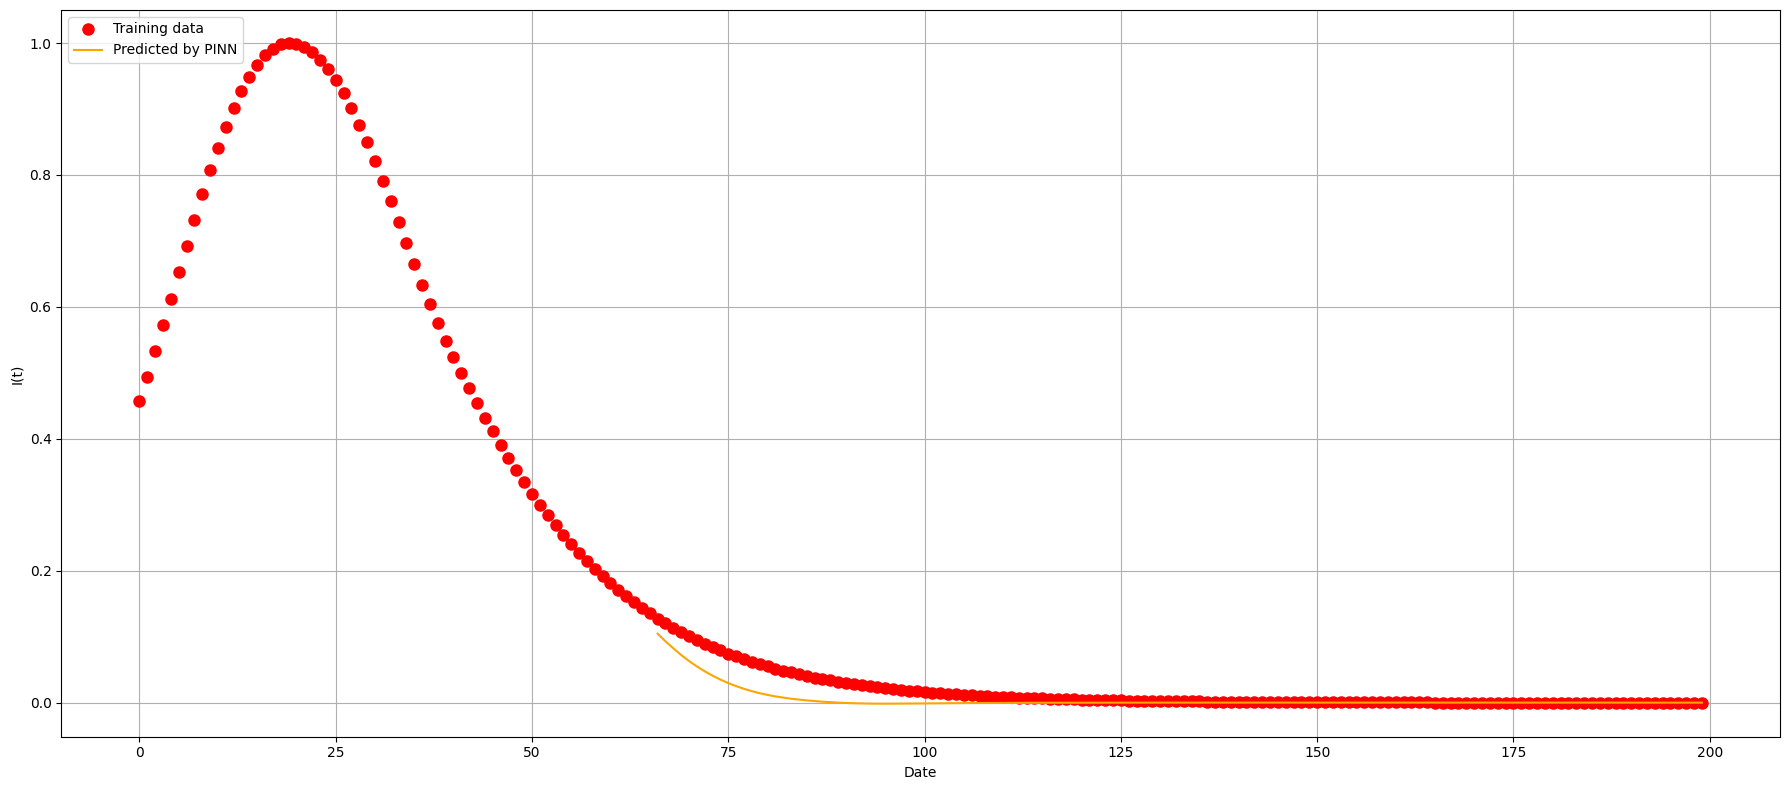

Epoch 41, MSE Loss = 6.4145794453907e-08, Average Loss = 0.00012212045829209156


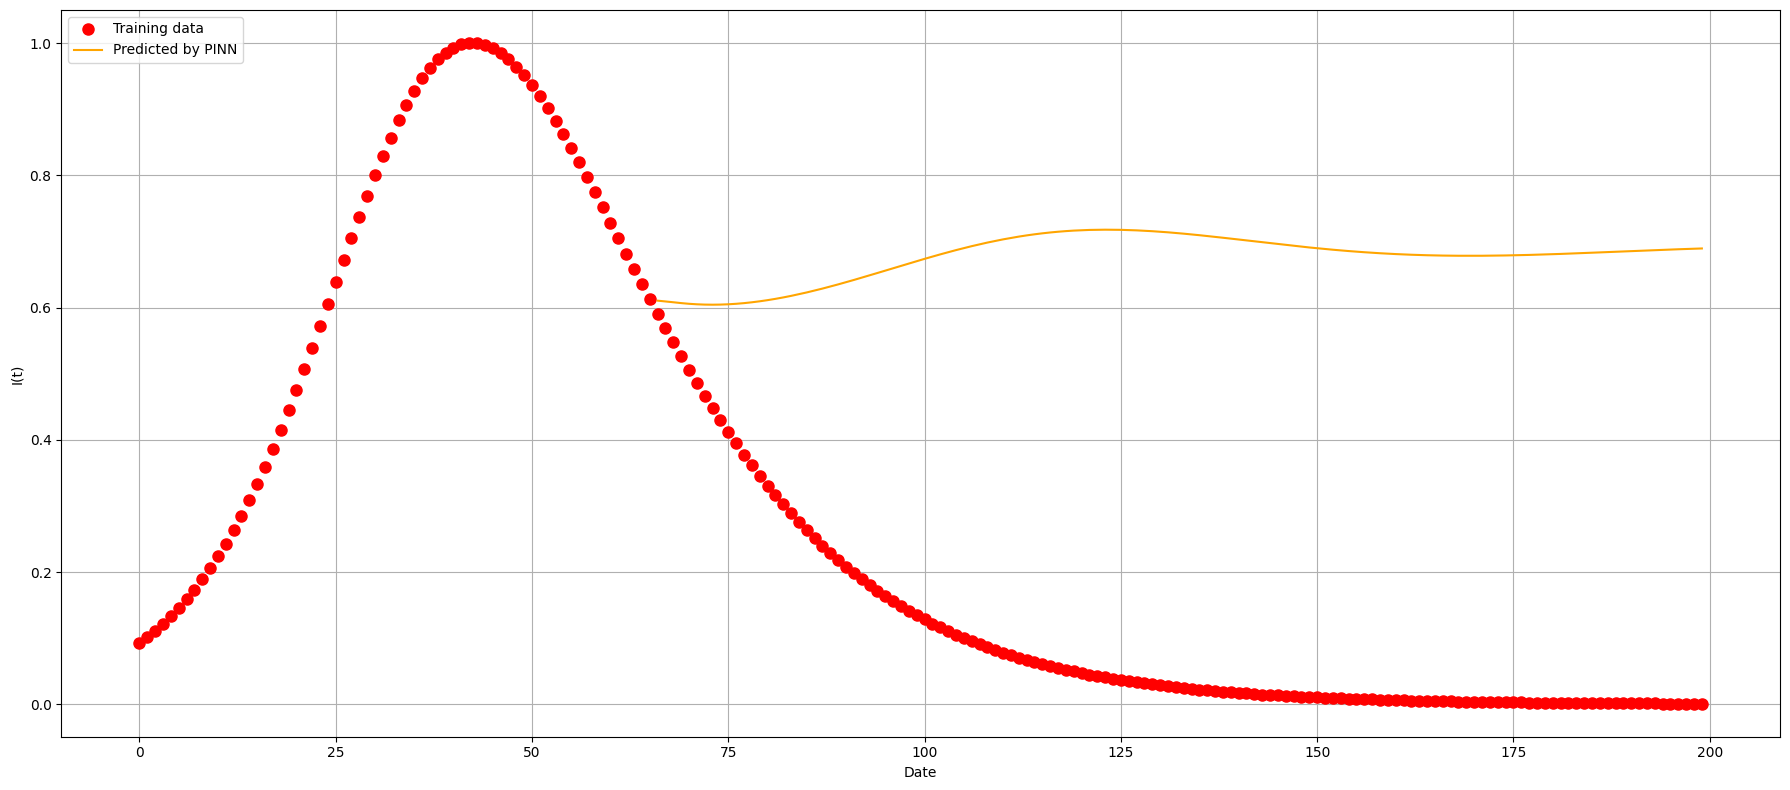

Epoch 41, MSE Loss = 4.576114918108942e-07, Average Loss = 0.0001143795154141674


Epoch 41, MSE Loss = 3.7316024759093125e-07, Average Loss = 0.00012080103316471994


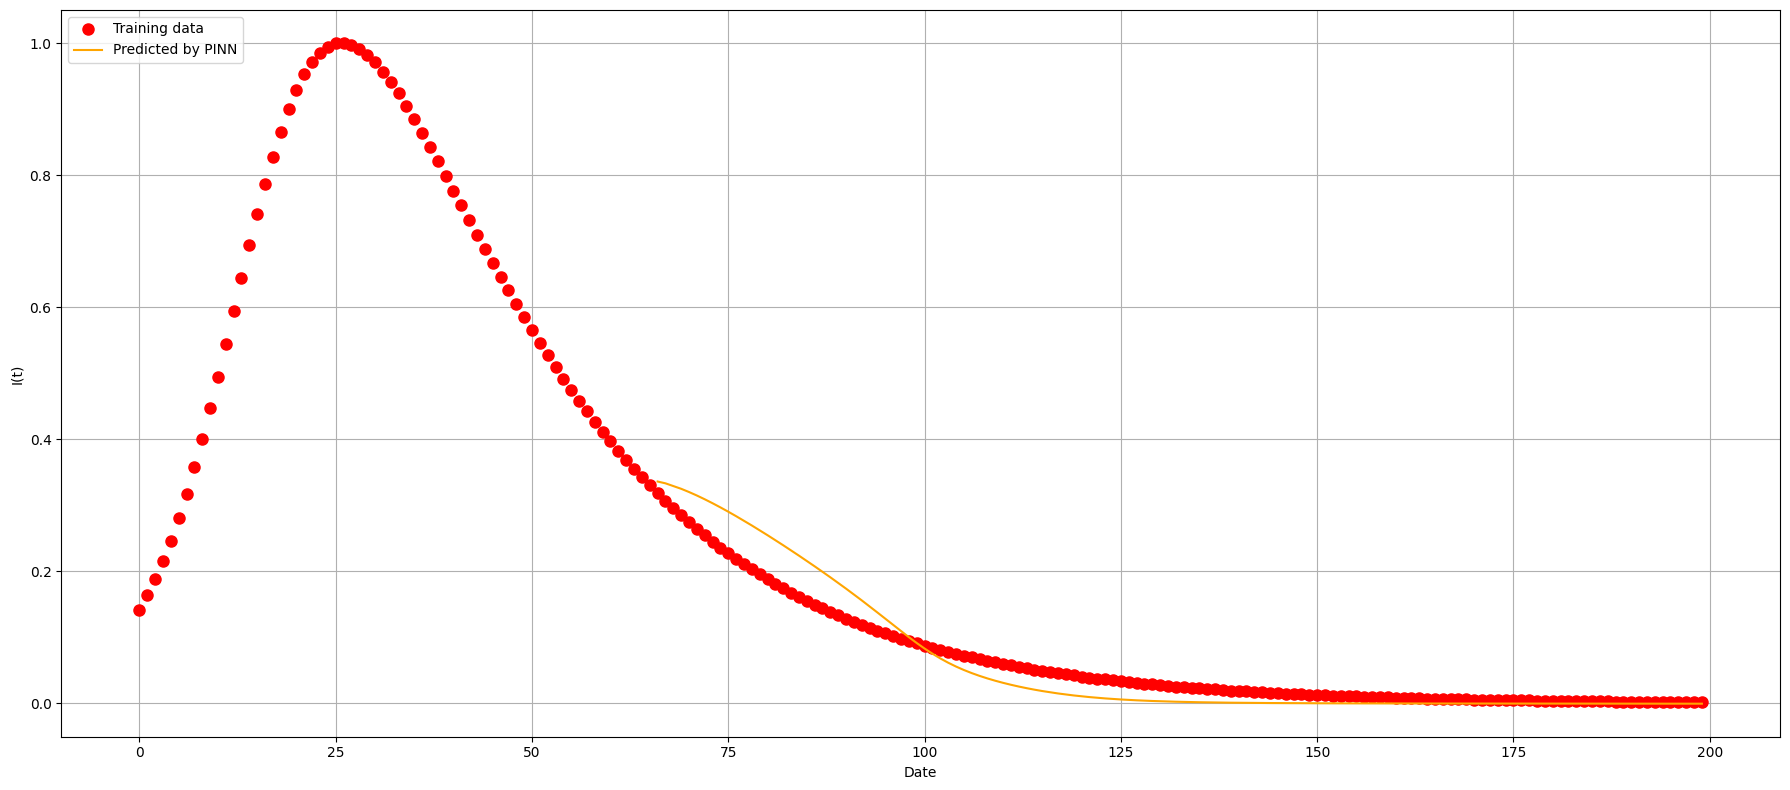

Epoch 41, MSE Loss = 8.75879067052665e-08, Average Loss = 9.073515129423775e-05


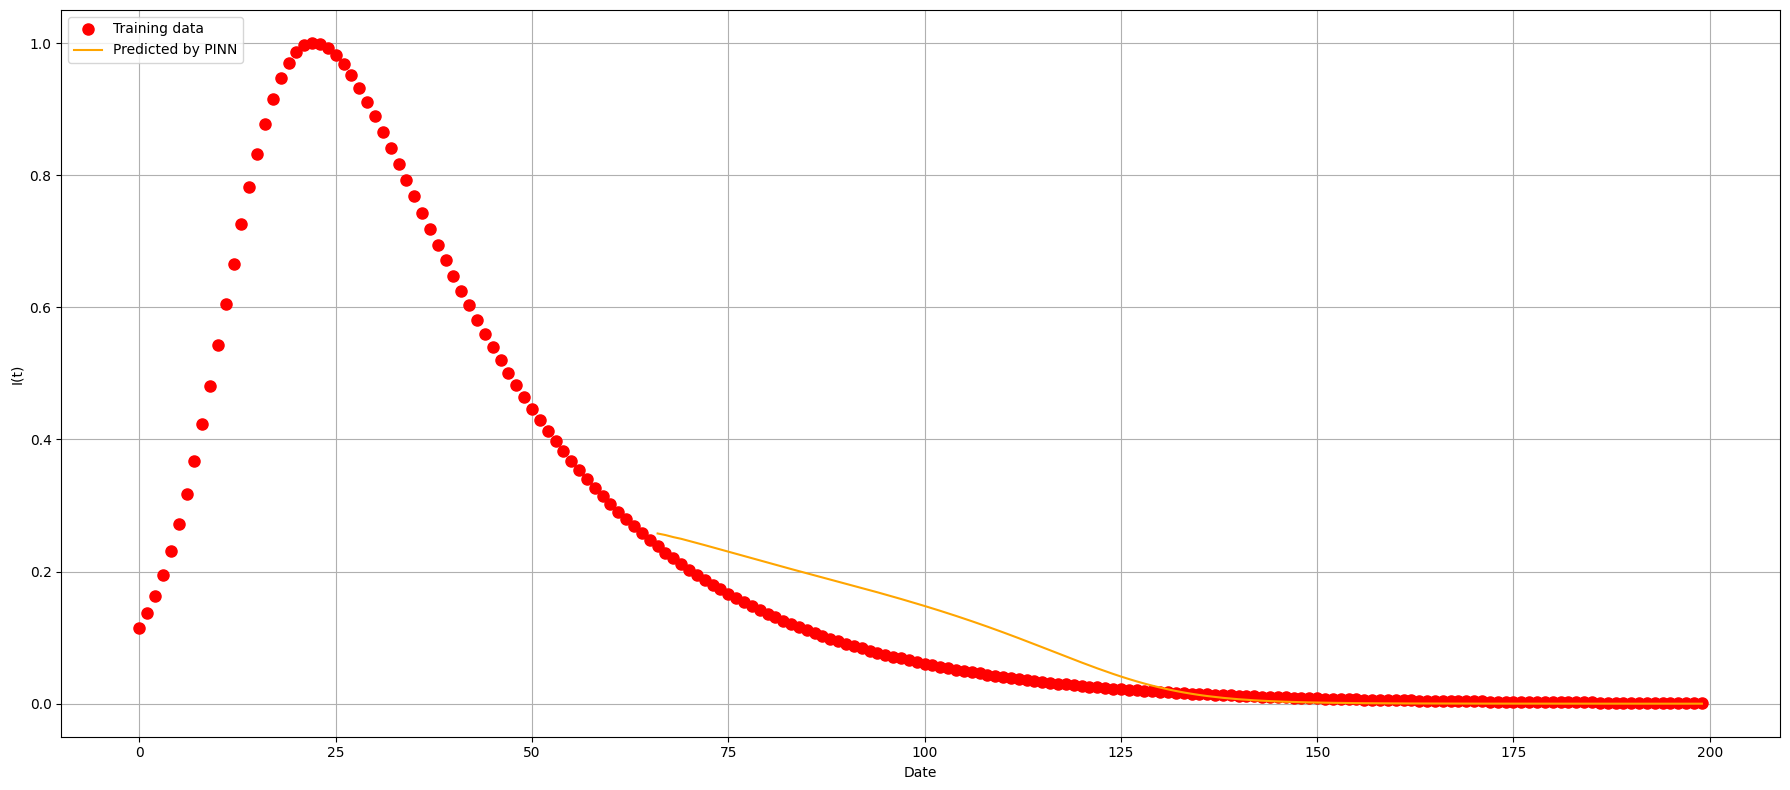

Epoch 41, MSE Loss = 1.116849307436496e-05, Average Loss = 8.748941260559057e-05
Epoch 51, MSE Loss = 6.18284957454307e-07, Average Loss = 0.002837435287886608
Epoch 51, MSE Loss = 1.4688700503029395e-05, Average Loss = 0.00036053721311170777
Epoch 51, MSE Loss = 3.435097823967226e-07, Average Loss = 0.00034258211689319046
Epoch 51, MSE Loss = 7.763512257952243e-06, Average Loss = 0.00018488774035347198
Epoch 51, MSE Loss = 4.132770300202537e-06, Average Loss = 9.221036217955538e-05
Epoch 51, MSE Loss = 6.302050223894184e-07, Average Loss = 6.494014242645065e-05
Epoch 51, MSE Loss = 6.132905241429398e-07, Average Loss = 0.00010718420338280364
Epoch 51, MSE Loss = 4.3400588765507564e-05, Average Loss = 0.0003188512786476599
Epoch 51, MSE Loss = 1.3436684653811426e-08, Average Loss = 0.0003323158751283568
Epoch 51, MSE Loss = 1.1624815670074895e-05, Average Loss = 6.033894545413038e-05
Epoch 61, MSE Loss = 1.7630881643526664e-07, Average Loss = 0.00035065087931073814
Epoch 61, MSE Loss =

Epoch 81, MSE Loss = 9.069829047803069e-07, Average Loss = 0.00016705011798734865


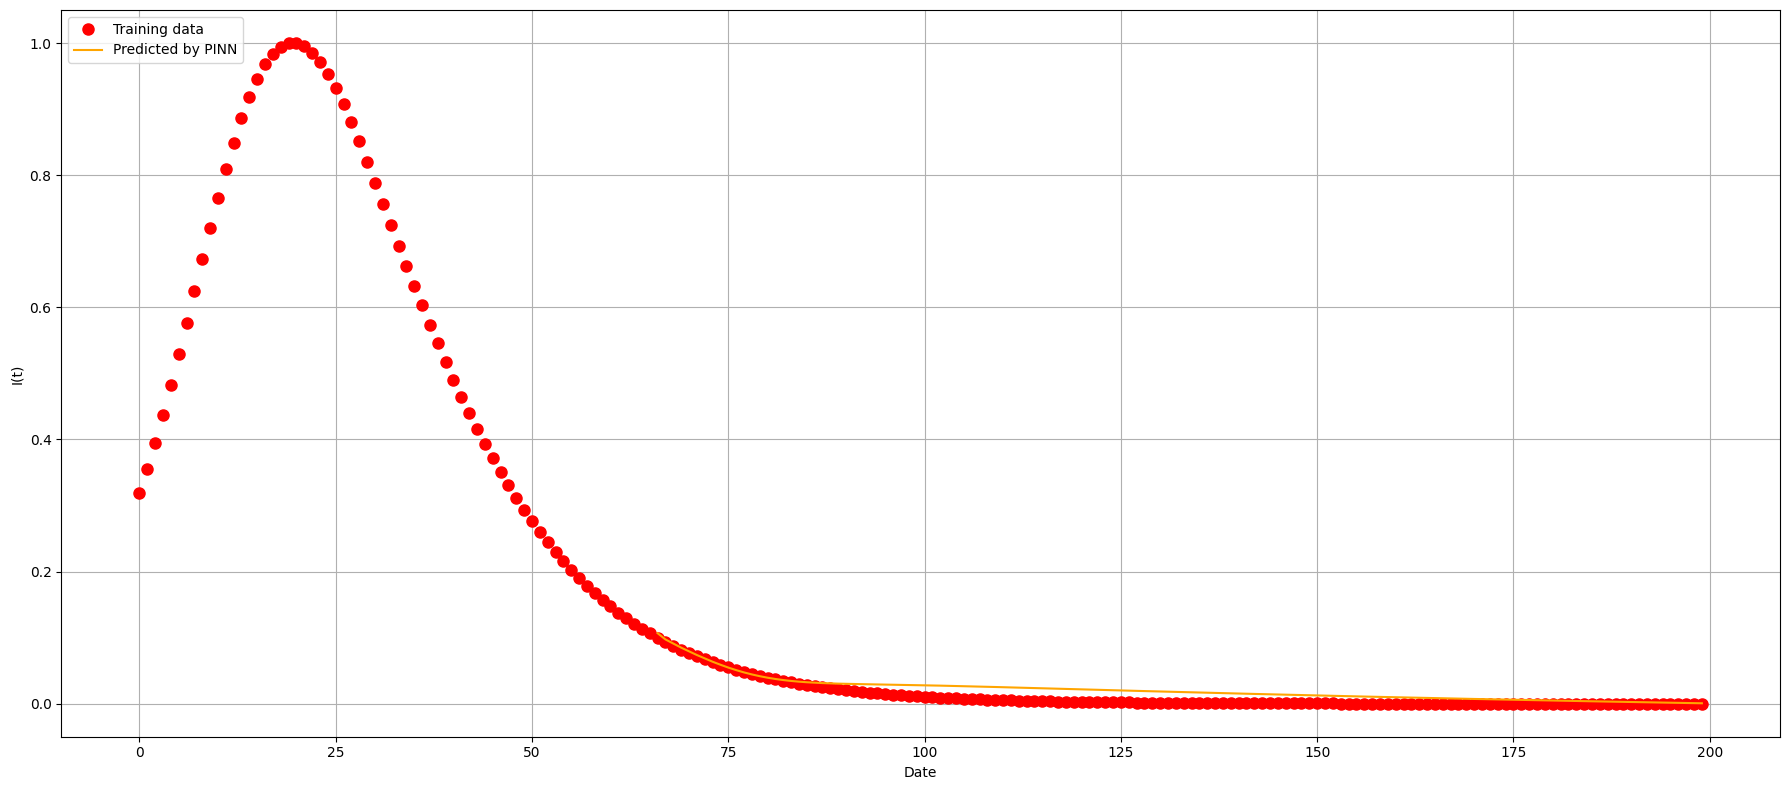

Epoch 81, MSE Loss = 8.136084375109931e-07, Average Loss = 0.0005226621444731168


Epoch 81, MSE Loss = 1.1704436531090323e-08, Average Loss = 0.0001829388736944358


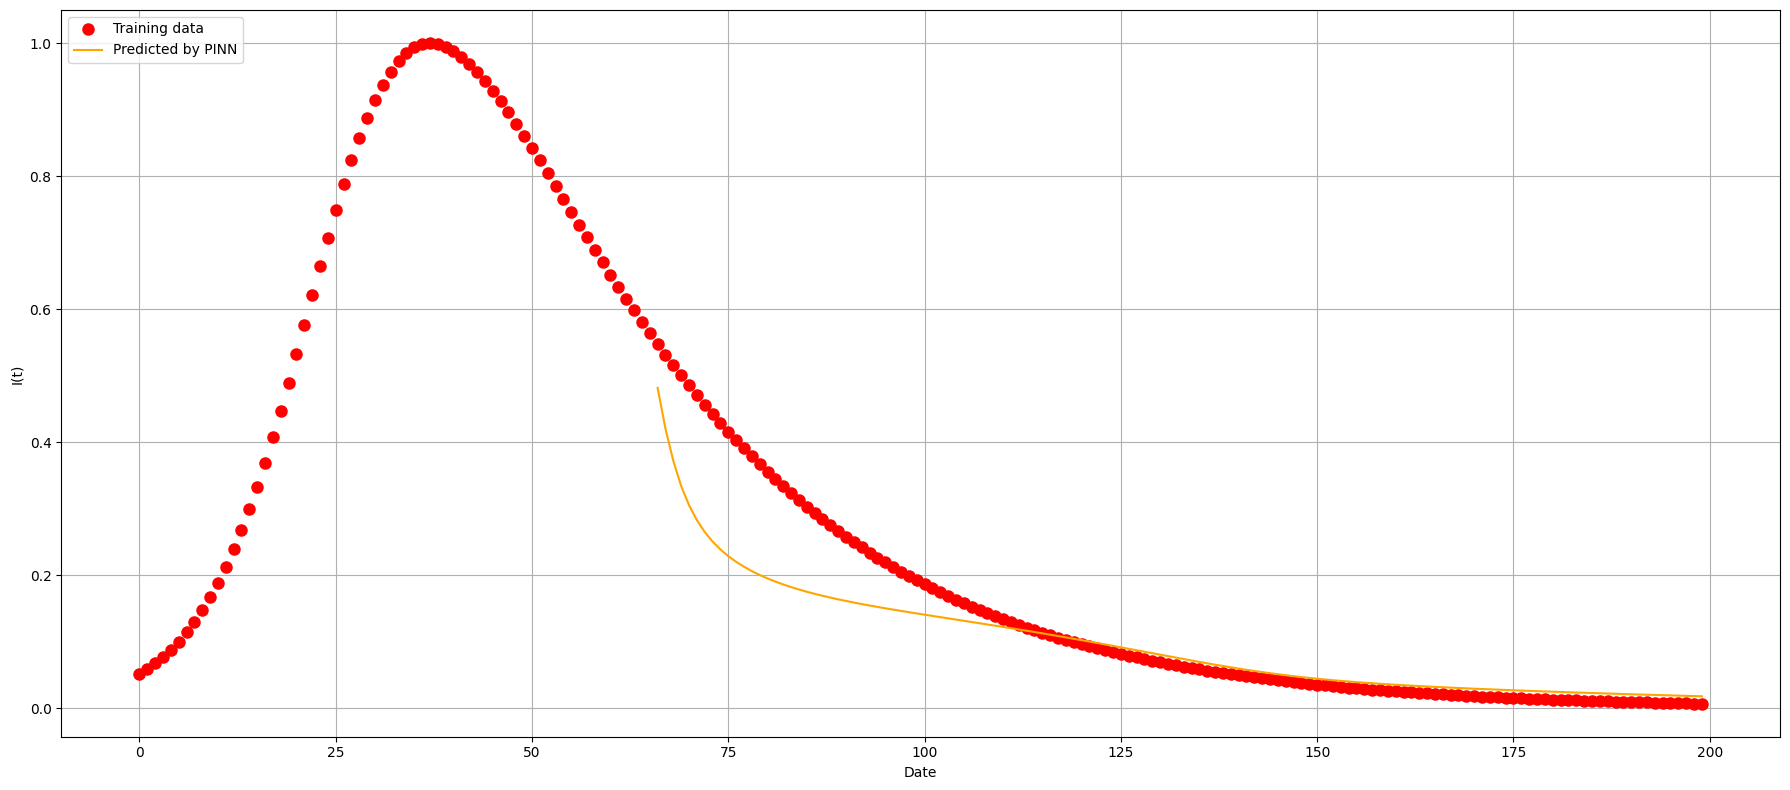

Epoch 81, MSE Loss = 1.1151257240271661e-05, Average Loss = 8.532837127910819e-05


Epoch 81, MSE Loss = 7.322958481381647e-06, Average Loss = 0.0001924576523702641


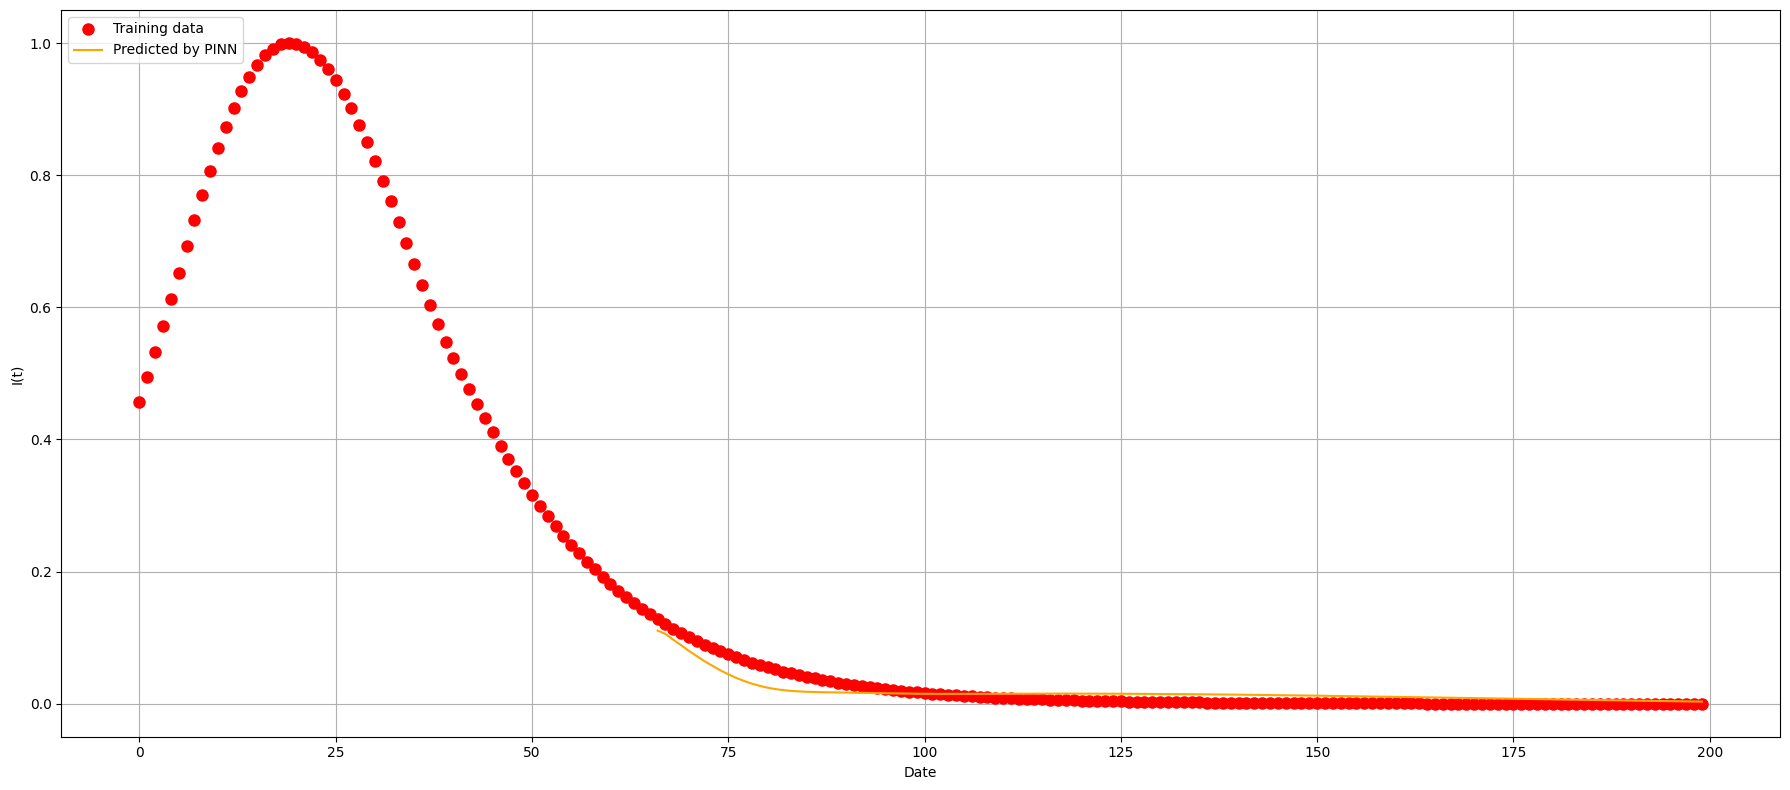

Epoch 81, MSE Loss = 2.154187086489401e-06, Average Loss = 0.00013190528324285702


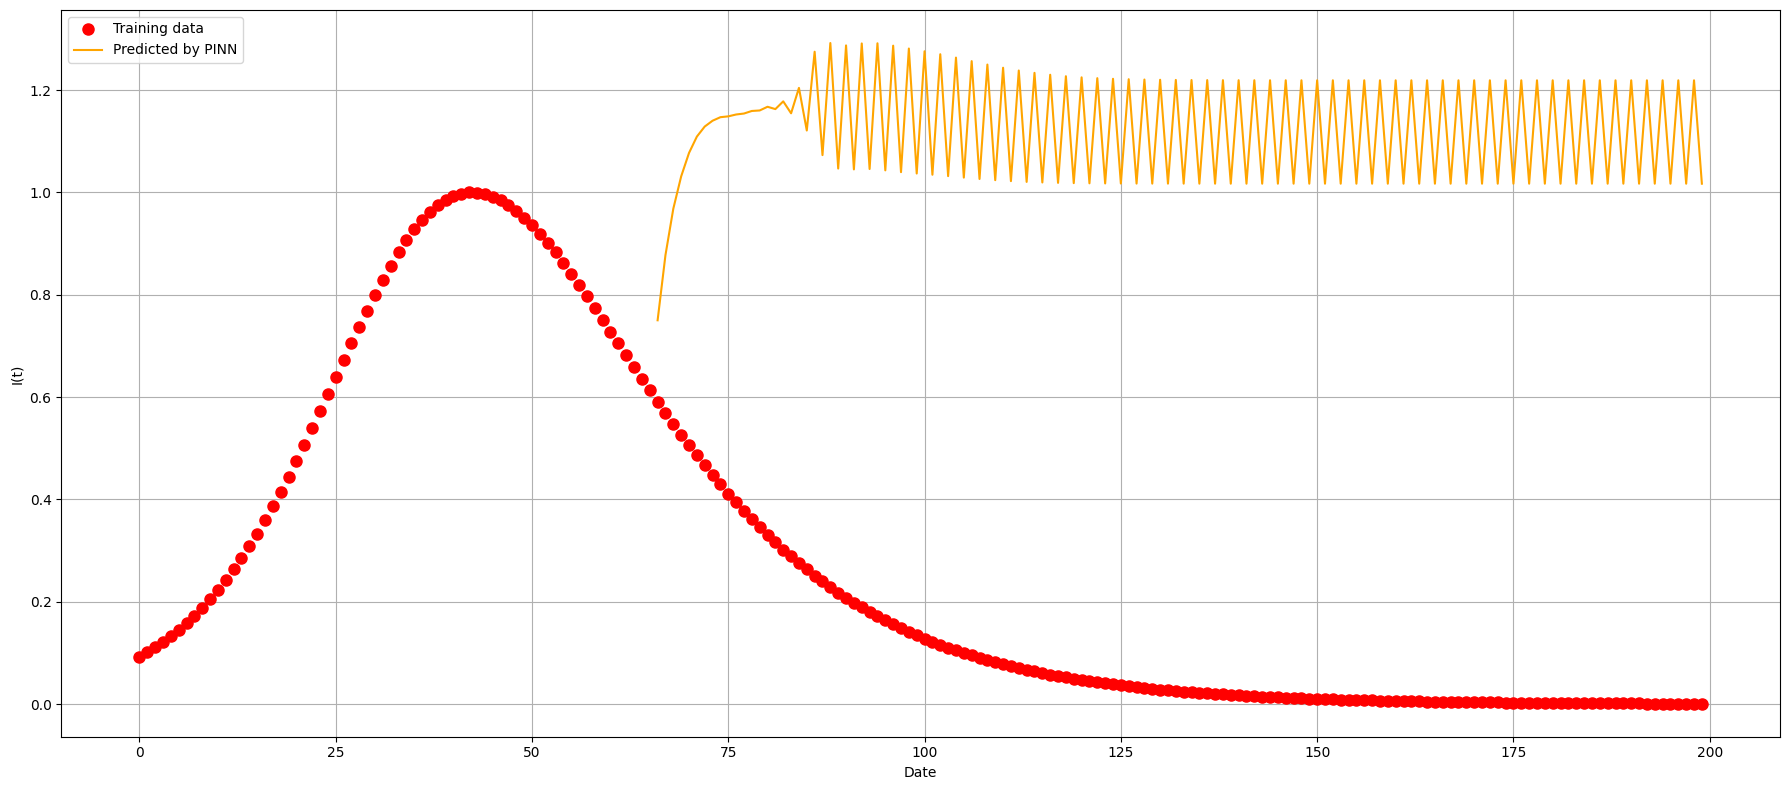

Epoch 81, MSE Loss = 2.0810823116335087e-05, Average Loss = 0.0004609497046657127


Epoch 81, MSE Loss = 8.831523700791877e-06, Average Loss = 0.00038175524599264797


Epoch 81, MSE Loss = 3.3101671306212666e-06, Average Loss = 0.0001867066977674071


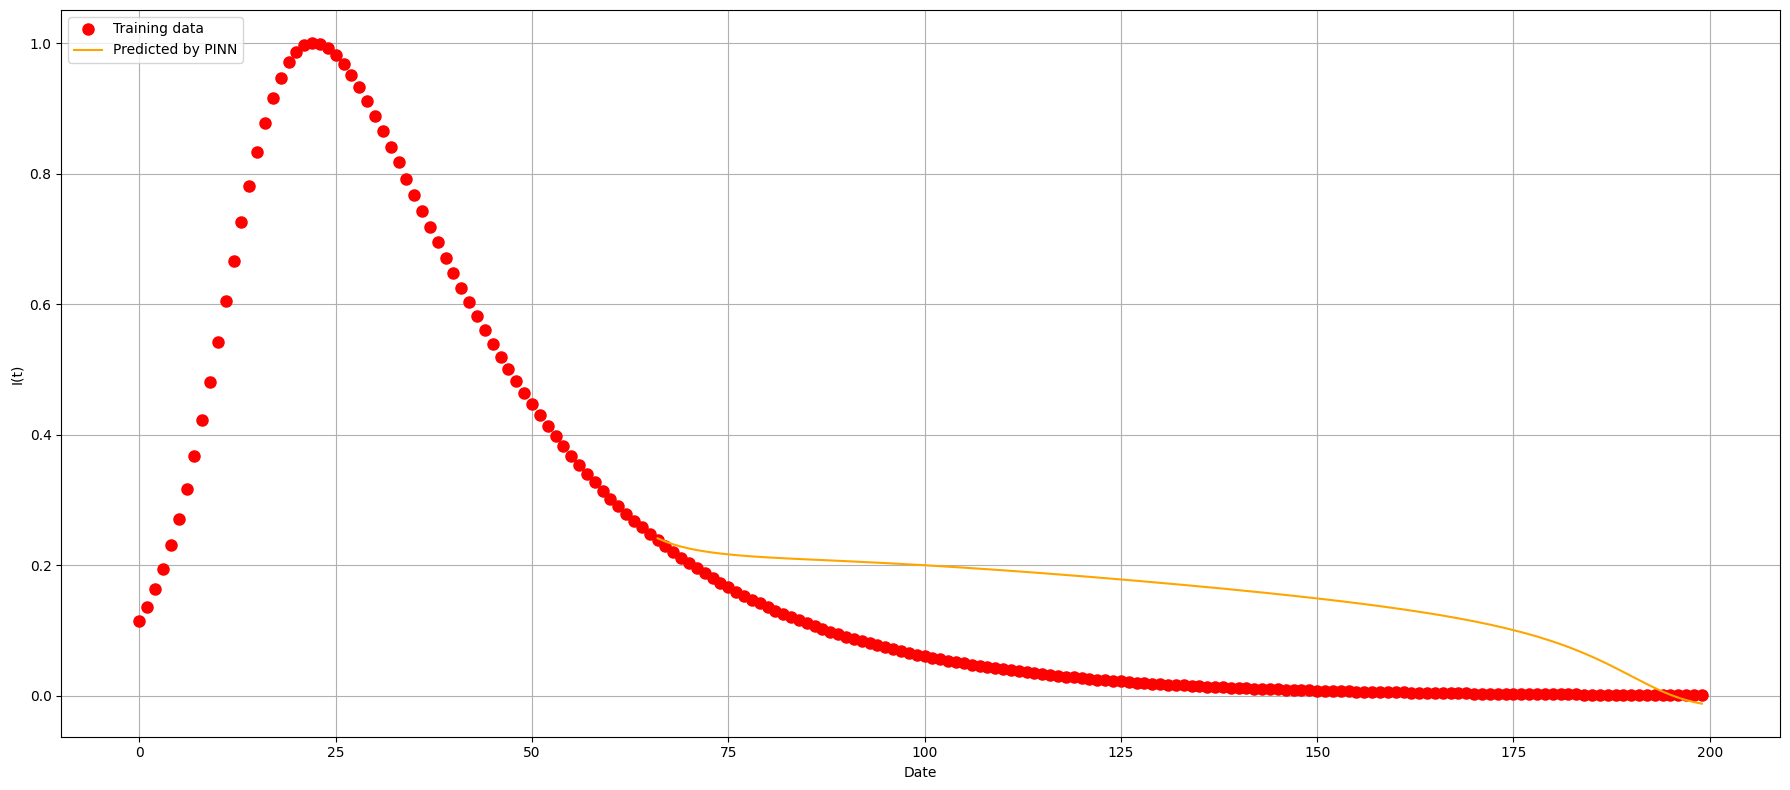

Epoch 81, MSE Loss = 2.707732164708432e-06, Average Loss = 0.0018202329868522115
Epoch 91, MSE Loss = 6.404136456694687e-07, Average Loss = 0.0011417323062300501
Epoch 91, MSE Loss = 4.533711489784764e-06, Average Loss = 0.00035863015909397755
Epoch 91, MSE Loss = 1.5683768879171112e-06, Average Loss = 9.587550076454183e-05
Epoch 91, MSE Loss = 3.819078847300261e-05, Average Loss = 0.00024953719054993134
Epoch 91, MSE Loss = 1.8517440594223444e-06, Average Loss = 6.109469810676571e-05
Epoch 91, MSE Loss = 3.872853085340466e-06, Average Loss = 4.22452089337441e-05
Epoch 91, MSE Loss = 2.4414655854343437e-05, Average Loss = 6.237932798789668e-05
Epoch 91, MSE Loss = 3.02477965306025e-05, Average Loss = 0.0001457739788669252
Epoch 91, MSE Loss = 4.249539415468462e-06, Average Loss = 0.00017840410756180994
Epoch 91, MSE Loss = 5.08506730056979e-07, Average Loss = 4.17230091927414e-05
Epoch 101, MSE Loss = 2.1019694429469382e-07, Average Loss = 0.00012209117354684406
Epoch 101, MSE Loss = 2

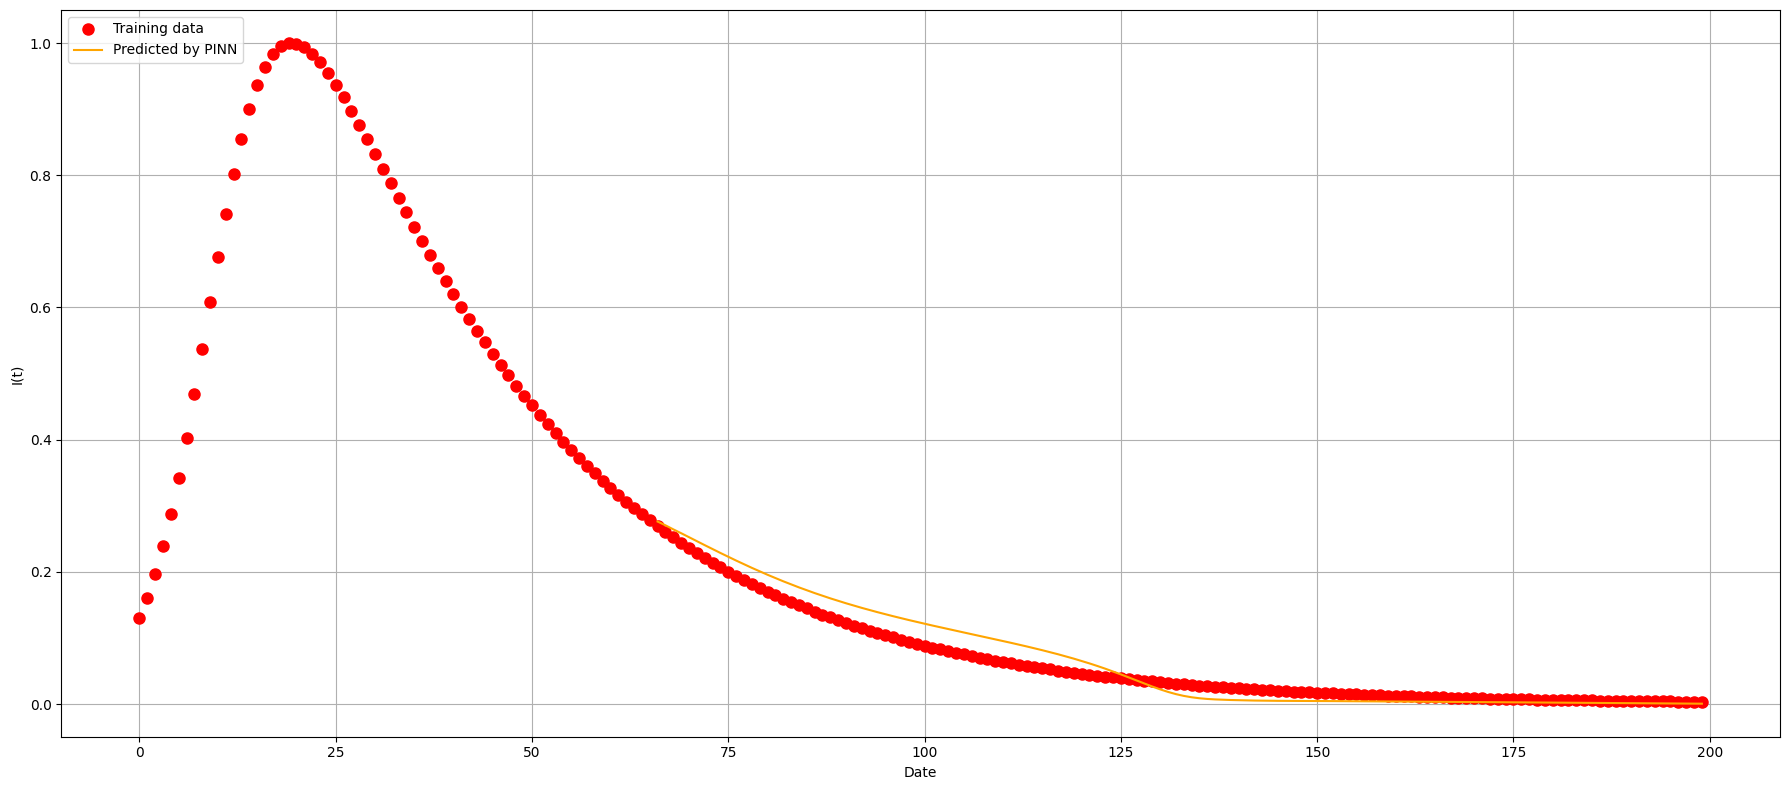

Epoch 121, MSE Loss = 9.193105370286503e-07, Average Loss = 6.615891260316182e-05


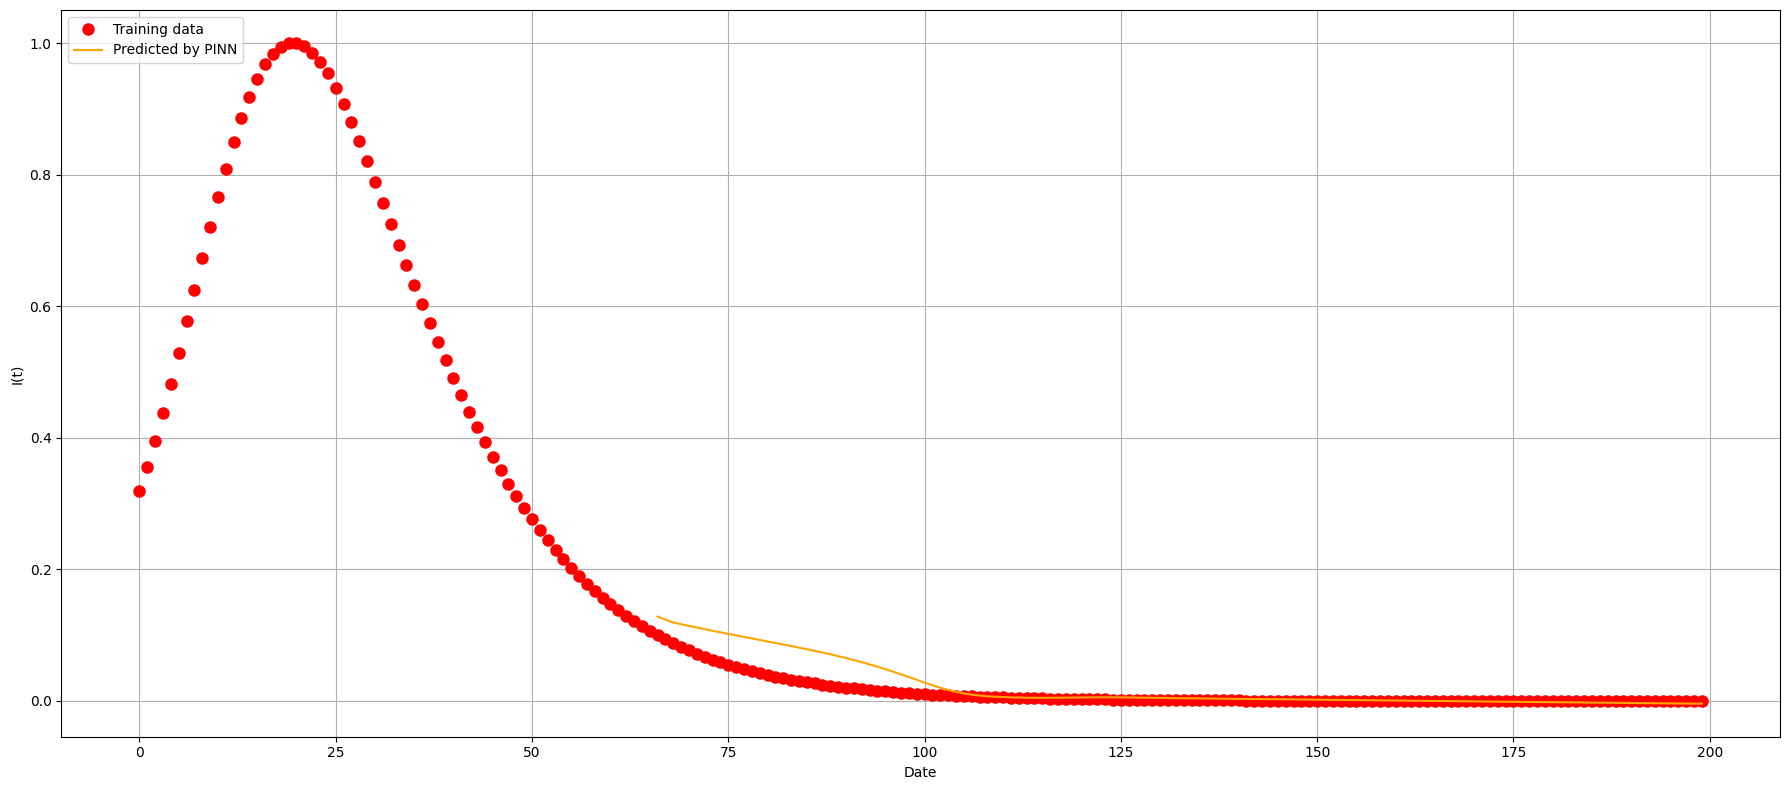

Epoch 121, MSE Loss = 2.4573932932980824e-06, Average Loss = 4.6239231947054346e-05


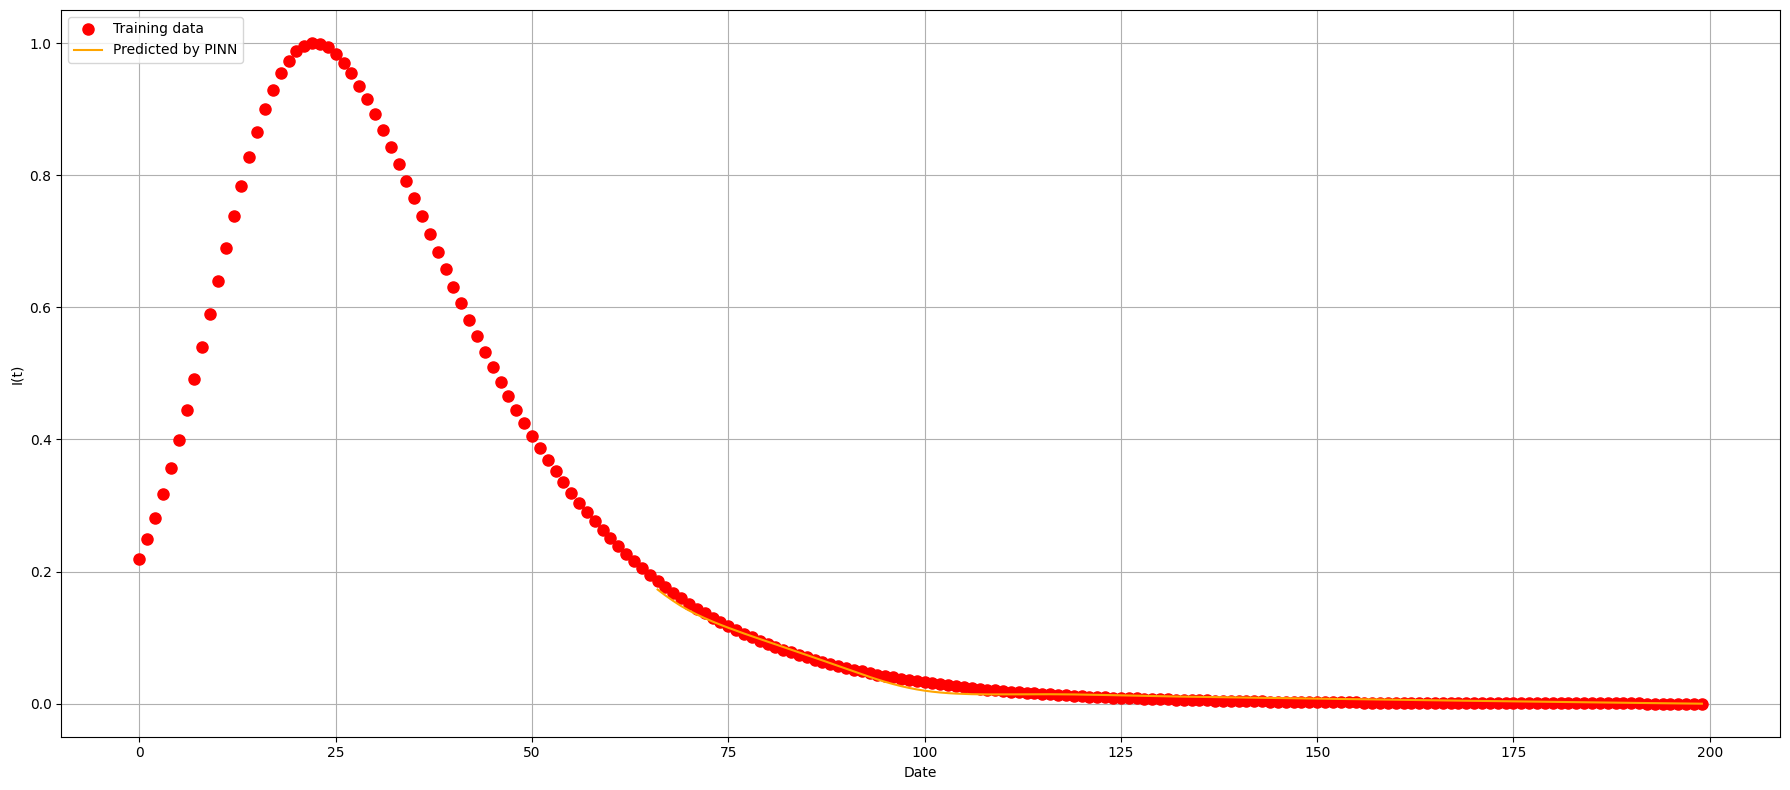

Epoch 121, MSE Loss = 1.686585591187395e-07, Average Loss = 7.86767877543405e-05


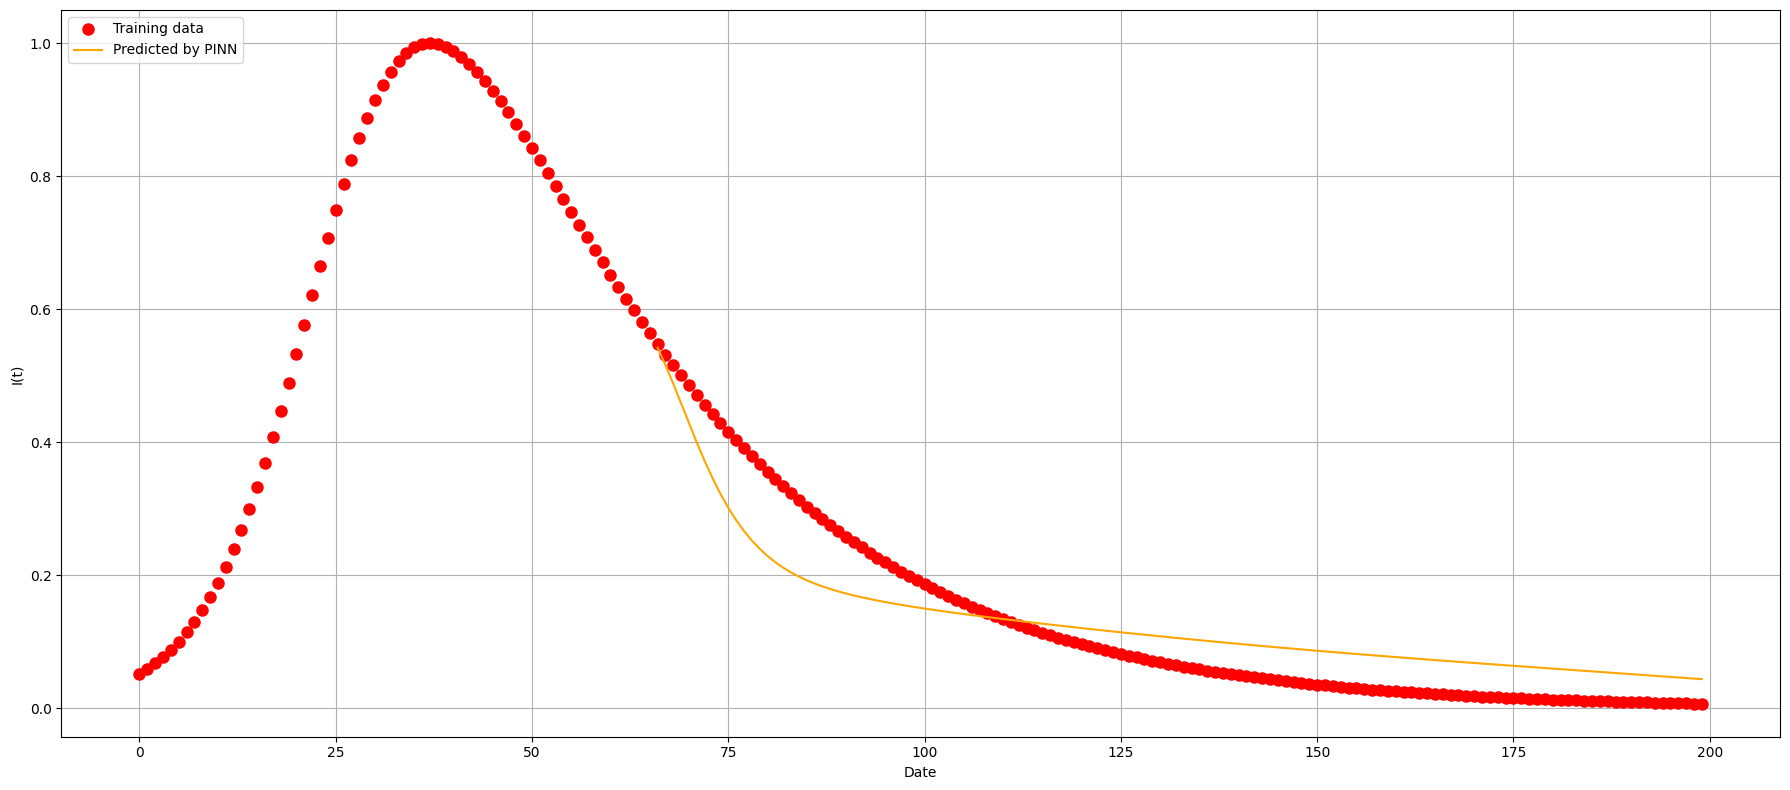

Epoch 121, MSE Loss = 4.858316628997272e-07, Average Loss = 0.00012643977118924213


Epoch 121, MSE Loss = 2.473343272413331e-07, Average Loss = 7.667022355798572e-05


Epoch 121, MSE Loss = 8.1116413586102e-10, Average Loss = 7.761057506845886e-05


Epoch 121, MSE Loss = 2.1677504264516756e-05, Average Loss = 0.00018866786659826927


Epoch 121, MSE Loss = 1.6323770068993326e-06, Average Loss = 0.00018316534947470116


Epoch 121, MSE Loss = 6.46258683900669e-07, Average Loss = 0.0003062817215945769


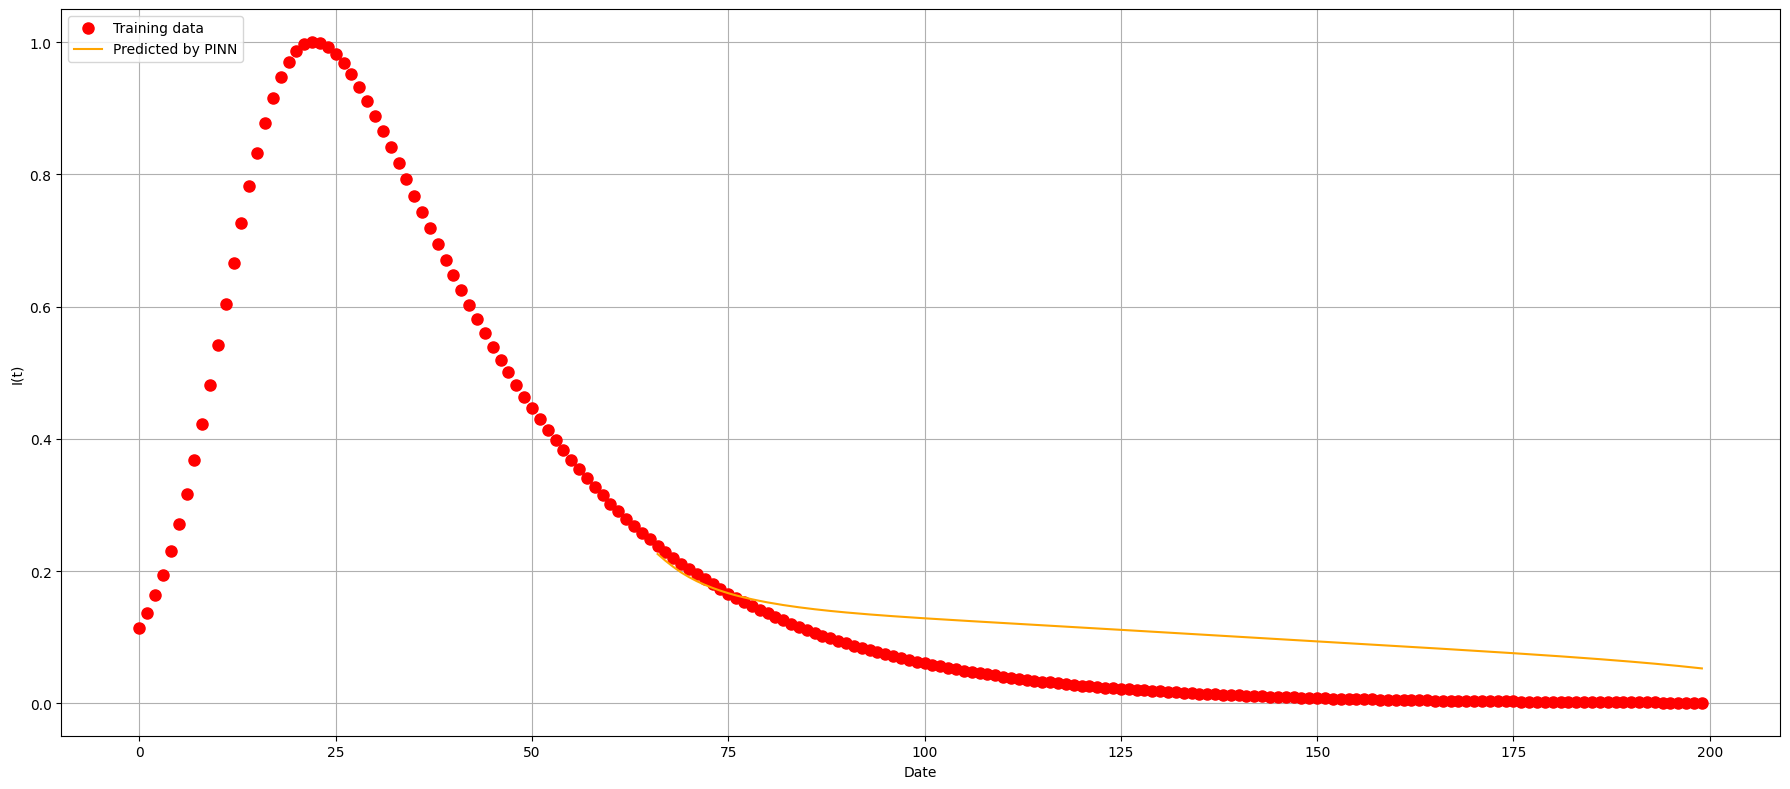

Epoch 121, MSE Loss = 4.6461309466394596e-07, Average Loss = 0.0002129435382734546
Epoch 131, MSE Loss = 4.4915211105944763e-07, Average Loss = 0.00039568107199930034
Epoch 131, MSE Loss = 7.121238468243973e-06, Average Loss = 0.00011269663941854962
Epoch 131, MSE Loss = 7.483889021386858e-06, Average Loss = 0.0004787598121991066
Epoch 131, MSE Loss = 1.130505097535206e-05, Average Loss = 0.00023898888746503924
Epoch 131, MSE Loss = 5.798816800961504e-06, Average Loss = 0.00011338509493485685
Epoch 131, MSE Loss = 8.963387699623127e-06, Average Loss = 0.00010015079603165289
Epoch 131, MSE Loss = 6.639668299612822e-06, Average Loss = 0.00024162962243808405
Epoch 131, MSE Loss = 5.945435532339616e-06, Average Loss = 0.0005540807883949949
Epoch 131, MSE Loss = 1.1881471436936408e-05, Average Loss = 0.0003445002281351455
Epoch 131, MSE Loss = 4.987778083886951e-07, Average Loss = 6.669074984890053e-05
Epoch 141, MSE Loss = 0.0014881272800266743, Average Loss = 0.0006017146560302136
Epoch 1

Epoch 161, MSE Loss = 3.5115445484734664e-07, Average Loss = 0.00025853180565610655


Epoch 161, MSE Loss = 1.36188109536306e-05, Average Loss = 0.0003137032955742697


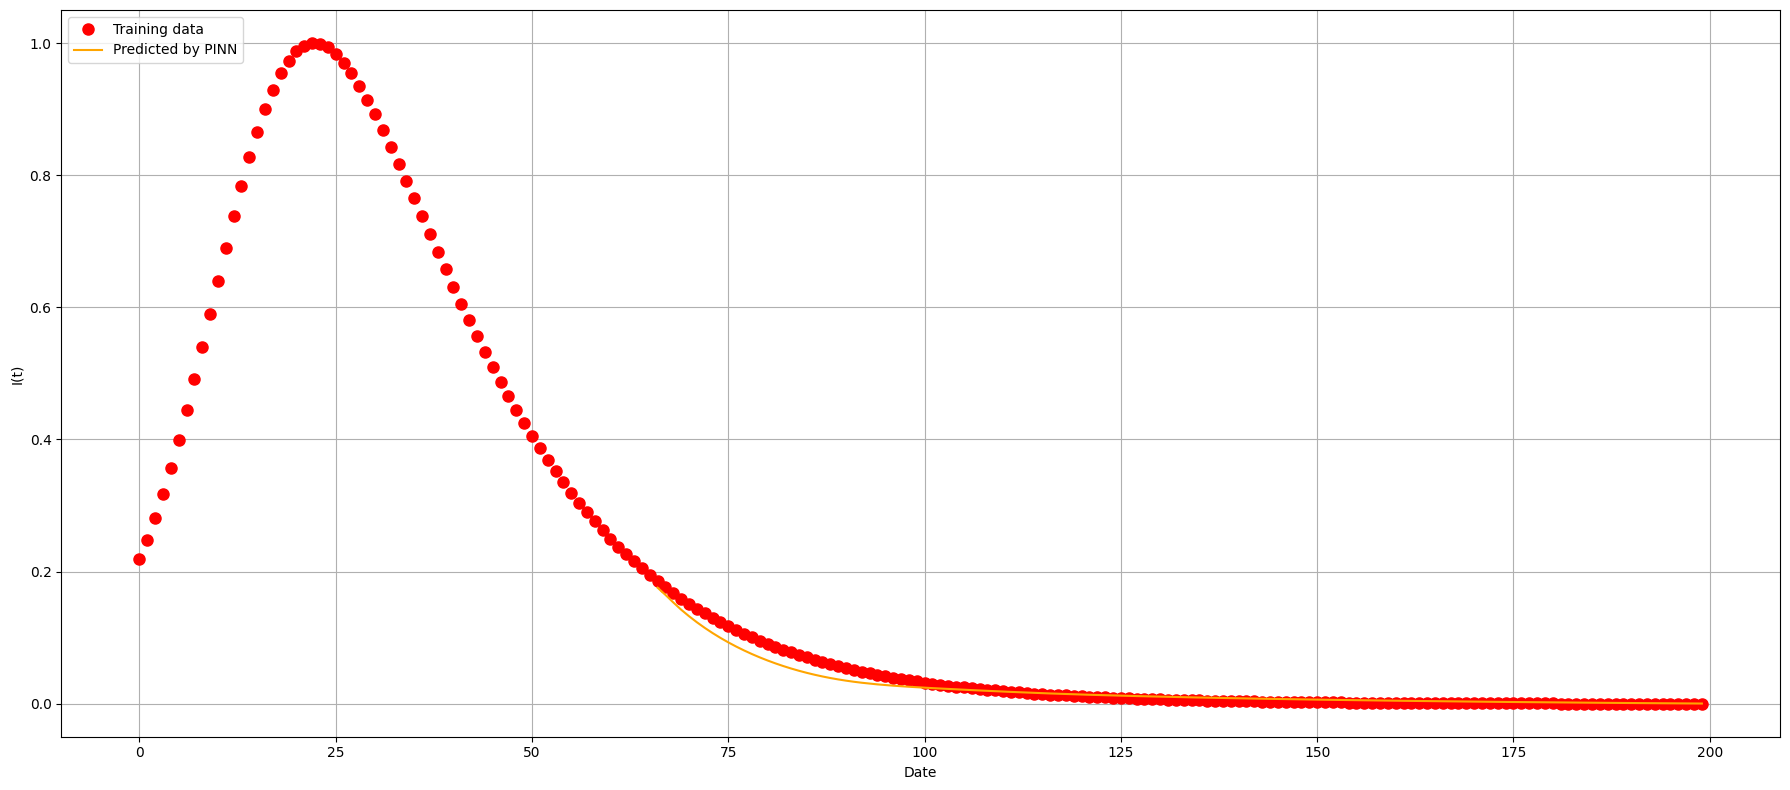

Epoch 161, MSE Loss = 2.3708615515261044e-07, Average Loss = 8.496164882213351e-05


Epoch 161, MSE Loss = 8.12553844298236e-06, Average Loss = 0.00019223688639367082


Epoch 161, MSE Loss = 4.289545074698253e-08, Average Loss = 0.00011675587508628213


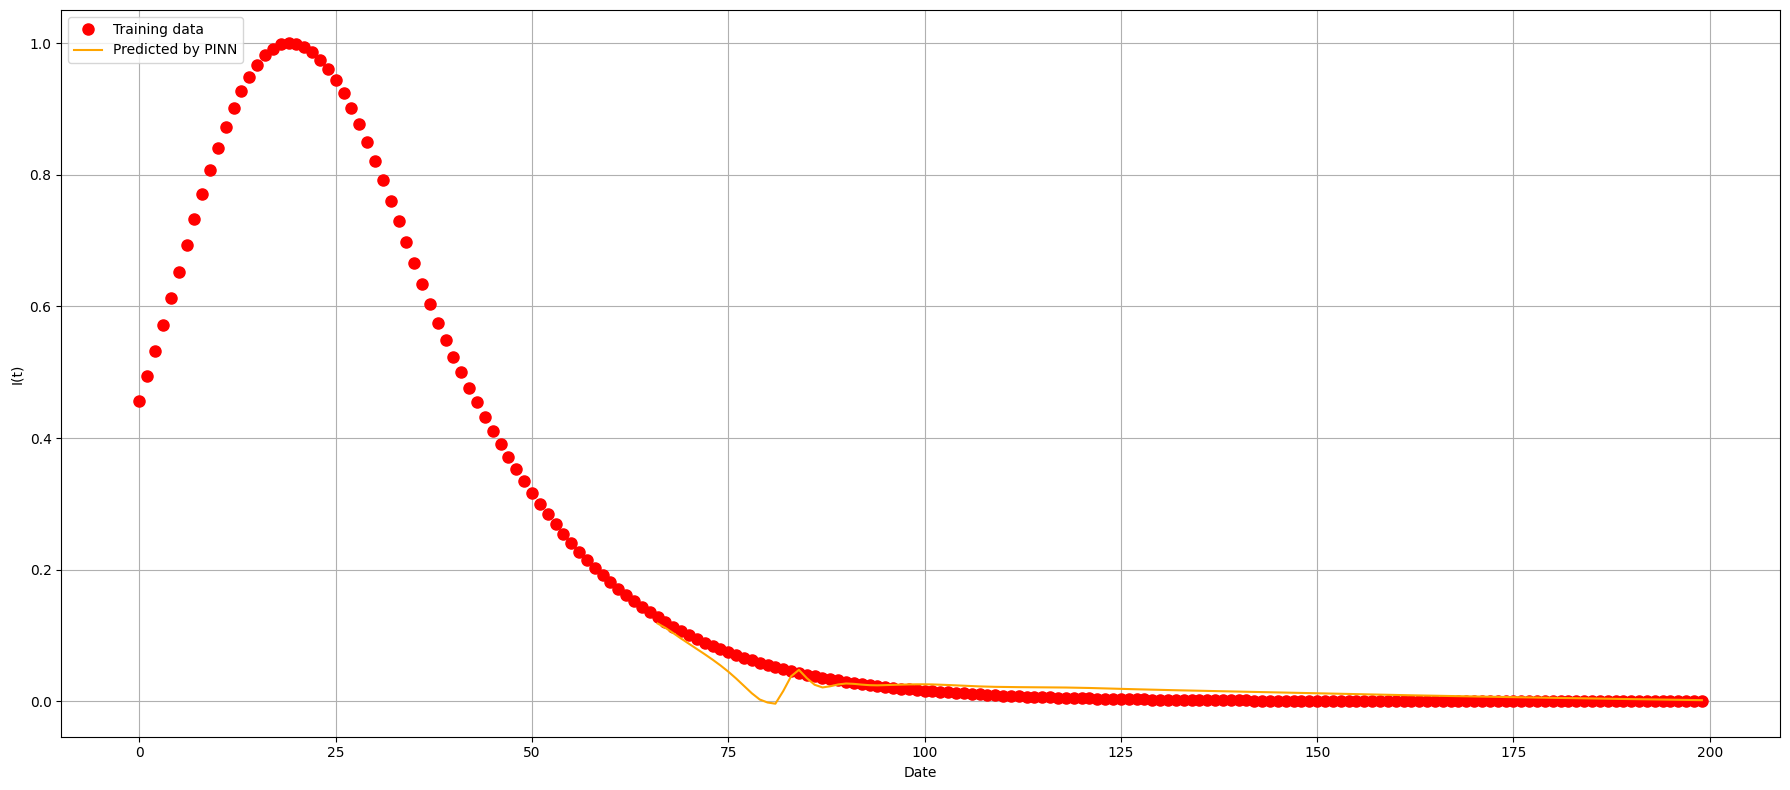

Epoch 161, MSE Loss = 2.10507050724118e-06, Average Loss = 0.00010603879292291674


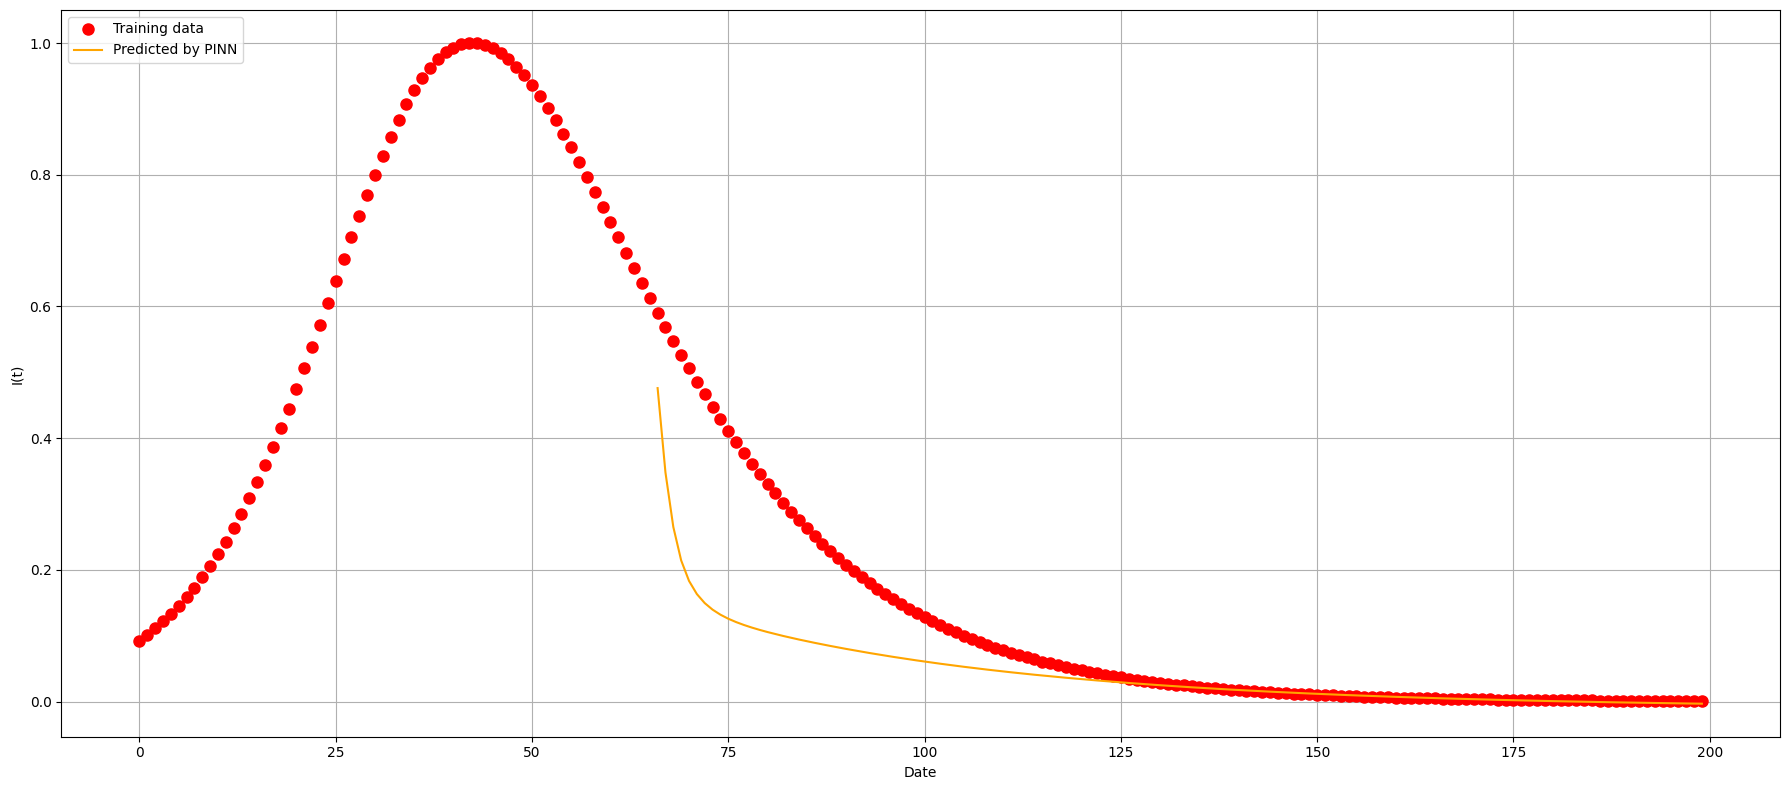

Epoch 161, MSE Loss = 4.610444011632353e-05, Average Loss = 0.00010810865821603662


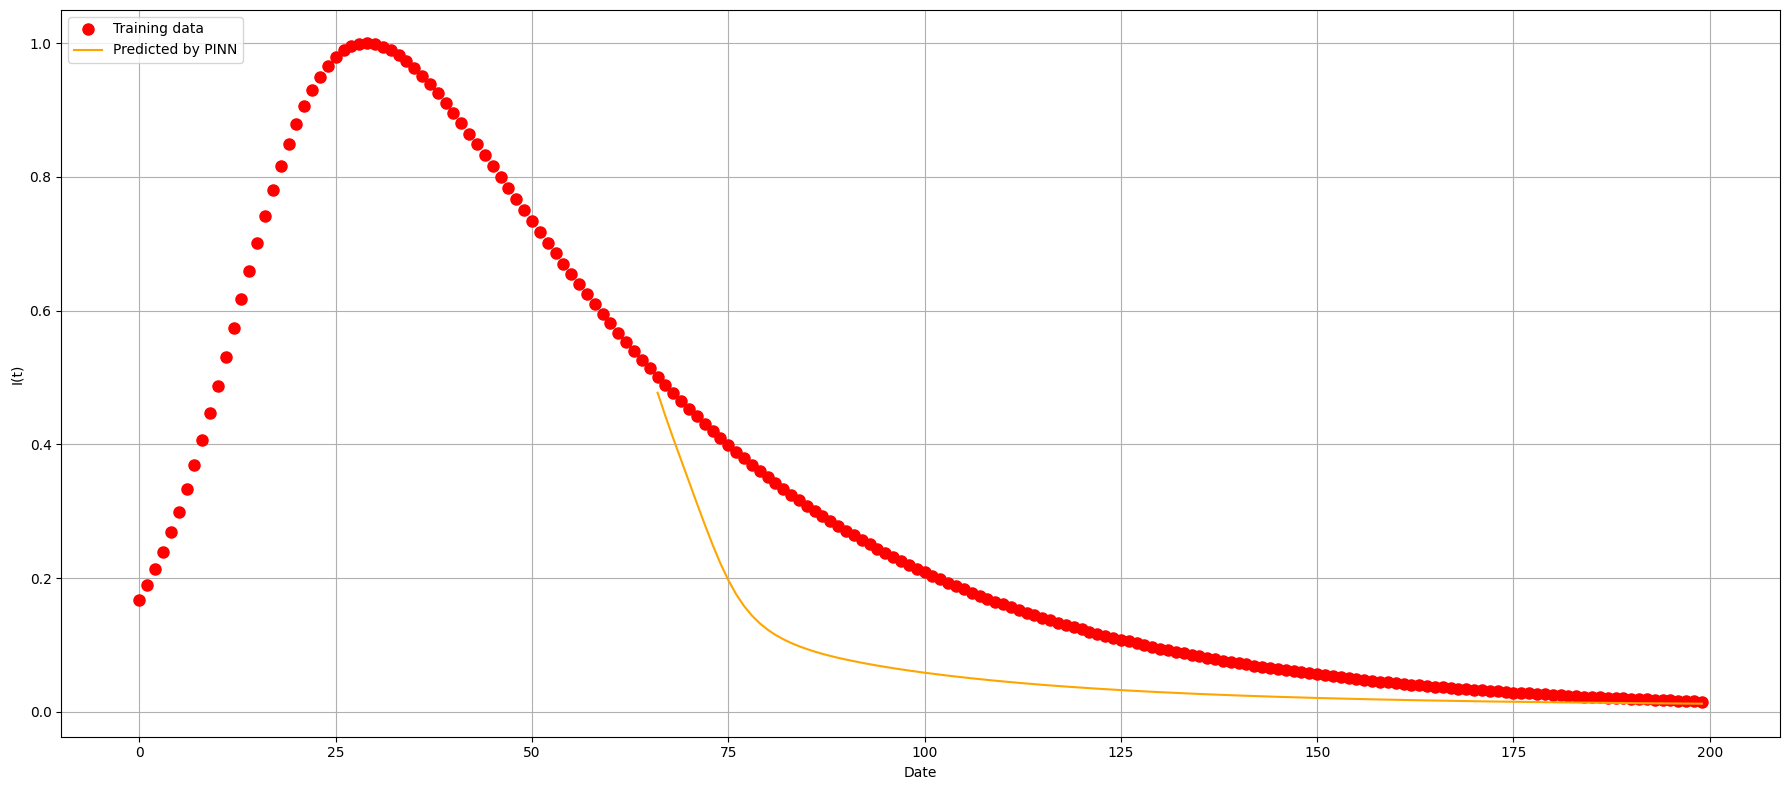

Epoch 161, MSE Loss = 1.8827091707862564e-06, Average Loss = 0.0006978097607816355


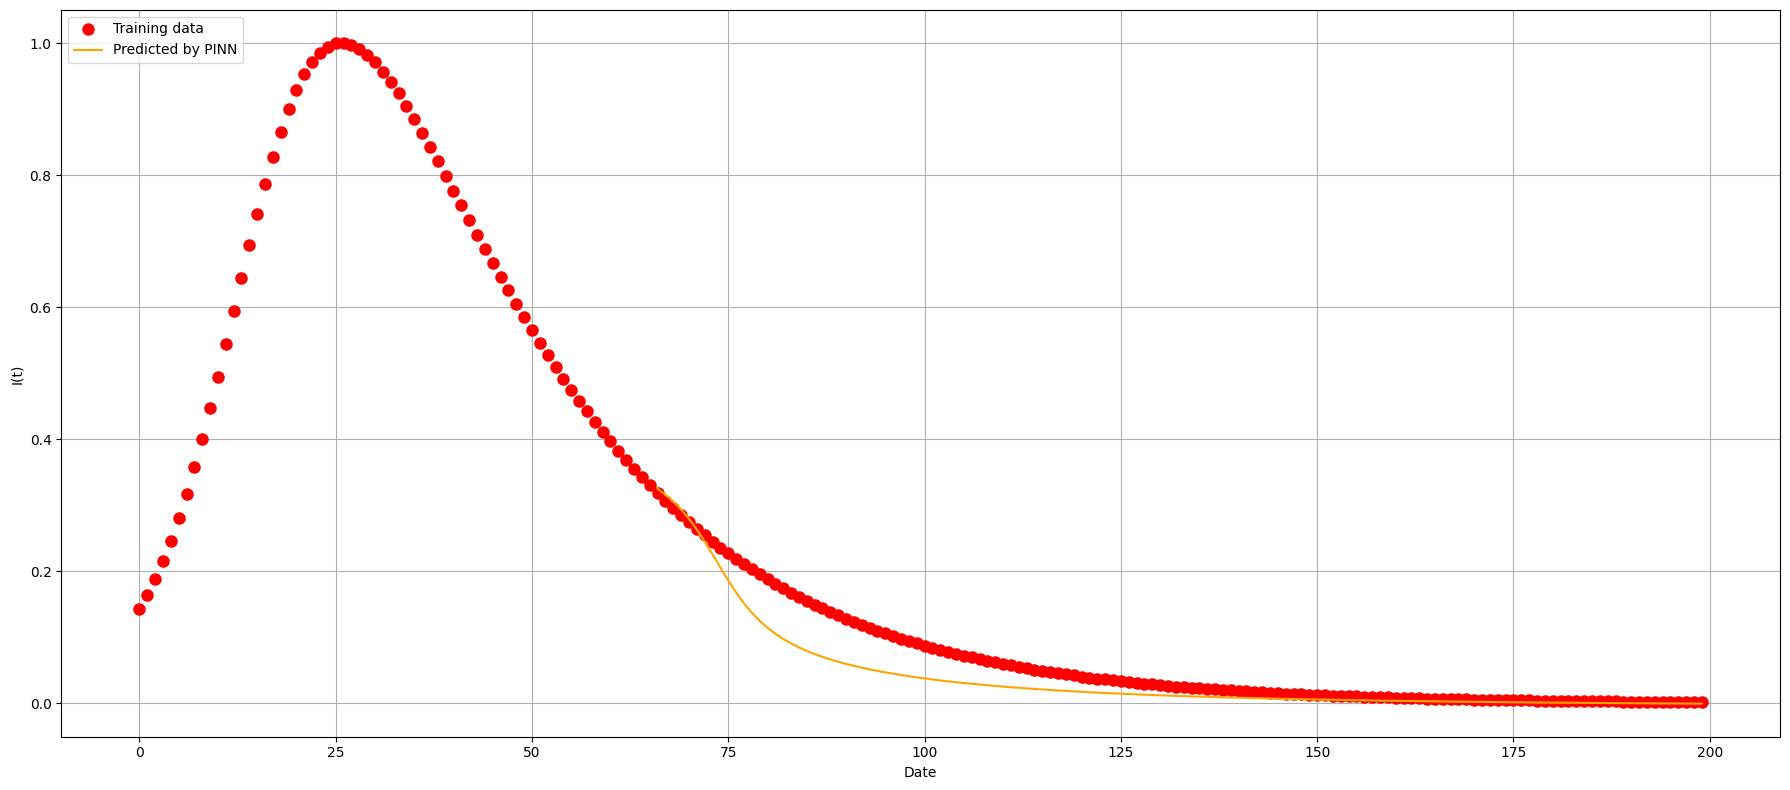

Epoch 161, MSE Loss = 5.167845529285842e-07, Average Loss = 0.0008299237632547255


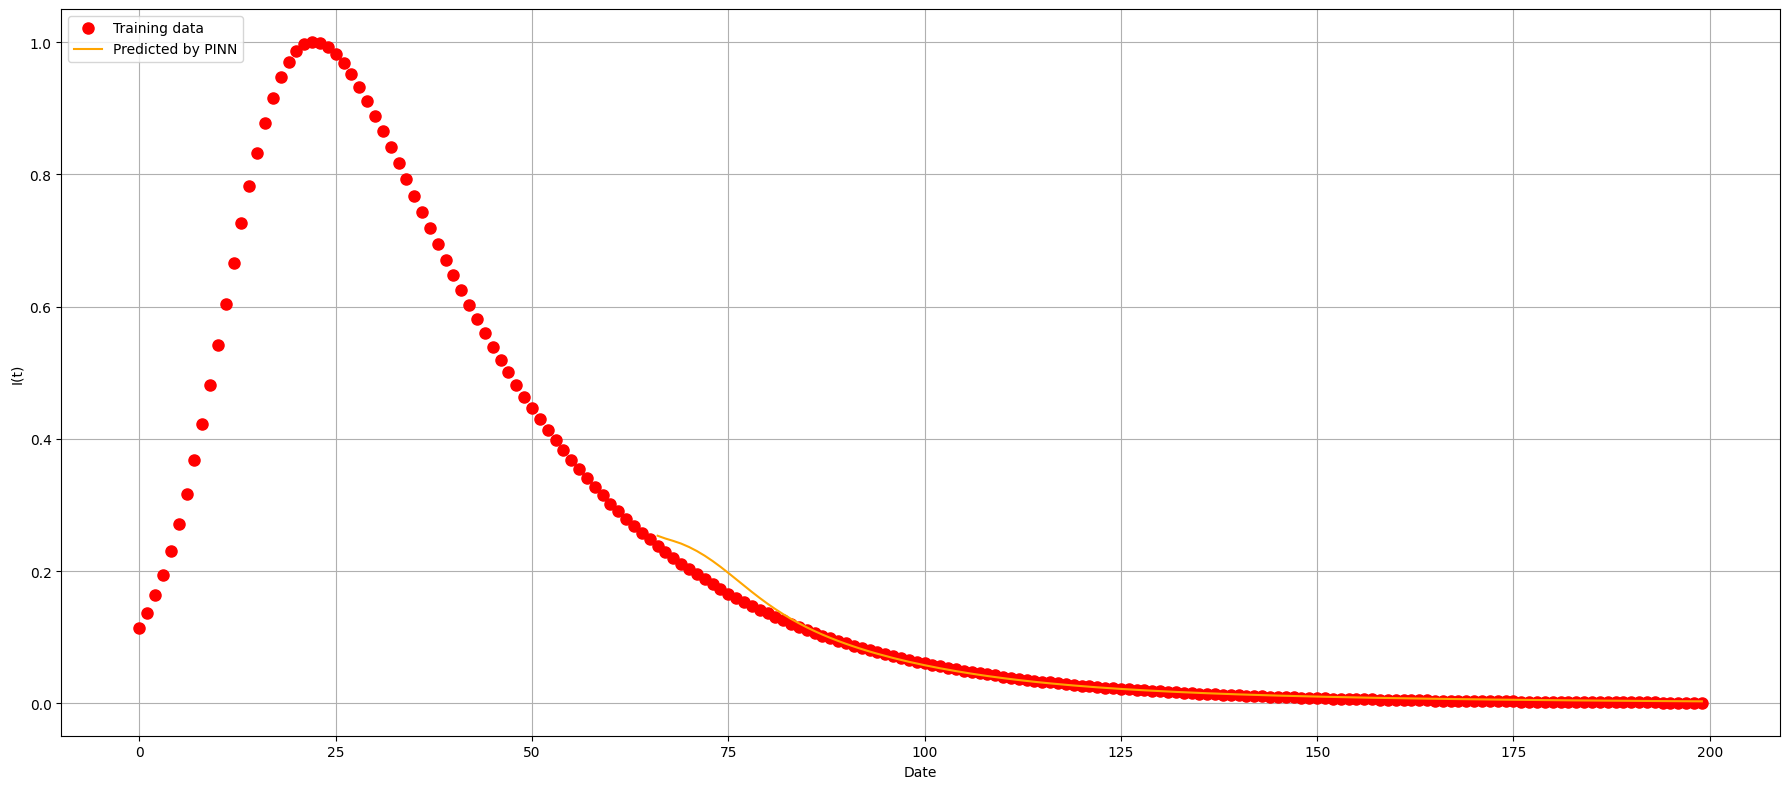

Epoch 161, MSE Loss = 3.4278778002772015e-06, Average Loss = 0.00024167273176314854
Epoch 171, MSE Loss = 2.263302803839906e-06, Average Loss = 0.00013788284715386673
Epoch 171, MSE Loss = 6.293934120549238e-07, Average Loss = 4.943601286312396e-05
Epoch 171, MSE Loss = 1.5382402125396766e-06, Average Loss = 0.00010465181476414821
Epoch 171, MSE Loss = 9.237777209847309e-12, Average Loss = 0.0001590881611415312
Epoch 171, MSE Loss = 1.4900653866334324e-07, Average Loss = 6.917571596625654e-05
Epoch 171, MSE Loss = 3.6945471038052347e-06, Average Loss = 2.6945382607209516e-05
Epoch 171, MSE Loss = 1.6098306332423817e-06, Average Loss = 8.048173987721028e-05
Epoch 171, MSE Loss = 3.6433231986876535e-09, Average Loss = 0.0001990403468537577
Epoch 171, MSE Loss = 1.3447247511066962e-06, Average Loss = 0.0001955599250888501
Epoch 171, MSE Loss = 2.619218442134752e-08, Average Loss = 0.00011703345640617665
Epoch 181, MSE Loss = 6.4463815760973375e-06, Average Loss = 0.0007275524020501445
Epo

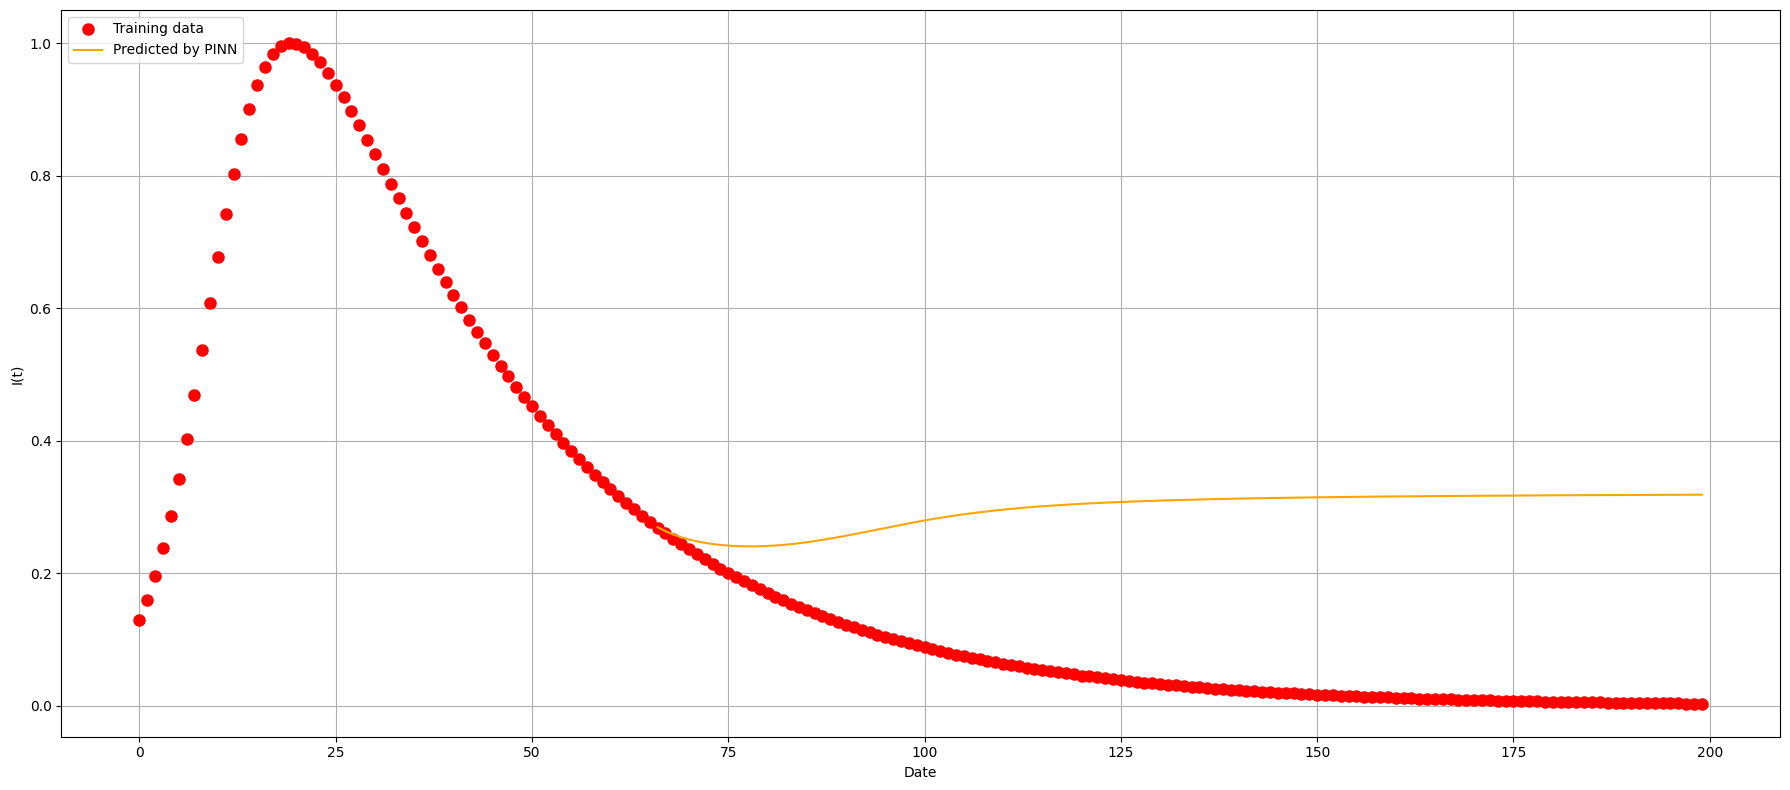

Epoch 201, MSE Loss = 1.648002398724202e-05, Average Loss = 0.0002473217581598996


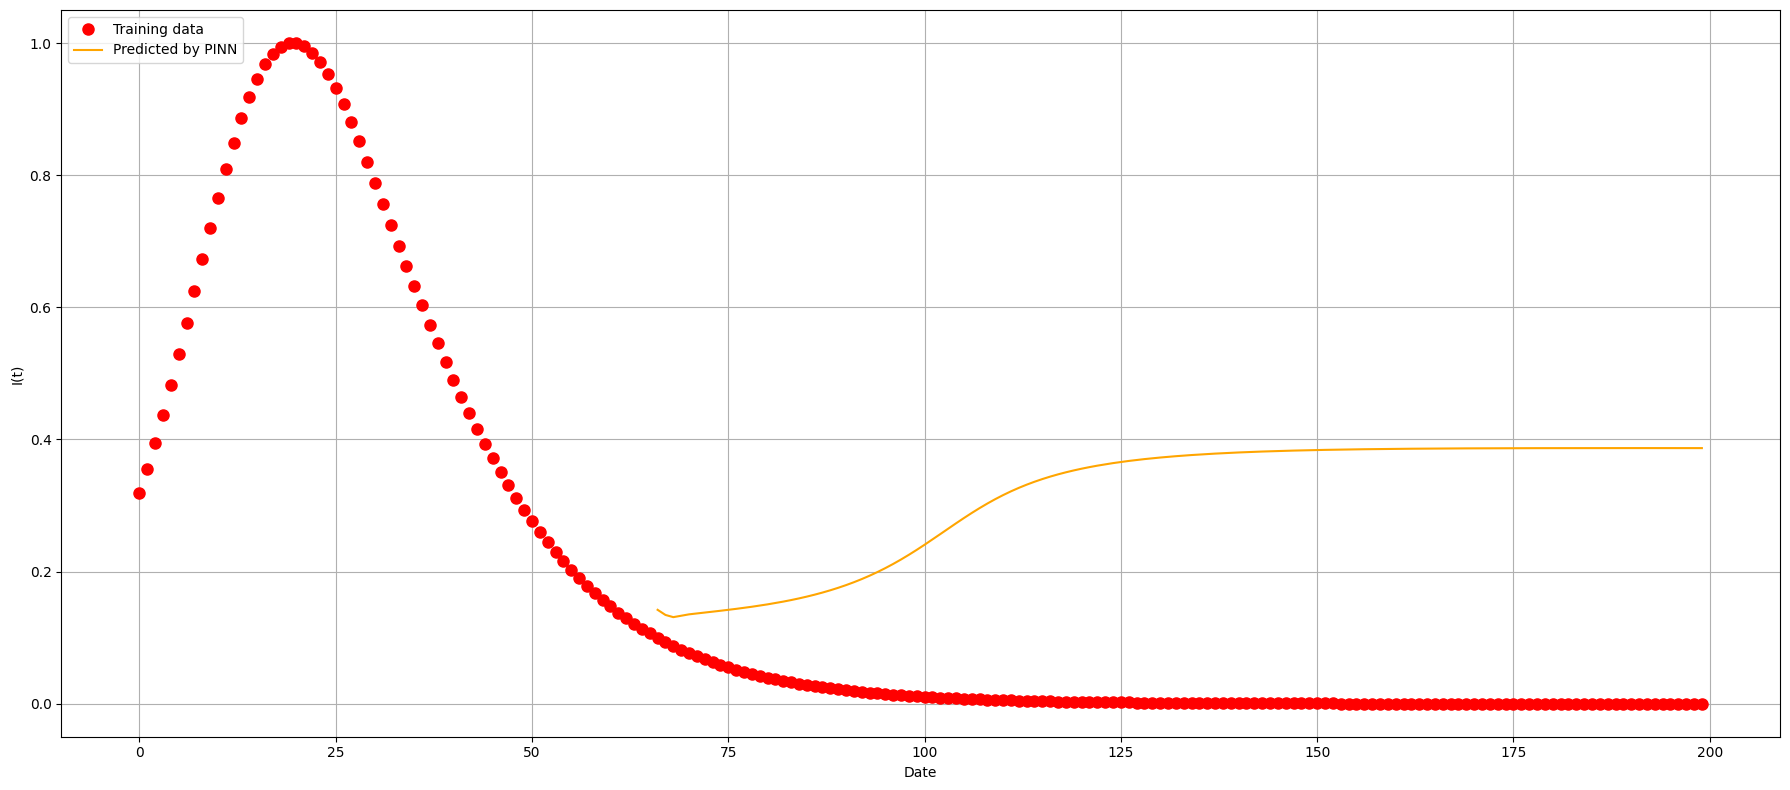

Epoch 201, MSE Loss = 5.5517968888807445e-08, Average Loss = 0.00021069642235279306


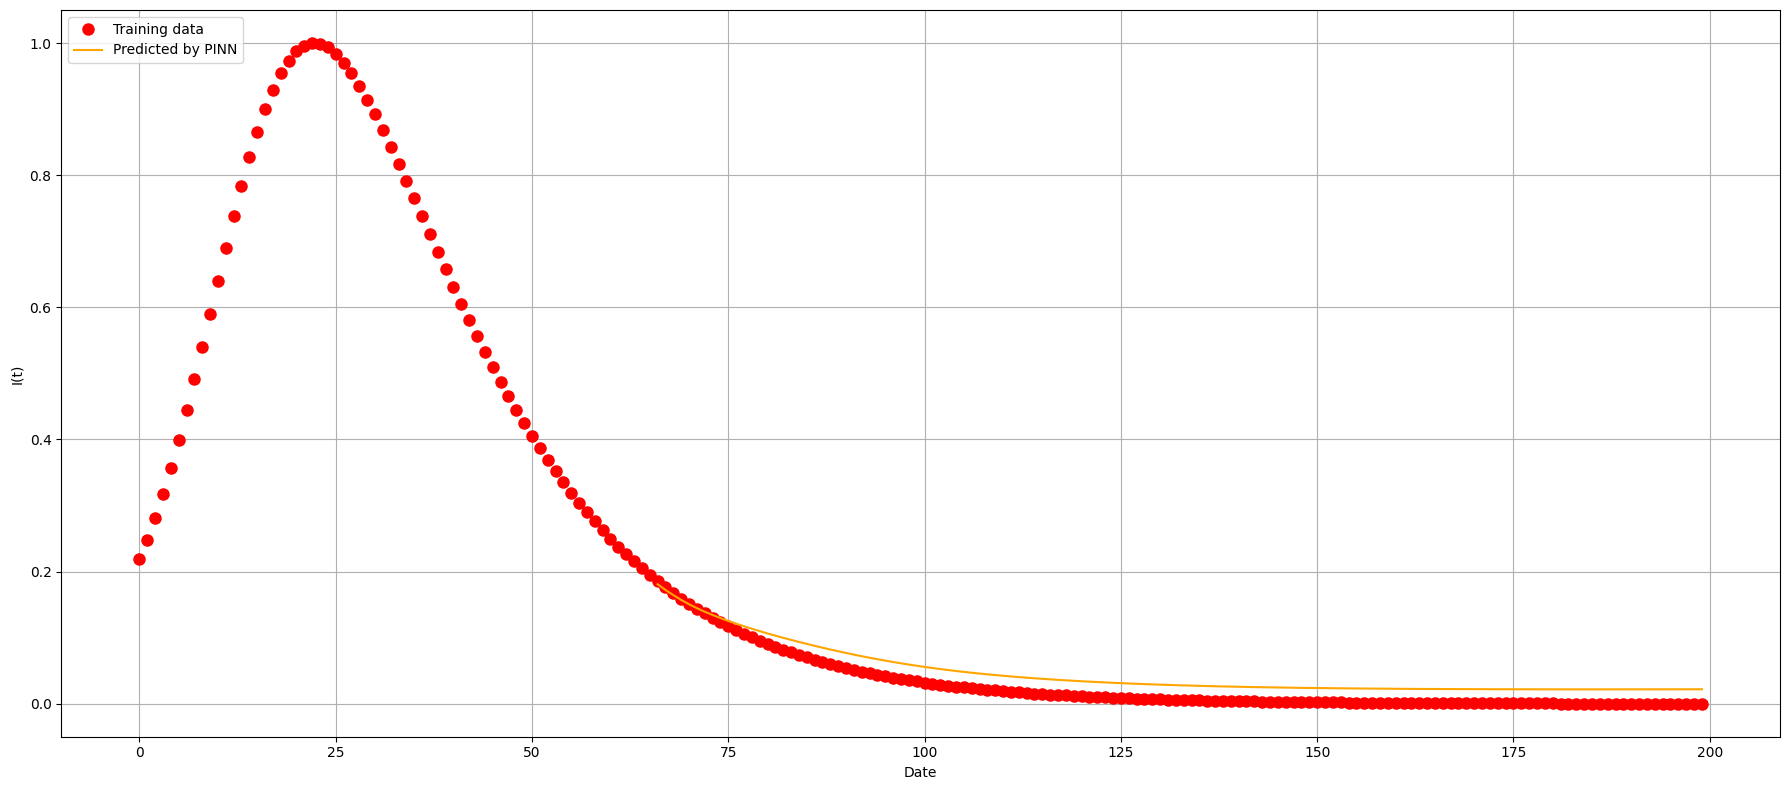

Epoch 201, MSE Loss = 6.239985168576823e-07, Average Loss = 0.000292675651681648


Epoch 201, MSE Loss = 6.568206117663067e-06, Average Loss = 0.00020249043651987138


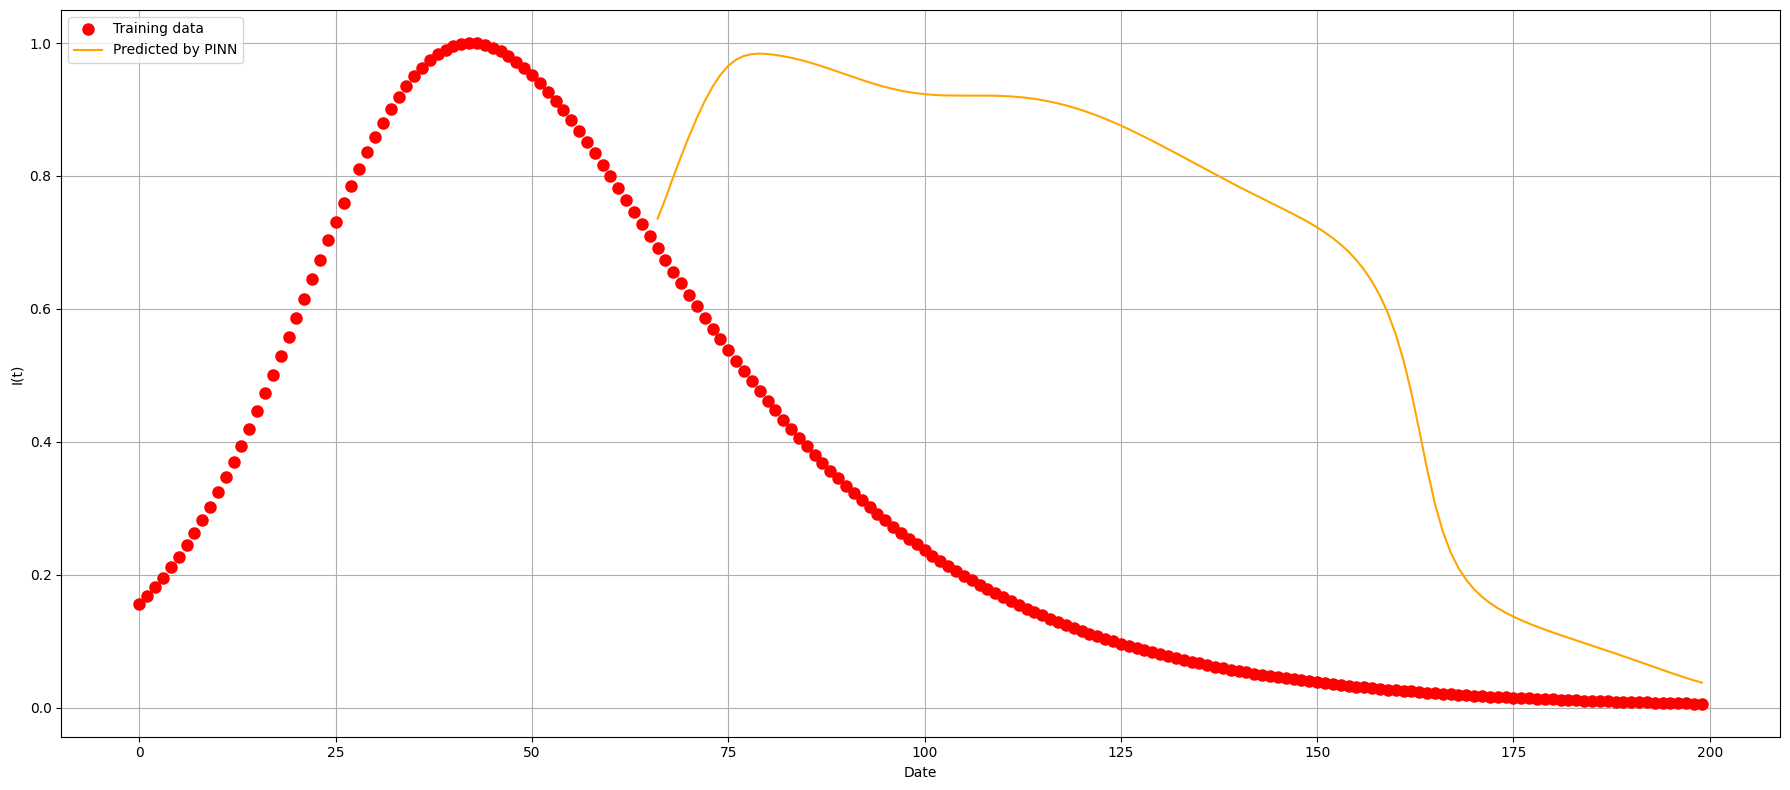

Epoch 201, MSE Loss = 2.8468097212908106e-08, Average Loss = 0.0002195685328850779


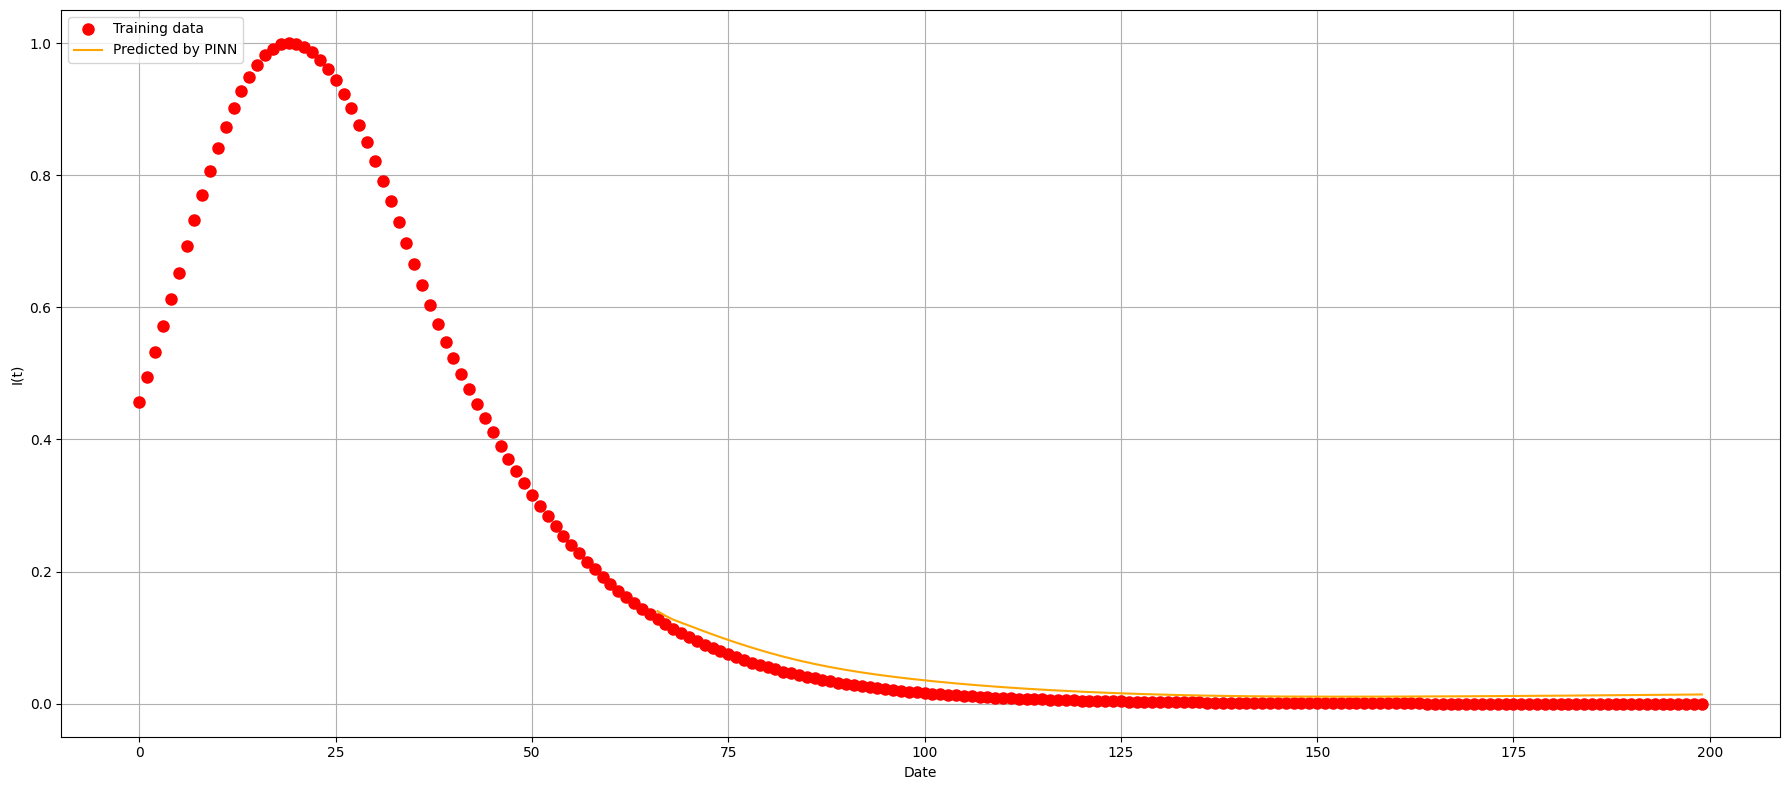

Epoch 201, MSE Loss = 8.775688797868497e-07, Average Loss = 9.855347042658693e-05


Epoch 201, MSE Loss = 4.573601017909823e-06, Average Loss = 0.00012888048019599888


Epoch 201, MSE Loss = 1.1876987628056668e-05, Average Loss = 0.00010185057421699676


Epoch 201, MSE Loss = 1.8610950291986228e-07, Average Loss = 9.228022604360384e-05


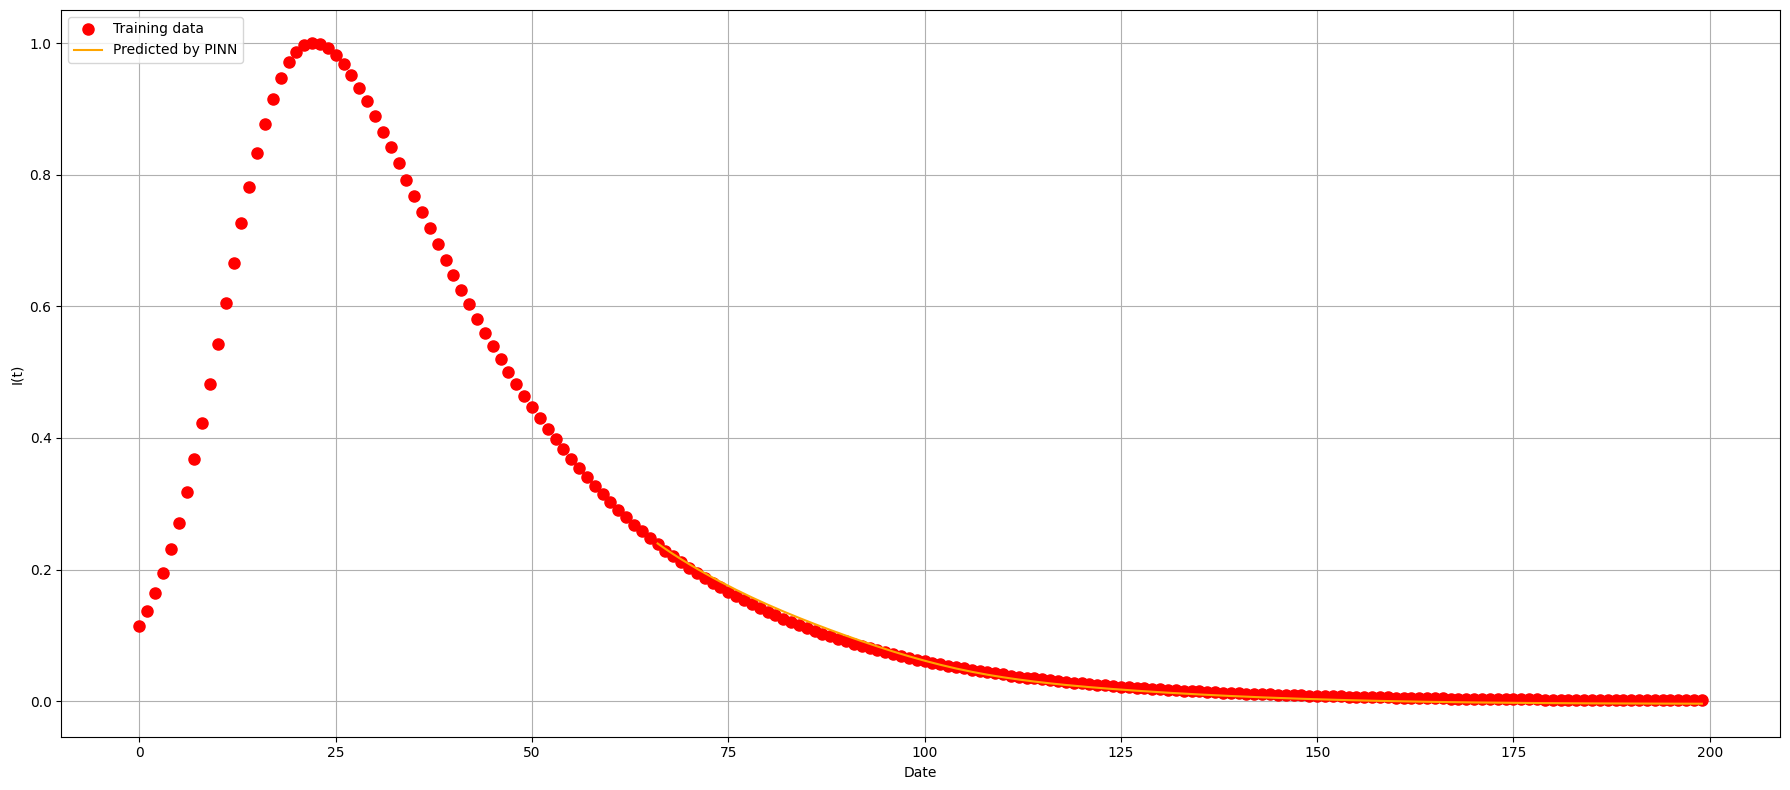

Epoch 201, MSE Loss = 1.1689123311953153e-05, Average Loss = 7.384963247446892e-05
Epoch 211, MSE Loss = 3.0084961508691777e-06, Average Loss = 8.59116538300169e-05
Epoch 211, MSE Loss = 1.050522223522421e-05, Average Loss = 0.0001538860707653766
Epoch 211, MSE Loss = 7.417049232572026e-07, Average Loss = 7.041682442672768e-05
Epoch 211, MSE Loss = 2.5639044451963855e-06, Average Loss = 0.00027565720587157565
Epoch 211, MSE Loss = 5.047274385105993e-07, Average Loss = 0.00012625401759316736
Epoch 211, MSE Loss = 8.516784499867924e-11, Average Loss = 4.046670784496562e-05
Epoch 211, MSE Loss = 2.0331151873165254e-08, Average Loss = 6.699049625929561e-05
Epoch 211, MSE Loss = 8.468704777442326e-07, Average Loss = 0.00020663911344455523
Epoch 211, MSE Loss = 6.997421451160335e-07, Average Loss = 8.072399360424769e-05
Epoch 211, MSE Loss = 3.843520062218886e-07, Average Loss = 3.9775370332056875e-05
Epoch 221, MSE Loss = 9.100158959718385e-10, Average Loss = 0.00019336380732708577
Epoch 22

Epoch 241, MSE Loss = 7.387496907540481e-07, Average Loss = 0.0001867933452628331


Epoch 241, MSE Loss = 3.2653804282745114e-07, Average Loss = 0.00011917538865096663


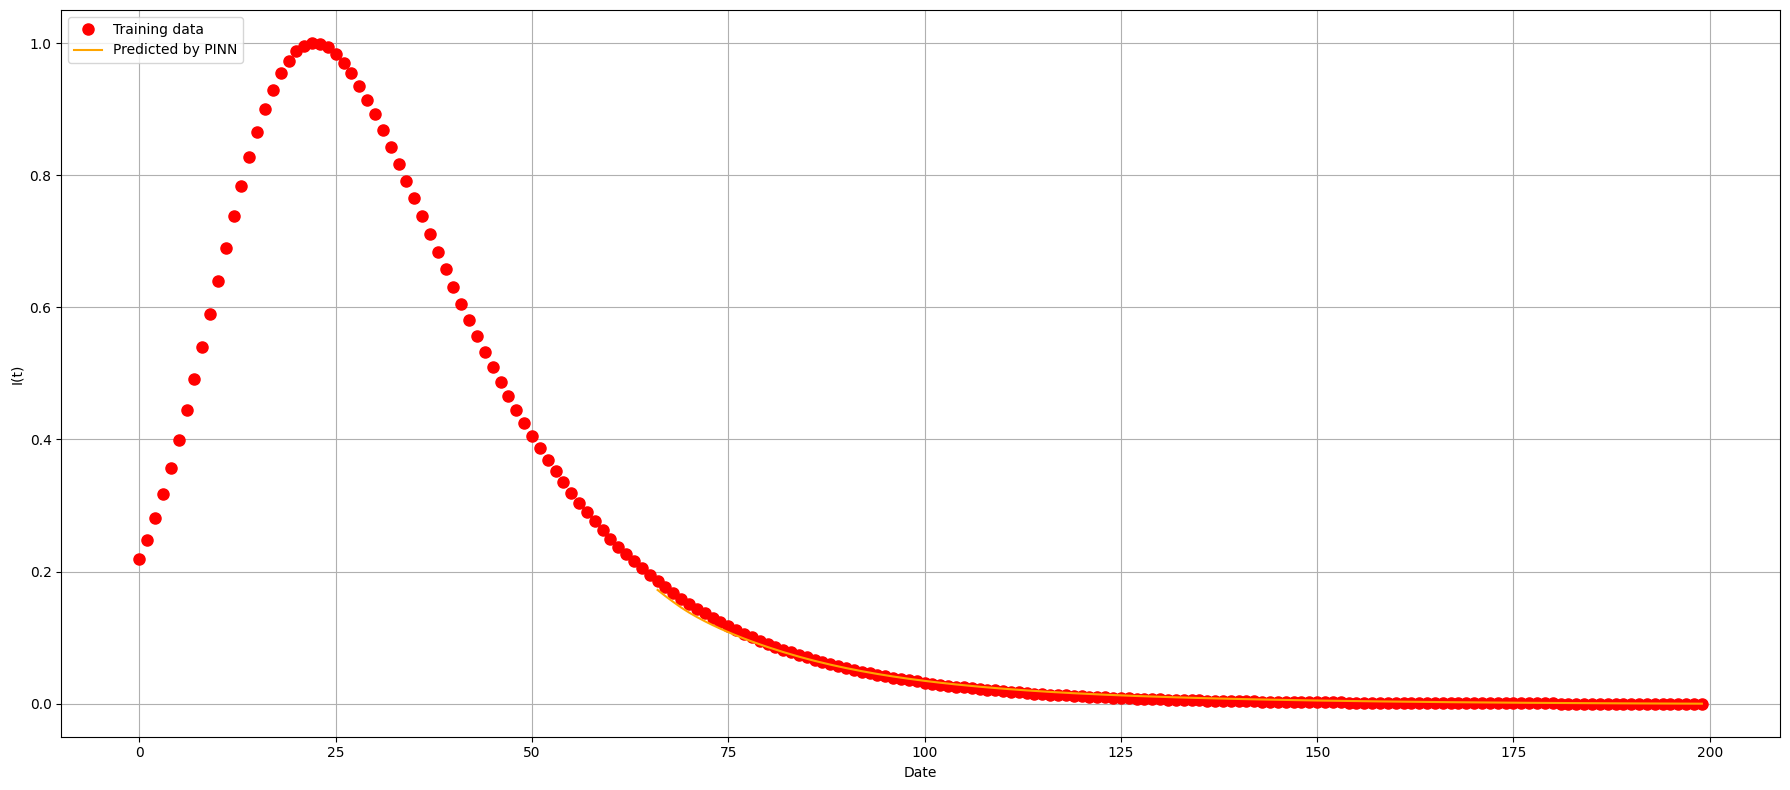

Epoch 241, MSE Loss = 9.706558223854245e-09, Average Loss = 0.00018686115176145046


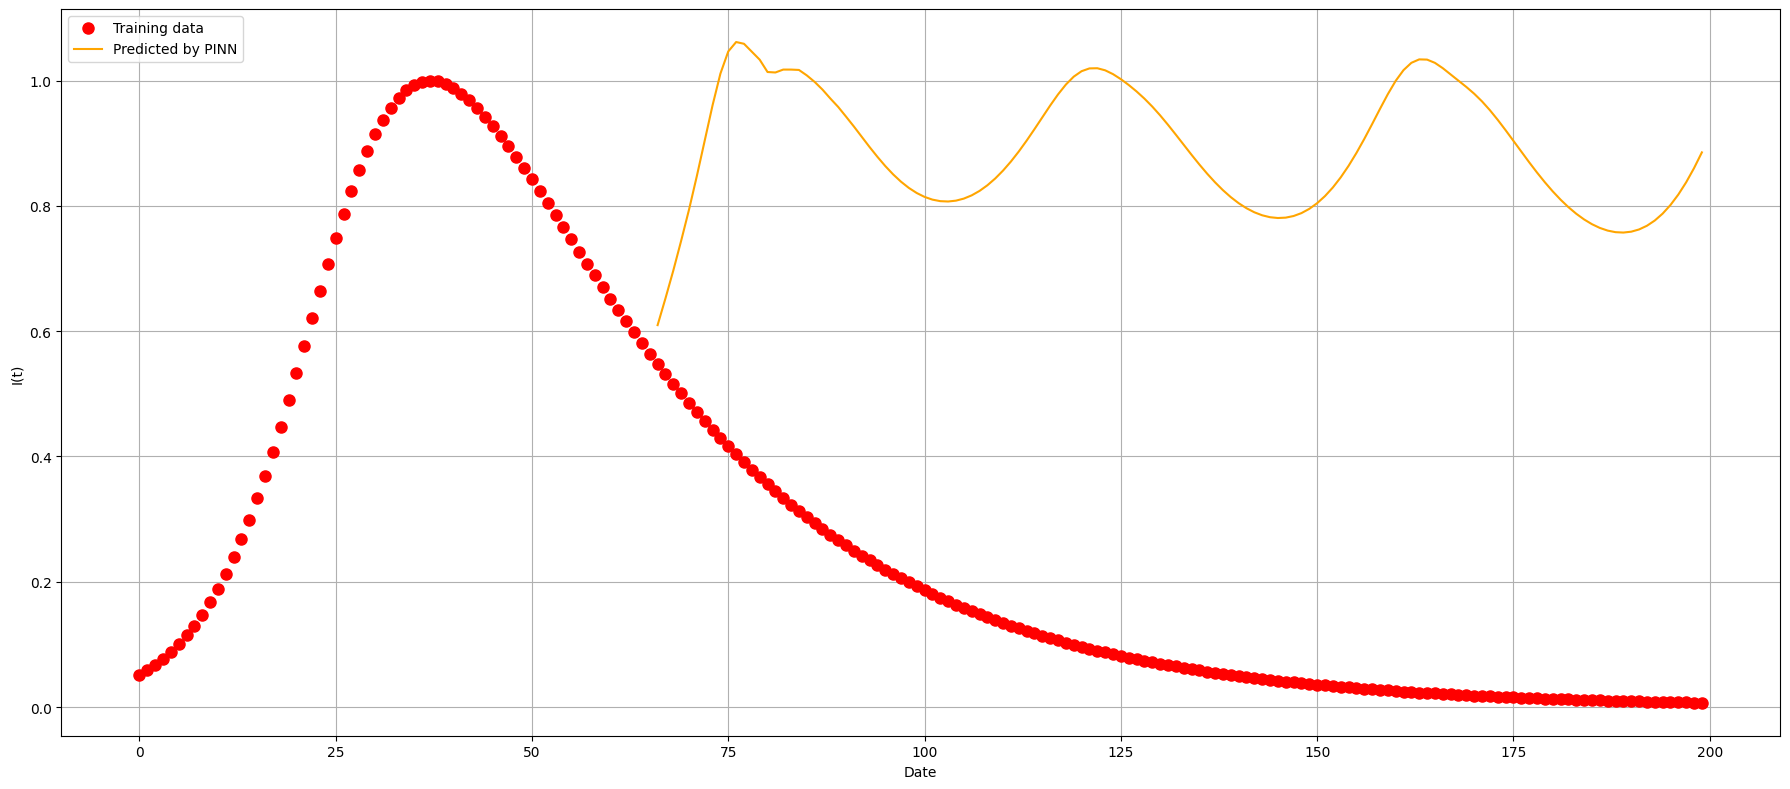

Epoch 241, MSE Loss = 1.8808578943207976e-06, Average Loss = 0.00022921577339029704


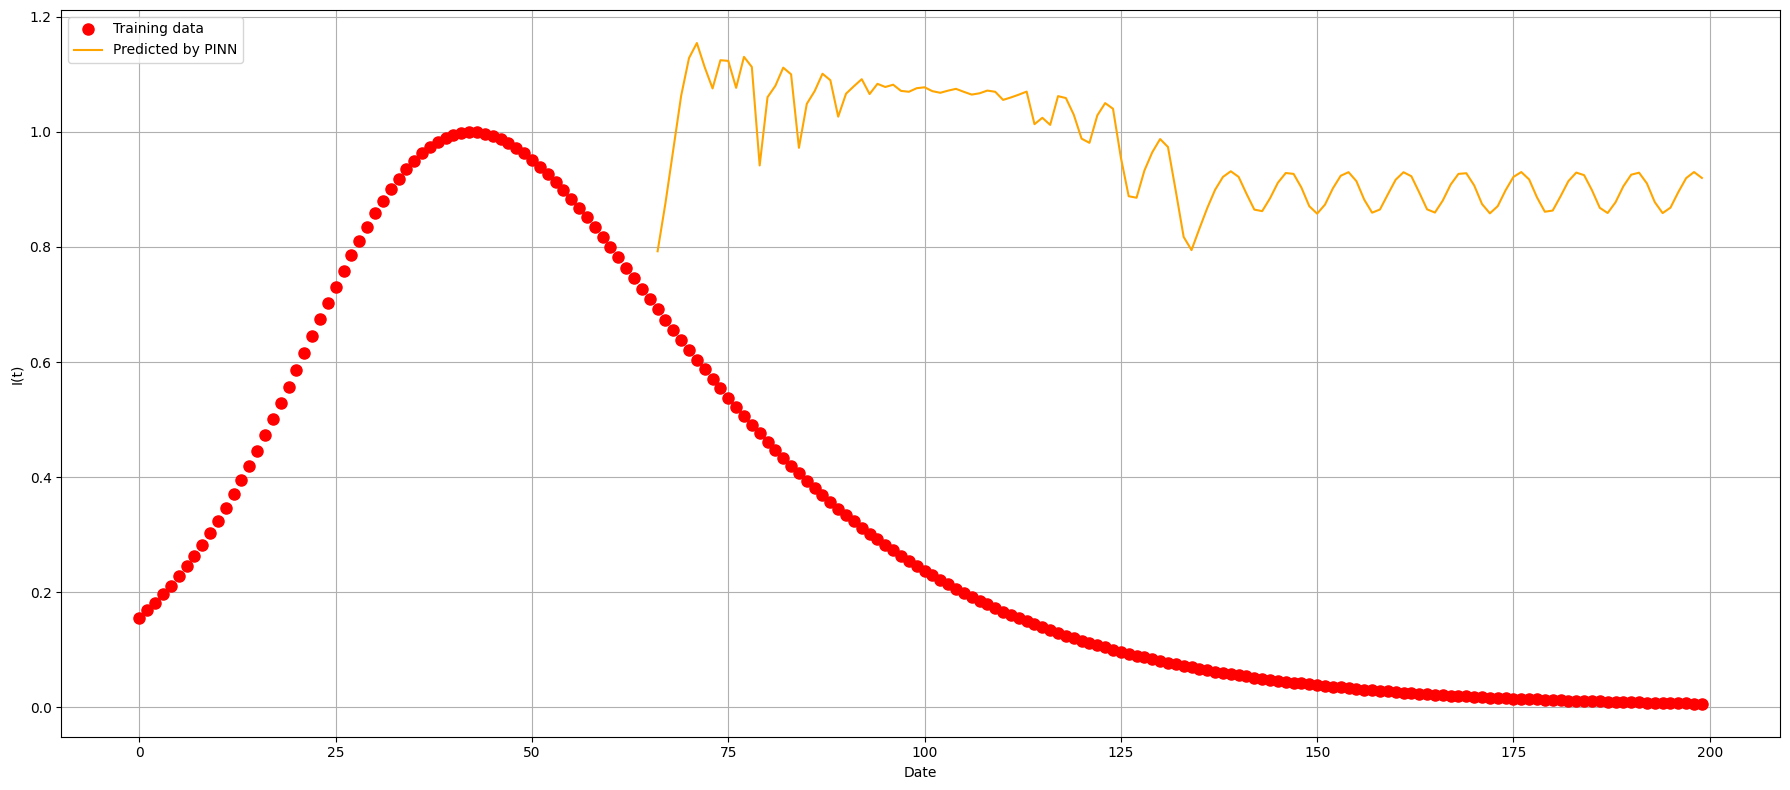

Epoch 241, MSE Loss = 1.1133244548489074e-08, Average Loss = 0.0001663239502309393


Epoch 241, MSE Loss = 3.691395855653923e-09, Average Loss = 0.0001994628030117374


Epoch 241, MSE Loss = 2.213917241533636e-06, Average Loss = 0.00018151818354381129


Epoch 241, MSE Loss = 2.8179854325571796e-06, Average Loss = 0.0005160200365297782


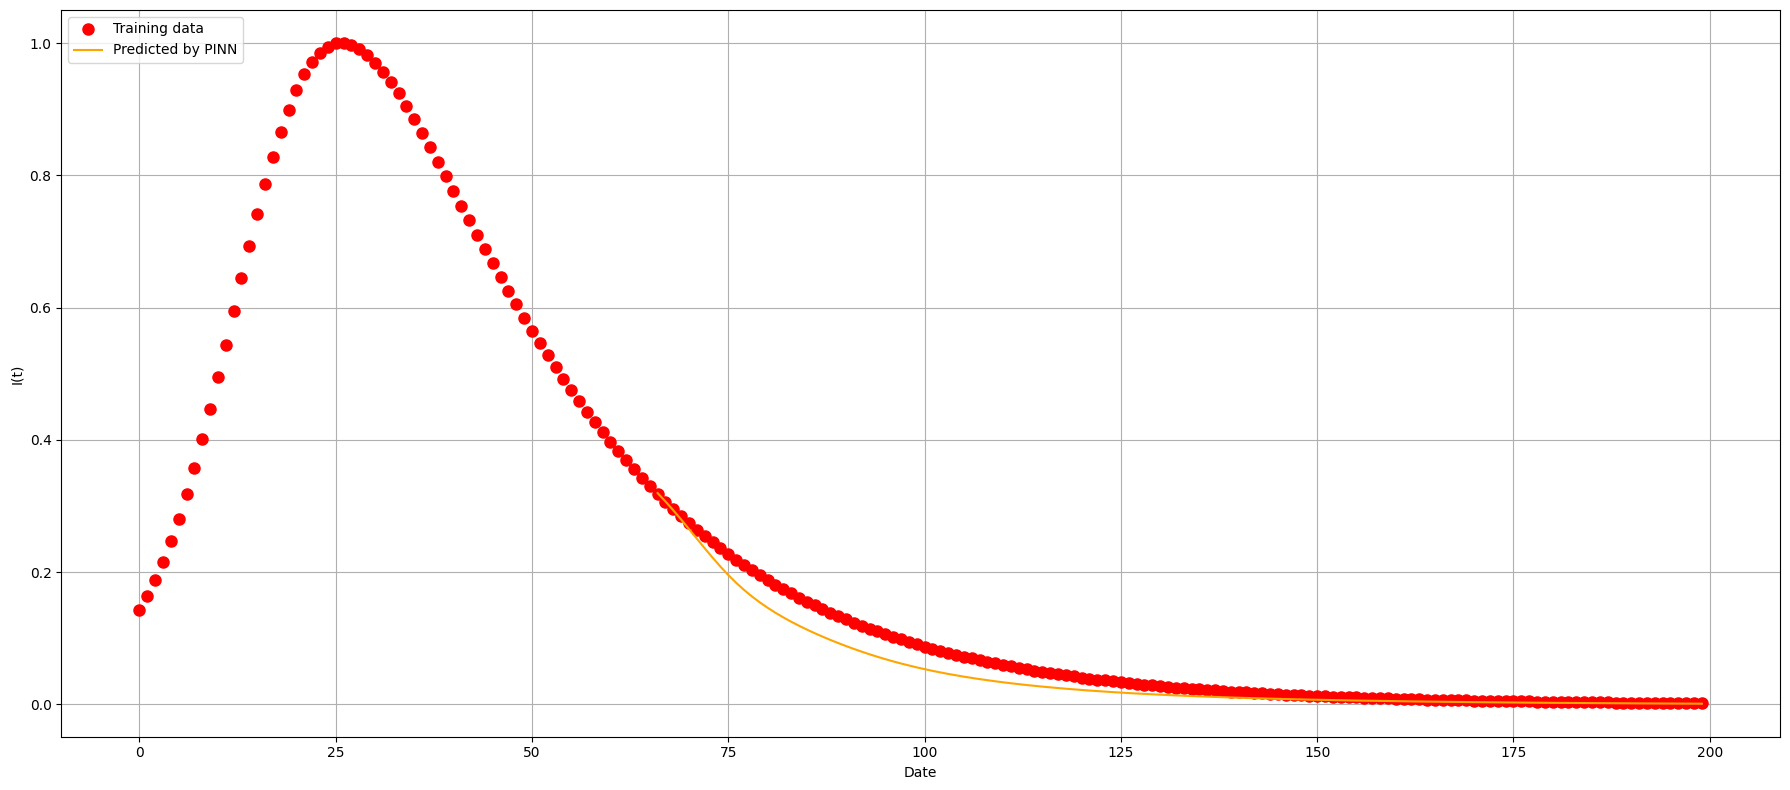

Epoch 241, MSE Loss = 2.281685418381585e-08, Average Loss = 0.00017766597414402925


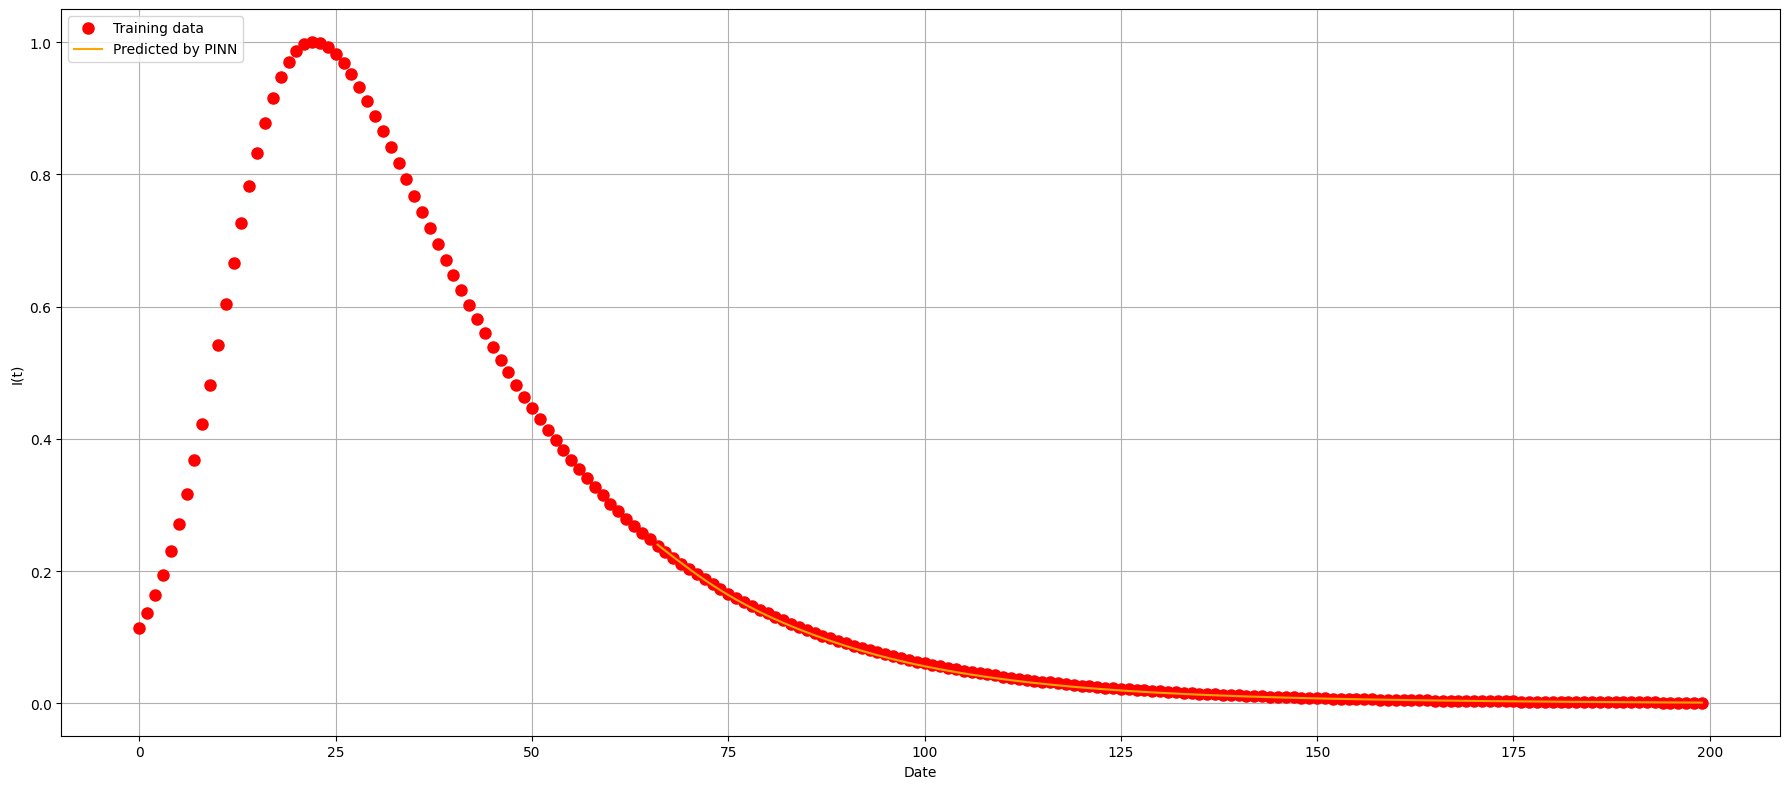

Epoch 241, MSE Loss = 7.842716698291952e-09, Average Loss = 9.402688962044854e-05
Epoch 251, MSE Loss = 3.1858428428677144e-07, Average Loss = 0.0002812033154310775
Epoch 251, MSE Loss = 3.1659528758609667e-06, Average Loss = 0.0003177791750355012
Epoch 251, MSE Loss = 1.3989375702294637e-07, Average Loss = 8.788794327591226e-05
Epoch 251, MSE Loss = 1.1369273806849378e-06, Average Loss = 0.0003844663980471233
Epoch 251, MSE Loss = 5.0594239837664645e-06, Average Loss = 0.0005807733423928117
Epoch 251, MSE Loss = 2.430137328701676e-06, Average Loss = 0.0002323871854916757
Epoch 251, MSE Loss = 4.952013910042297e-07, Average Loss = 0.0005207123764255907
Epoch 251, MSE Loss = 2.850900045814342e-06, Average Loss = 0.0005764611486805597
Epoch 251, MSE Loss = 3.608896292917052e-07, Average Loss = 0.0001723546445103785
Epoch 251, MSE Loss = 2.761949424723298e-08, Average Loss = 8.613289294707278e-05
Epoch 261, MSE Loss = 3.5029206628678367e-06, Average Loss = 0.00014245574903763922
Epoch 261

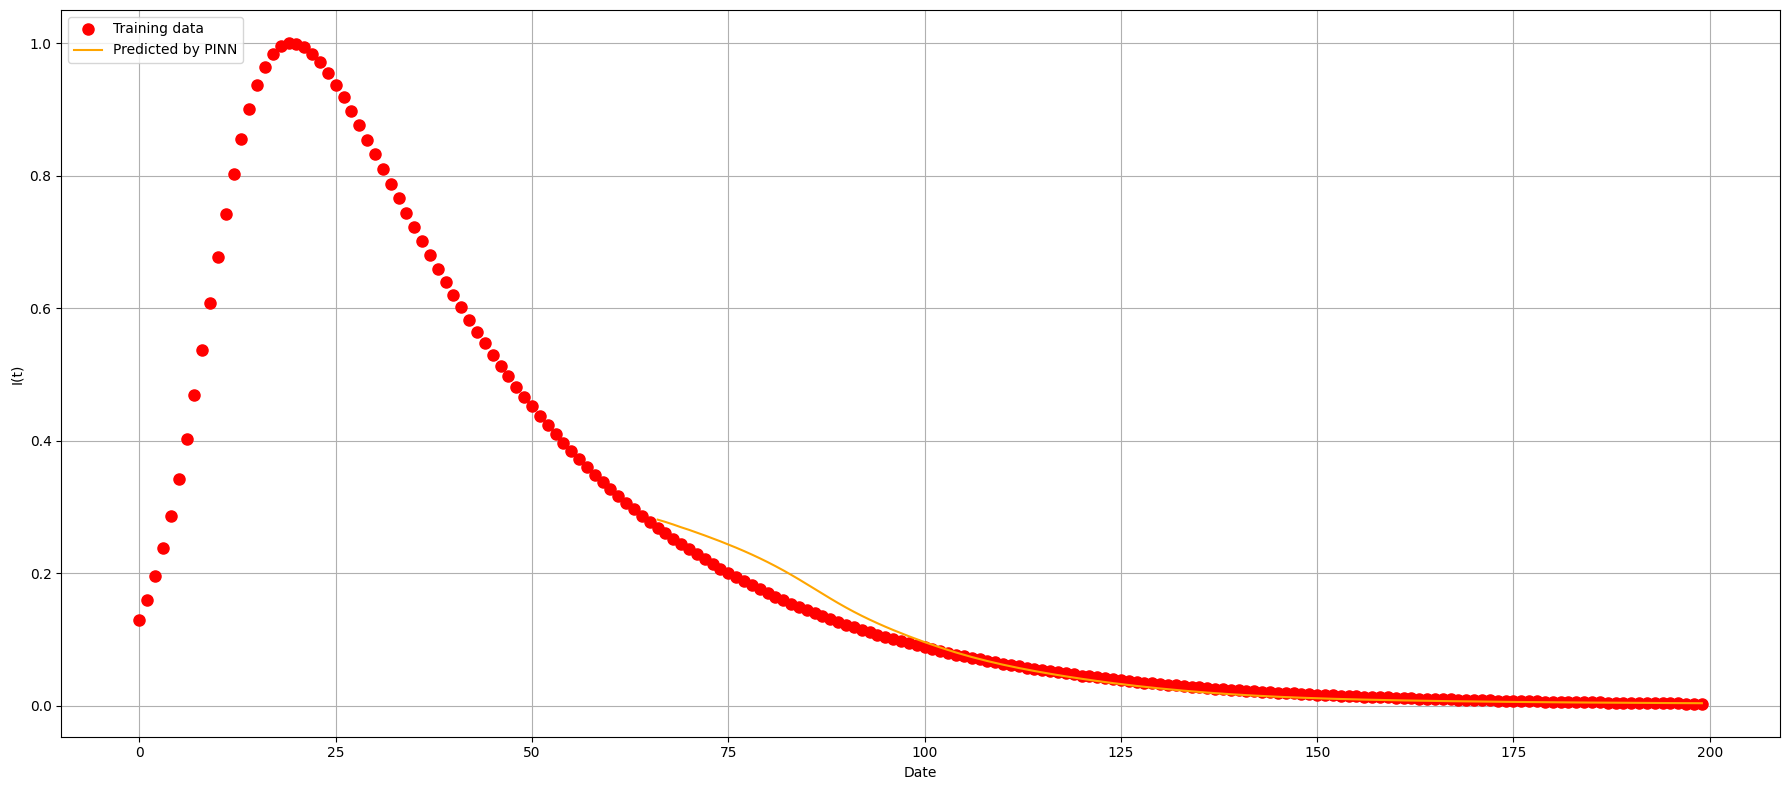

Epoch 281, MSE Loss = 5.277366881273338e-07, Average Loss = 7.443012785296682e-05


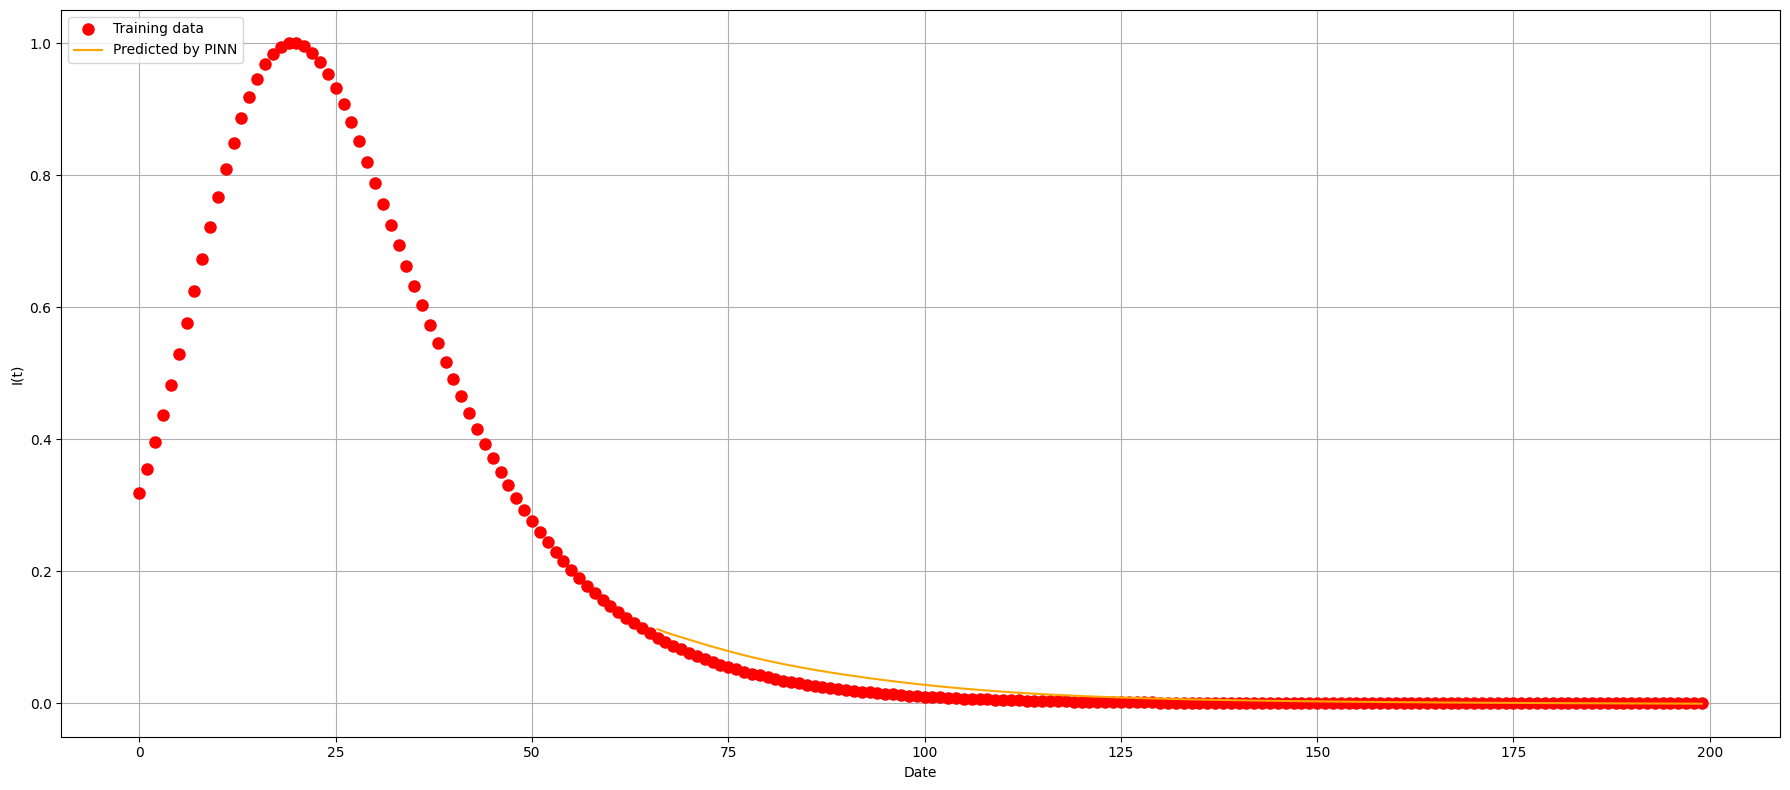

Epoch 281, MSE Loss = 1.696284890329025e-08, Average Loss = 0.00010846557691267047


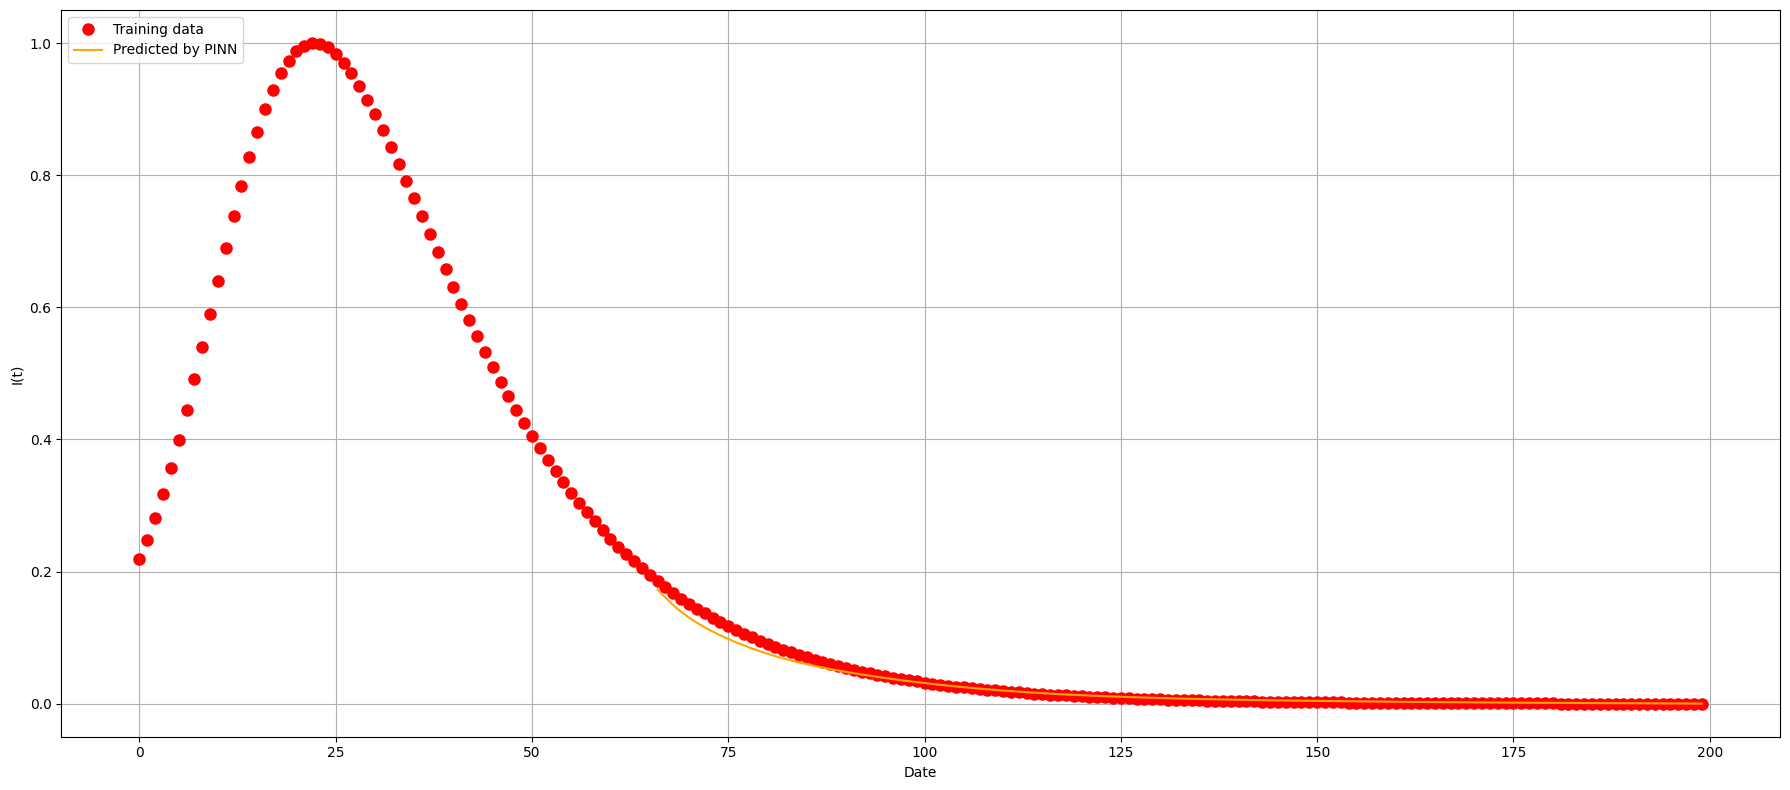

Epoch 281, MSE Loss = 3.987253194281948e-07, Average Loss = 1.8373285456301007e-05


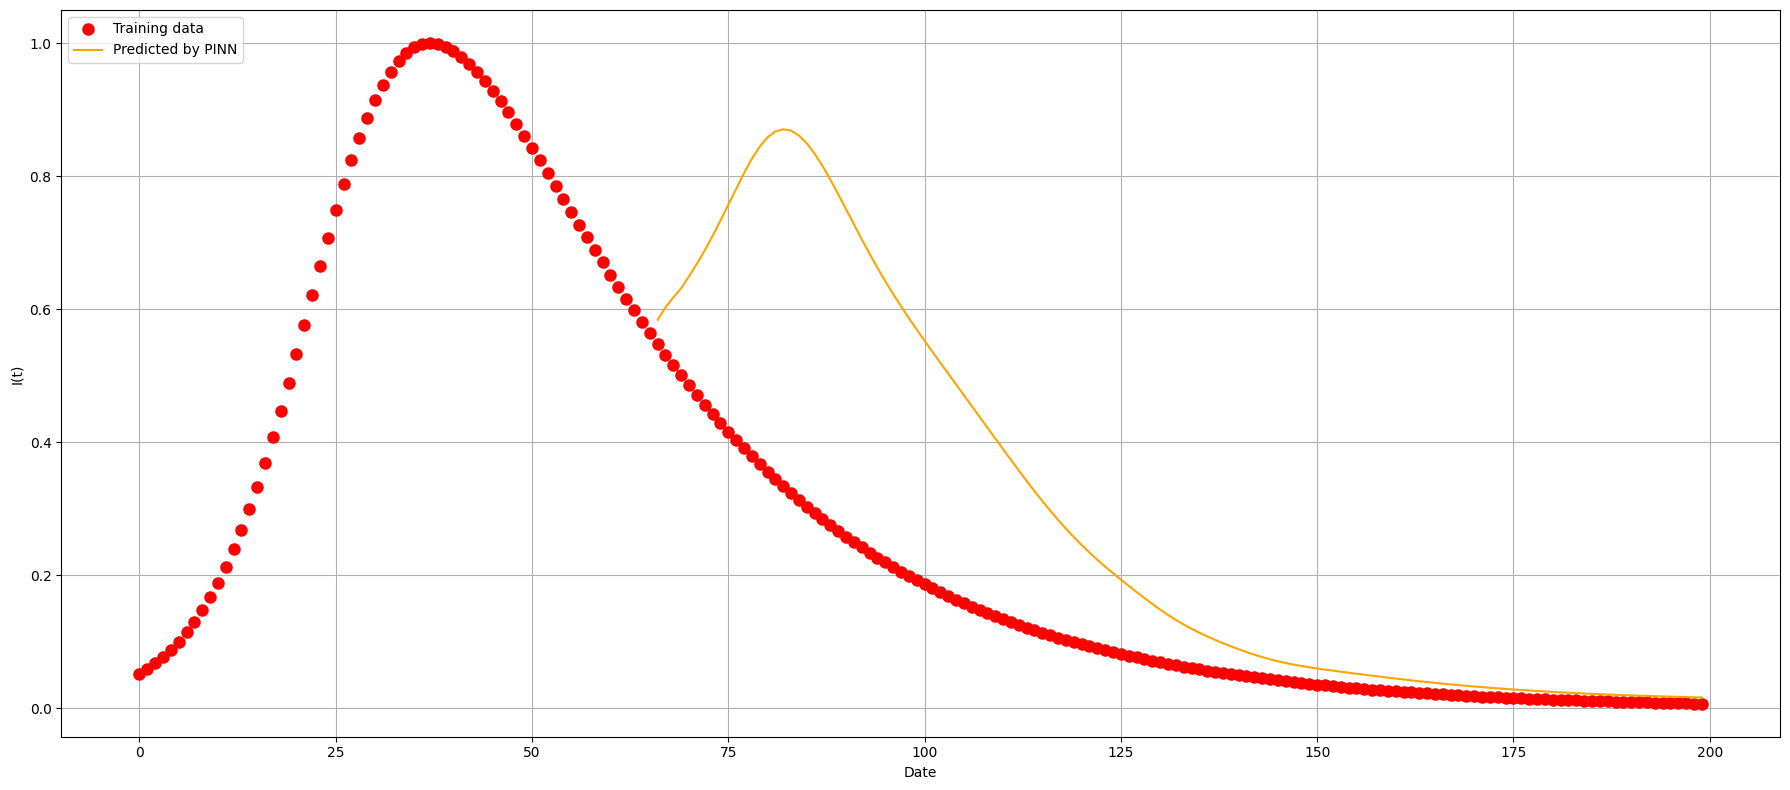

Epoch 281, MSE Loss = 1.3419743538634066e-07, Average Loss = 0.0001735043435647028


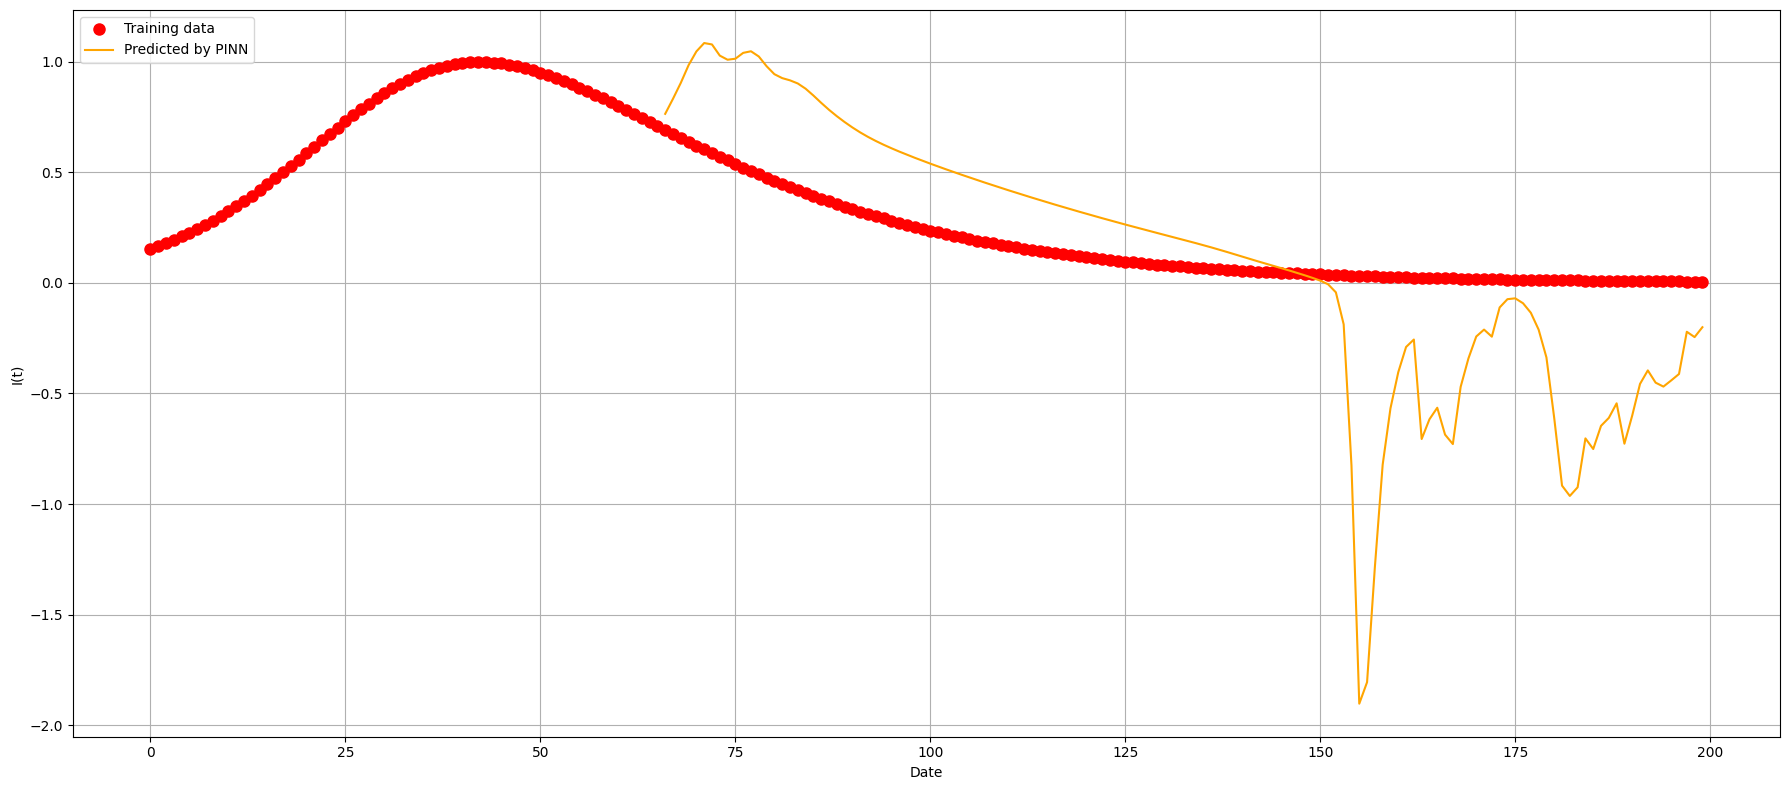

Epoch 281, MSE Loss = 3.0057376534387004e-06, Average Loss = 0.0002492231721545493


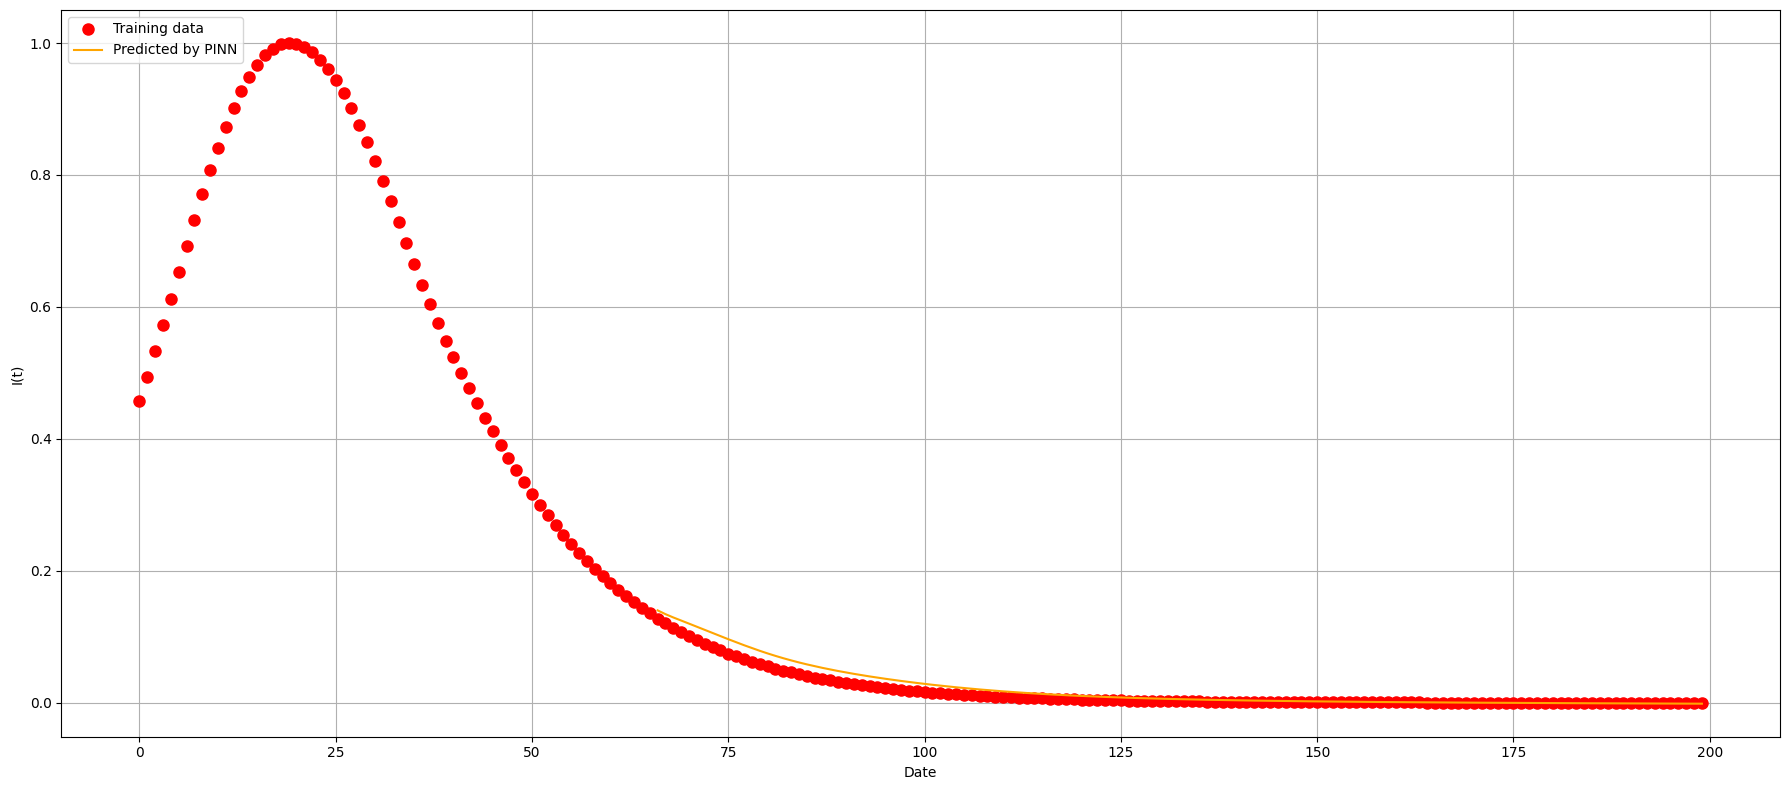

Epoch 281, MSE Loss = 8.892395726434188e-07, Average Loss = 0.00014832850127365074


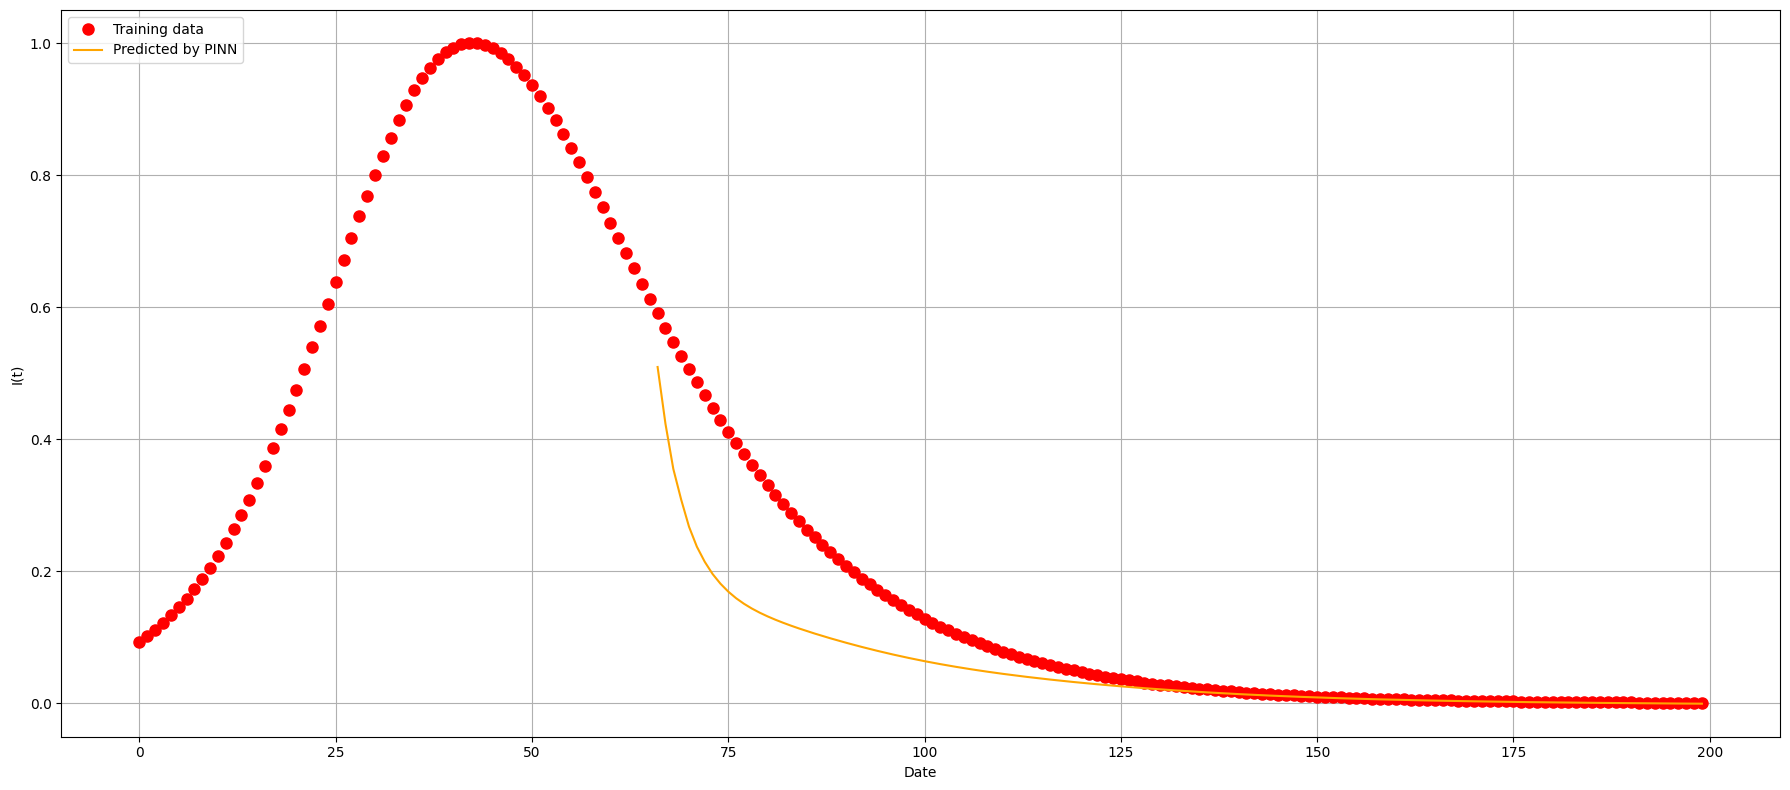

Epoch 281, MSE Loss = 3.3497951790195657e-07, Average Loss = 0.0001836128222179908


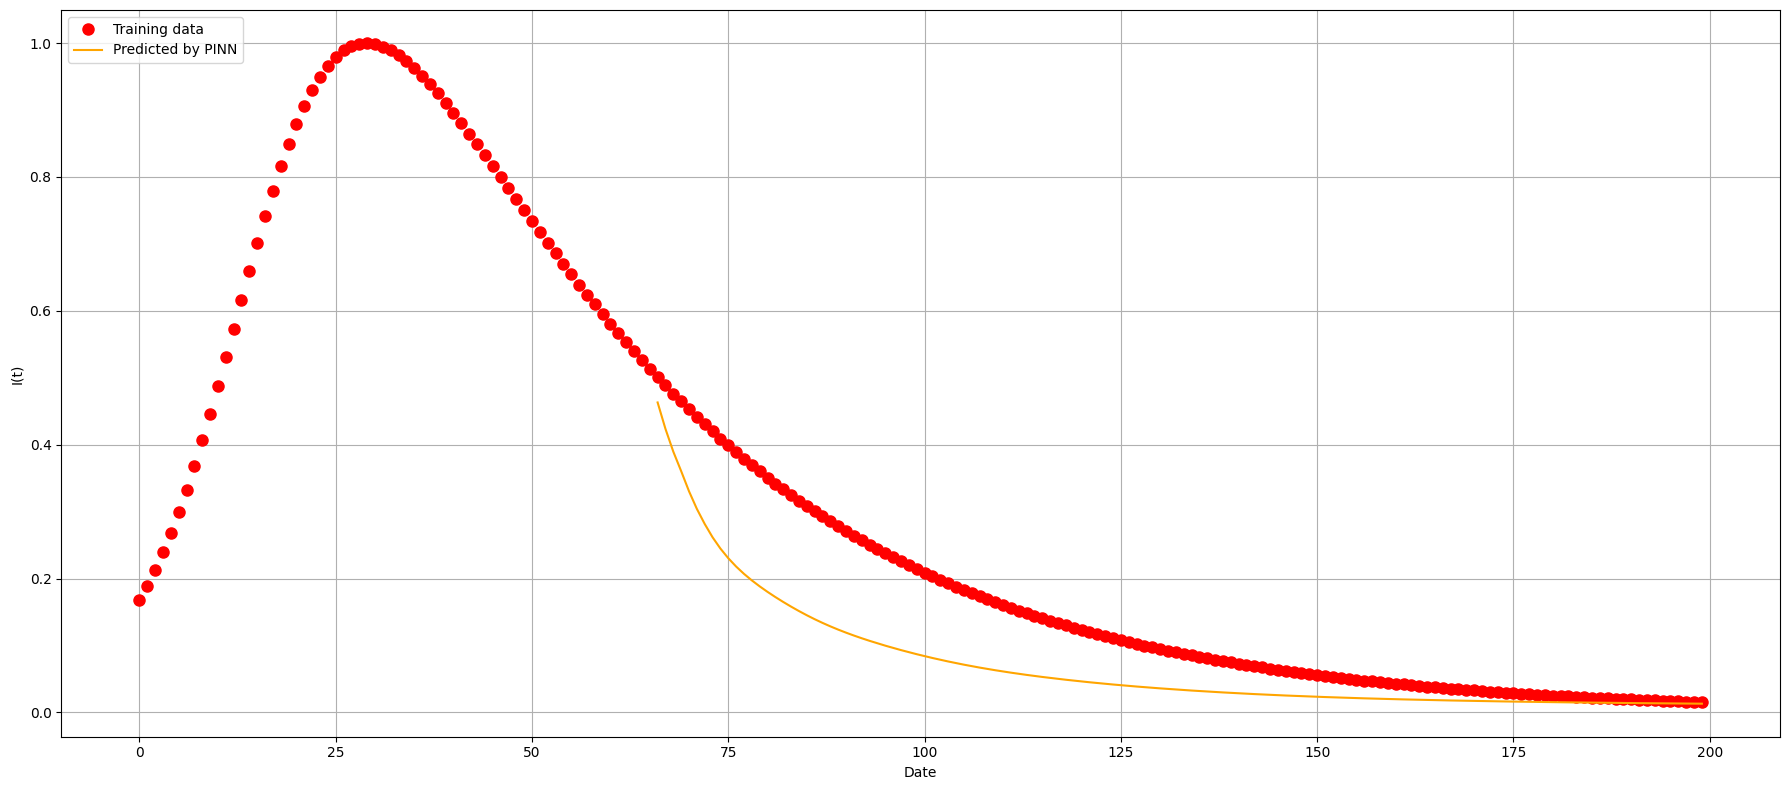

Epoch 281, MSE Loss = 7.3907471254131e-09, Average Loss = 0.00031196330540469666


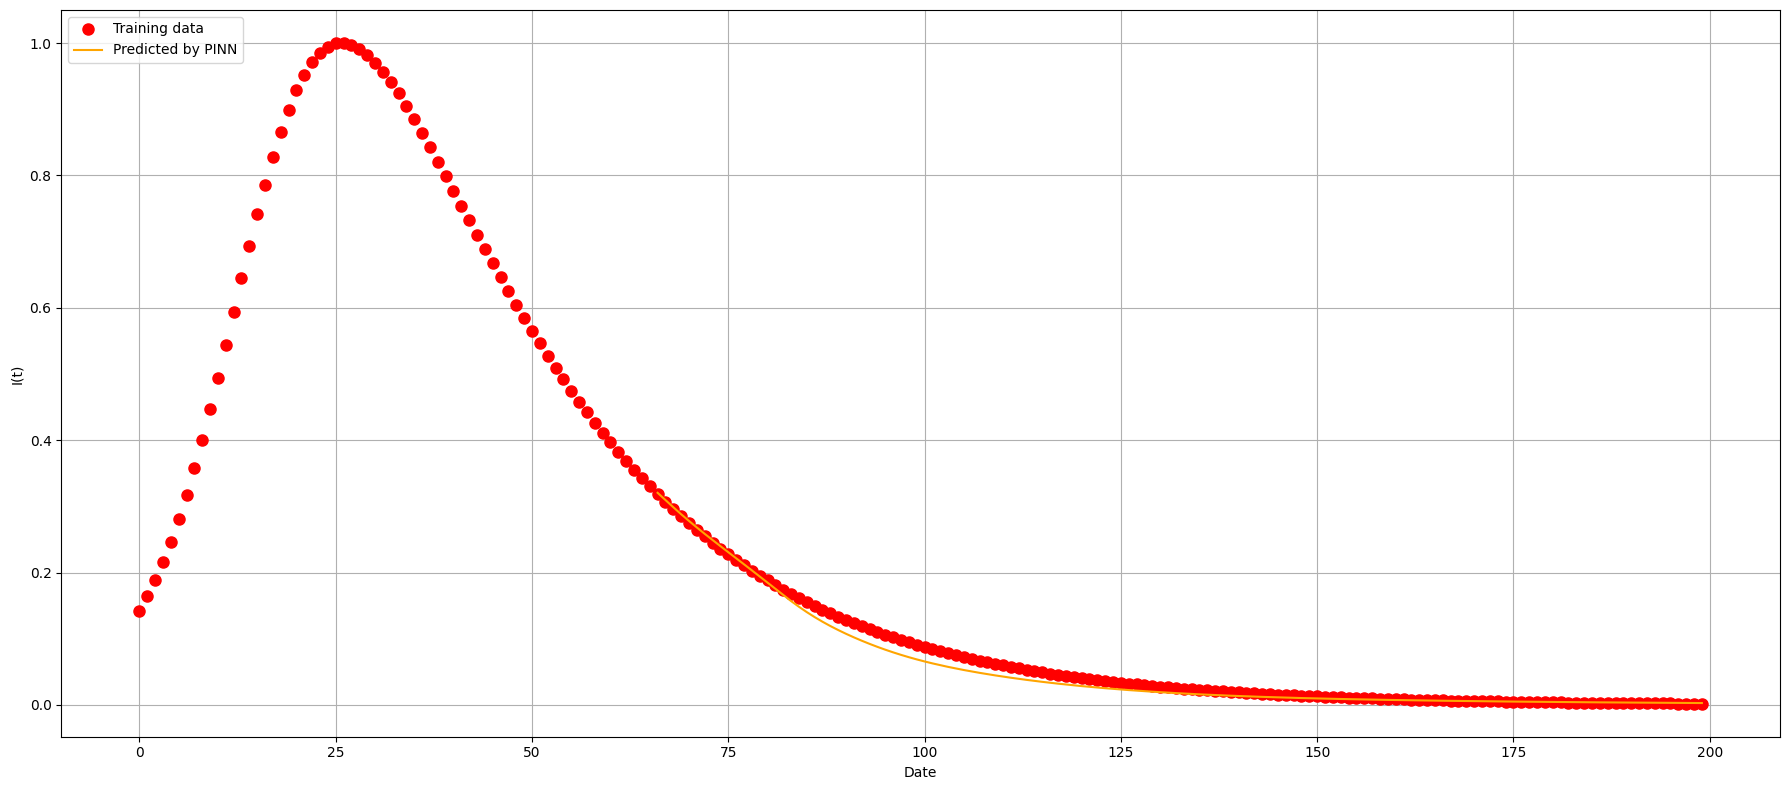

Epoch 281, MSE Loss = 6.464768631531115e-08, Average Loss = 0.00014705326567628706


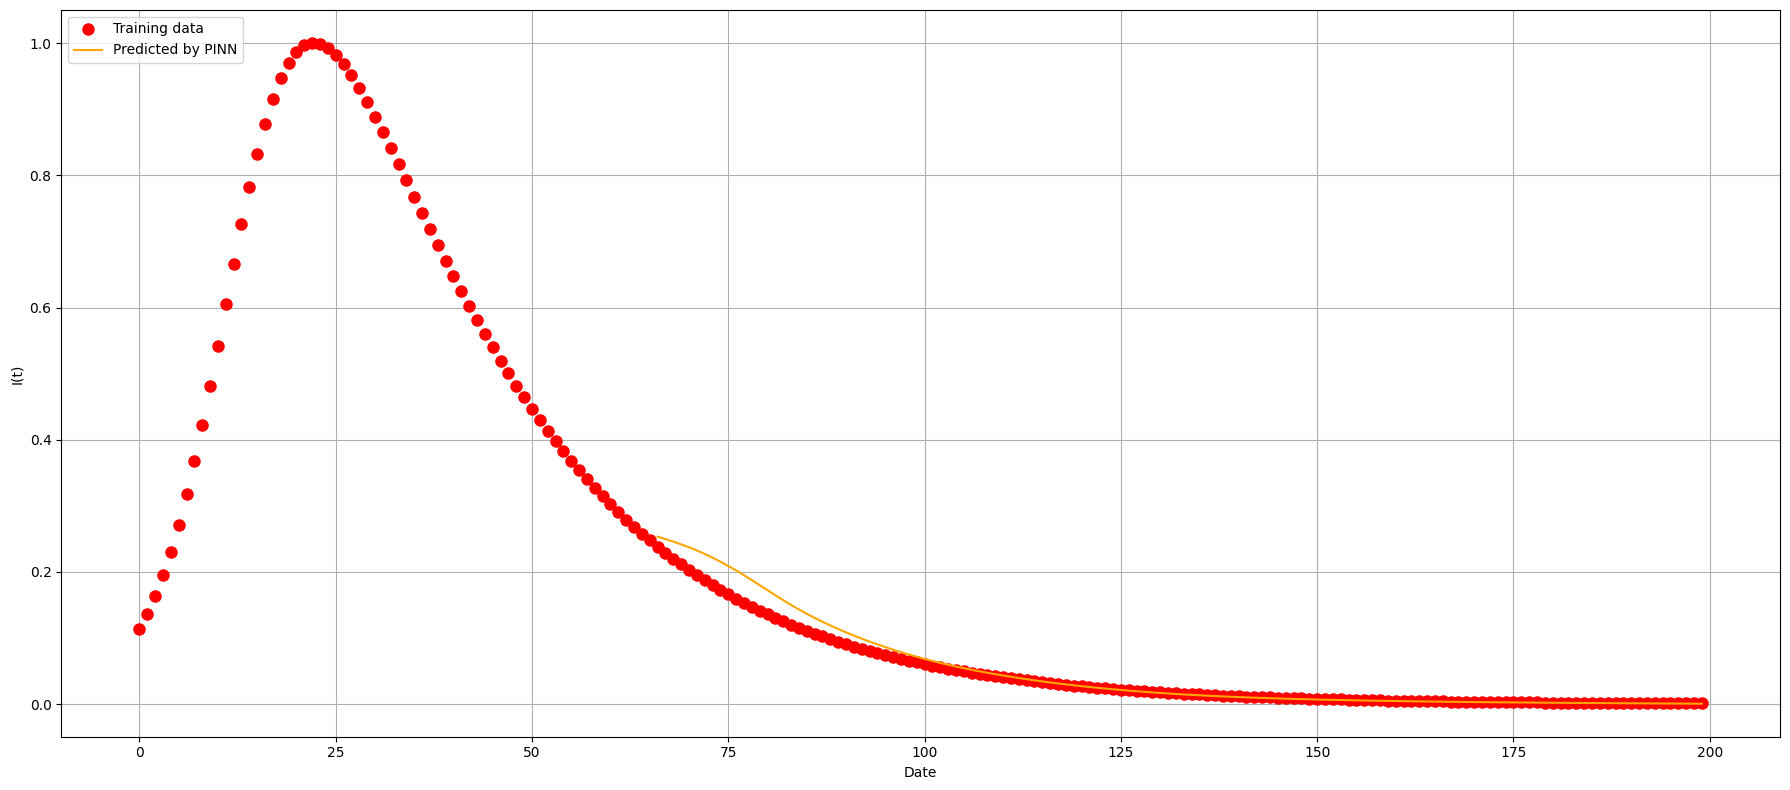

Epoch 281, MSE Loss = 3.974606244128154e-08, Average Loss = 4.9705599271609366e-05
Early stopping at epoch 288.


In [51]:
#autoregressive training version
def train_autoregressive(model, optimizer, data, t_data, sigma, sigma0, mu, epoch, display_step):
    # Number of autoregressive steps (how far ahead to predict at each iteration)
    start_point = 7  # Predict one week ahead

    model.train()

    optimizer.zero_grad()
    total_loss = 0.0

    input_sequence = data[:start_point]
    input_t_sequence = t_data[:start_point]

    input_sequence = list(input_sequence)

    delta_t = 7

    for i in range(start_point, len(data), delta_t):
        input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
        input_tensor = torch.tensor(input_sequence, dtype=torch.float32).view(-1, 1).to(device)
        target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)

        with torch.backends.cudnn.flags(enabled=False):
            # Forward pass
            predicted = model(input_tensor)
            mse_loss = MSE_loss(target, predicted)
            sir_loss = 0
            # sir_loss = SIR_loss(model, input_t, sigma, sigma0, mu)
            # Combine losses
            loss = mse_loss + sir_loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() # Clear gradients

        total_loss += loss.item()

        input_sequence.append(data[i:i+delta_t])

    avg_loss = total_loss / (len(data) - start_point)

    test_start_point = int(len(data) / 3)

    if epoch % display_step == 0:
        with torch.no_grad():
            predicted_values = autoregressive_predict(model, data[:test_start_point], len(data) - test_start_point, delta_t=1)
            # Ensure dimensions match for plotting
            predicted_values = predicted_values[:len(data) - start_point]  # Slice to match y_data
            plot_predictions(
                data,
                test_start_point,
                predicted_values=predicted_values,
                epoch=epoch,
            )

    return mse_loss, sir_loss, avg_loss

def autoregressive_predict(model, given_data, steps, delta_t):
    """
    Predict future values in an autoregressive manner with multi-step outputs.
    
    Parameters:
        model: Trained PINN model
        data: data for prediction test
        steps: Number of future steps to predict
        delta_t: Step size for time
    
    Returns:
        Predicted values (list)
    """
    model.eval()
    input_sequence = list(given_data)
    predictions = torch.tensor([])

    with torch.no_grad():
        for _ in range(steps):
            input_tensor = torch.tensor(input_sequence, dtype=torch.float32).view(-1, 1).to(device)
            predicted = model(input_tensor).squeeze()
            predictions = np.append(predictions, predicted.cpu().numpy())
            input_sequence.append(predicted)
    
    return predictions

# Initialize parameters
sigma = torch.tensor([0.1], requires_grad=True).to(device)
sigma0 = torch.tensor([0.1], requires_grad=True).to(device)
mu = torch.tensor([0.1], requires_grad=True).to(device)

# Initialize the model and optimizer
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 1000
patience = 100
display_step = 40

early_stopping = EarlyStopping(model, patience, display_step, sigma, sigma0, mu)
losses = []

for epoch in range(epochs):
    for datasets in sir_datasets:
        optimizer.zero_grad()

        t, I = datasets.tensors

        train_data = I / max(I)  # Normalize data

        mse_loss, sir_loss, avg_loss = train_autoregressive(
            model=model,
            optimizer=optimizer,
            data=train_data,
            t_data=t,
            sigma=sigma,
            sigma0=sigma0,
            mu=mu,
            epoch=epoch,
            display_step=display_step,
        )

        losses.append(avg_loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}, MSE Loss = {mse_loss.item()}, Average Loss = {avg_loss}")
            #print(f"Epoch {epoch+1}, MSE Loss = {mse_loss.item()}, SIR Loss = {sir_loss.item()}, Average Loss = {avg_loss}")

    if early_stopping.check_early_stopping(avg_loss, epoch):
        break